# بسم الله الرحمن الرحیم

**--------------------------------**

**Developing VC**

**--------------------------------**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted successfully!")

Mounted at /content/drive
Google Drive mounted successfully!


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchaudio
import torchaudio.transforms as T
from tqdm.notebook import tqdm
import numpy as np
import time

In [ ]:
# --- Configuration Class ---
# (Keep your existing Config class as is)
class Config:
    # Dataset paths
    VC_DIR = "/content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental" # Base VCTK dataset directory
    VC_Output = "/content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2" # Base VCTK dataset directory
    WAV_DIR = os.path.join(VC_DIR, "wav48") # Directory containing wav files
    METADATA_PATH = os.path.join(VC_DIR, "speaker-info.txt") # Speaker metadata file path

    # Audio processing parameters
    SAMPLE_RATE = 22050 # Target sample rate for all audio (Hz)
    N_MELS = 80         # Number of Mel bands for spectrogram
    N_FFT = 1024         # FFT window size (samples)
    HOP_LENGTH = 256    # Hop length (samples) between windows

    # Training parameters
    BATCH_SIZE = 32
    NUM_WORKERS = 2    # Number of CPU workers for data loading
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_EPOCHS = 50
    TRAIN_SPLIT_RATIO = 0.8 # 80% for training, 20% for validation
    RANDOM_SEED = 42    # For reproducibility

    # Device configuration
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Model parameters (Specific to this VC architecture)
    Z_CONTENT_DIM = 256 # Dimension for speaker-invariant content embedding
    Z_GENDER_DIM = 16   # Dimension for gender embedding
    Z_ACCENT_DIM = 64   # Dimension for accent embedding
    Z_SPEAKER_ID_DIM = 256 # Dimension for individual speaker ID embedding (like x-vector)
    Z_AGE_DIM = 32      # Dimension for age embedding (you can adjust this)
    Z_REGION_DIM = 64   # Dimension for region embedding (you can adjust this)

# Create directories if they don't exist
if not os.path.exists(Config.VC_DIR):
    os.makedirs(Config.VC_DIR)
if not os.path.exists(Config.WAV_DIR):
    os.makedirs(Config.WAV_DIR)

print(f"Using device: {Config.DEVICE}")
print(f"VC_DIR: {Config.VC_DIR}")
print(f"WAV_DIR: {Config.WAV_DIR}")


# --- Step 1: Load and Process Speaker Metadata ---
# This part reads your speaker-info.txt to get AGE, GENDER, ACCENTS, and REGION for each speaker ID.
speaker_metadata = {}
unique_genders = set()
unique_accents = set()
unique_regions = set() # New set for unique regions
unique_ages = set()
all_speaker_ids = set()

# Load metadata from speaker-info.txt
try:
    with open(Config.METADATA_PATH, 'r') as f:
        # Skip header
        header = f.readline().strip().split() # This reads "ID AGE GENDER ACCENTS REGION"
        print(f"Metadata header found: {header}")

        for line in f:
            parts = line.strip().split()
            # The 'REGION' column can have multiple words (e.g., "Southern England").
            # Simple split might combine "Southern" and "England" if there are multiple spaces,
            # but usually, for VCTK, it's tab-separated or fixed-width, or just space-separated
            # where multi-word regions are still handled as single entries after the accent.

            # Let's adjust based on the structure:
            # ID (0), AGE (1), GENDER (2), ACCENTS (3), REGION (4 onwards)
            if len(parts) >= 5: # Ensure there are enough parts for ID, AGE, GENDER, ACCENTS, REGION
                speaker_id = parts[0]
                age = parts[1] # Age is typically an integer, but can be read as string first
                gender = parts[2]
                accent = parts[3]
                # Region might be multiple words, so join the rest of the parts
                region = " ".join(parts[4:])

                # Store all extracted information
                speaker_metadata[speaker_id] = {
                    'age': age,
                    'gender': gender,
                    'accent': accent,
                    'region': region
                }
                unique_genders.add(gender)
                unique_accents.add(accent)
                unique_regions.add(region) # Add region to the set
                unique_ages.add(age)
                all_speaker_ids.add(speaker_id)
            else:
                print(f"Warning: Skipping malformed line in metadata: {line.strip()} (expected at least 5 parts)")

except FileNotFoundError:
    print(f"Error: speaker-info.txt not found at {Config.METADATA_PATH}.")
    print("Please ensure the VCTK dataset is correctly set up and the path is accurate.")
    # Exit or handle gracefully if essential file is missing
    exit()
except Exception as e:
    print(f"An unexpected error occurred while reading metadata: {e}")
    exit()

# Create integer mappings for categorical data (gender, accent, region)
speaker_id_to_int = {sid: i for i, sid in enumerate(sorted(list(all_speaker_ids)))}
gender_to_id = {gender: i for i, gender in enumerate(sorted(list(unique_genders)))}
accent_to_id = {accent: i for i, accent in enumerate(sorted(list(unique_accents)))}
region_to_id = {region: i for i, region in enumerate(sorted(list(unique_regions)))} # New mapping for regions
age_to_id = {age: i for i, age in enumerate(sorted(list(unique_ages)))} # New mapping for ages

print(f"Loaded metadata for {len(speaker_metadata)} speakers.")
print(f"Unique Genders: {unique_genders} (Mapped to: {gender_to_id})")
print(f"Unique Accents: {unique_accents} (Mapped to: {accent_to_id})")
print(f"Unique Regions: {unique_regions} (Mapped to: {region_to_id})") # Print regions
print(f"Unique ages: {unique_ages} (Mapped to: {age_to_id})") # Print ages
print(f"Total Speakers: {len(speaker_id_to_int)}")

# Example of accessing the new data for a speaker (e.g., '225')
if '225' in speaker_metadata:
    print(f"\nExample speaker '225' metadata: {speaker_metadata['225']}")
    print(f"Mapped IDs for speaker '225':")
    print(f"  Speaker ID: {speaker_id_to_int['225']}")
    print(f"  Gender ID: {gender_to_id[speaker_metadata['225']['gender']]}")
    print(f"  Accent ID: {accent_to_id[speaker_metadata['225']['accent']]}")
    print(f"  Region ID: {region_to_id[speaker_metadata['225']['region']]}")
    print(f"  Age ID: {age_to_id[speaker_metadata['225']['age']]}")

Using device: cuda
VC_DIR: /content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental
WAV_DIR: /content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental/wav48
Metadata header found: ['ID', 'AGE', 'GENDER', 'ACCENTS', 'REGION']
Loaded metadata for 102 speakers.
Unique Genders: {'F', 'M'} (Mapped to: {'F': 0, 'M': 1})
Unique Accents: {'Canadian', 'Welsh', 'Scottish', 'Irish', 'American', 'English', 'NewZealand', 'SouthAfrican', 'Australian', 'NorthernIrish'} (Mapped to: {'American': 0, 'Australian': 1, 'Canadian': 2, 'English': 3, 'Irish': 4, 'NewZealand': 5, 'NorthernIrish': 6, 'Scottish': 7, 'SouthAfrican': 8, 'Welsh': 9})
Unique Regions: {'San Francisco', 'Selkirk', 'Yorkshire', 'Alabama', 'Perth', 'Leicester', 'Tennessee', 'Edinburgh', 'North Carolina', 'Alberta', 'Ross', 'Cardiff', 'NE England', 'SE England', 'New York', 'New Jersey', 'Southern England', 'Midlothian', 'SW England', 'Philadelphia', 'Manchester', 'West Dumfries', 'Derry', 'Aberdeen', 'New England', 'Dublin', 'Hamil

In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset # Added Subset import
from tqdm import tqdm

# Assuming Config is defined and the metadata processing (Step 1)
# which defines speaker_metadata, speaker_id_to_int, gender_to_id,
# accent_to_id, region_to_id, and age_to_id has been executed.

# --- Step 2: VCTK Dataset Preparation (Mel Spectrograms) ---
# Define the Mel Spectrogram transform (CPU-bound initially)
mel_spectrogram_transform_cpu = T.MelSpectrogram( # Renamed for clarity
    sample_rate=Config.SAMPLE_RATE,
    n_fft=Config.N_FFT,
    hop_length=Config.HOP_LENGTH,
    n_mels=Config.N_MELS
)

# worker_transforms = {} # This is not needed as it's handled within the dataset object

class VCTKMelDataset(Dataset):
    def __init__(self, wav_dir, speaker_metadata, speaker_id_to_int,
                 gender_to_id, accent_to_id, region_to_id, age_to_id, # Added region_to_id, age_to_id
                 mel_transform_cpu):
        self.wav_dir = wav_dir
        self.speaker_metadata = speaker_metadata
        self.speaker_id_to_int = speaker_id_to_int
        self.gender_to_id = gender_to_id
        self.accent_to_id = accent_to_id
        self.region_to_id = region_to_id # Store new mappings
        self.age_to_id = age_to_id       # Store new mappings

        self.mel_transform_cpu = mel_transform_cpu

        # These will be initialized per worker in worker_init_fn
        # (or manually for num_workers=0)
        self.mel_transform_on_device = None
        self.resampler_cache = {}

        self.data_samples = self._load_data_samples()

    def _load_data_samples(self):
        data_samples = []
        print("Loading audio file paths and preparing dataset indices...")
        for speaker_id_from_metadata in tqdm(self.speaker_id_to_int.keys(), desc="Processing Speakers"):
            speaker_dir_name = speaker_id_from_metadata
            if not speaker_dir_name.startswith('p'):
                speaker_dir_name = 'p' + speaker_dir_name
            speaker_path = os.path.join(self.wav_dir, speaker_dir_name)

            if not os.path.isdir(speaker_path):
                print(f"Warning: Speaker directory {speaker_path} not found. Skipping.")
                continue

            # Retrieve all metadata for the current speaker
            speaker_info = self.speaker_metadata[speaker_id_from_metadata]

            speaker_int_id = self.speaker_id_to_int[speaker_id_from_metadata]

            gender_label = speaker_info['gender']
            gender_int_id = self.gender_to_id[gender_label]

            accent_label = speaker_info['accent']
            accent_int_id = self.accent_to_id[accent_label]

            # NEW: Get region and age labels and their integer IDs
            region_label = speaker_info['region']
            region_int_id = self.region_to_id[region_label]

            age_label = speaker_info['age']
            age_int_id = self.age_to_id[age_label]


            for filename in os.listdir(speaker_path):
                if filename.endswith(".wav"):
                    file_path = os.path.join(speaker_path, filename)
                    data_samples.append({
                        'file_path': file_path,
                        'speaker_id': speaker_int_id,
                        'gender_id': gender_int_id,
                        'accent_id': accent_int_id,
                        'region_id': region_int_id, # Added
                        'age_id': age_int_id         # Added
                    })
        print(f"Finished loading {len(data_samples)} audio file paths.")
        return data_samples

    def __len__(self):
        return len(self.data_samples)

    def __getitem__(self, idx):
        # Ensure transforms are initialized. This block serves as a fallback for num_workers=0,
        # but for num_workers > 0, worker_init_fn will handle it.
        if self.mel_transform_on_device is None:
            # print(f"WARNING: Transforms not initialized by worker_init_fn. Doing it now in __getitem__ for main process.")
            self.mel_transform_on_device = self.mel_transform_cpu.to(Config.DEVICE)
            self.resampler_cache = {}

        sample_info = self.data_samples[idx]
        file_path = sample_info['file_path']

        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"ERROR loading {file_path}: {e}")
            raise # Re-raise to get full traceback

        resampler_on_device = None
        if sample_rate != Config.SAMPLE_RATE:
            resampler_key = f"{sample_rate}_to_{Config.SAMPLE_RATE}"
            if resampler_key not in self.resampler_cache:
                self.resampler_cache[resampler_key] = T.Resample(orig_freq=sample_rate, new_freq=Config.SAMPLE_RATE).to(Config.DEVICE)
            resampler_on_device = self.resampler_cache[resampler_key]

        if resampler_on_device is not None:
            waveform = resampler_on_device(waveform.to(Config.DEVICE))
        else:
            waveform = waveform.to(Config.DEVICE)

        if waveform.shape[0] > 1:
            waveform = waveform[0, :].unsqueeze(0)

        mel_spec = self.mel_transform_on_device(waveform)
        mel_spec = torch.log(mel_spec + 1e-6)
        mel_spec = mel_spec.squeeze(0)

        return {
            'mel_spec': mel_spec.cpu(),
            'speaker_id': torch.tensor(sample_info['speaker_id'], dtype=torch.long),
            'gender_id': torch.tensor(sample_info['gender_id'], dtype=torch.long),
            'accent_id': torch.tensor(sample_info['accent_id'], dtype=torch.long),
            'region_id': torch.tensor(sample_info['region_id'], dtype=torch.long), # Added
            'age_id': torch.tensor(sample_info['age_id'], dtype=torch.long)         # Added
        }

def collate_fn(batch):
    max_time = max(item['mel_spec'].shape[1] for item in batch)
    padded_mel_specs = []
    for item in batch:
        mel_spec = item['mel_spec']
        padding_size = max_time - mel_spec.shape[1]
        padded_mel = F.pad(mel_spec, (0, padding_size), "constant", 0)
        padded_mel_specs.append(padded_mel)
    batch_mel_specs = torch.stack(padded_mel_specs)

    batch_speaker_ids = torch.stack([item['speaker_id'] for item in batch])
    batch_gender_ids = torch.stack([item['gender_id'] for item in batch])
    batch_accent_ids = torch.stack([item['accent_id'] for item in batch])
    batch_region_ids = torch.stack([item['region_id'] for item in batch]) # Added
    batch_age_ids = torch.stack([item['age_id'] for item in batch])       # Added

    return {
        'mel_spec': batch_mel_specs,
        'speaker_id': batch_speaker_ids,
        'gender_id': batch_gender_ids,
        'accent_id': batch_accent_ids,
        'region_id': batch_region_ids, # Added
        'age_id': batch_age_ids         # Added
    }

def worker_init_fn(worker_id):
    # print(f"Worker {worker_id}: worker_init_fn started.") # Uncomment for debugging
    worker_info = torch.utils.data.get_worker_info()
    if worker_info is not None:
        dataset_obj = worker_info.dataset
        if isinstance(dataset_obj, Subset):
            actual_dataset = dataset_obj.dataset
        else:
            actual_dataset = dataset_obj

        # Move the mel transform to the correct device for this worker
        actual_dataset.mel_transform_on_device = actual_dataset.mel_transform_cpu.to(Config.DEVICE)
        # Initialize an empty cache for resamplers for this worker
        actual_dataset.resampler_cache = {}
        # print(f"Worker {worker_id}: worker_init_fn finished.") # Uncomment for debugging

# --- Main execution of Step 2 ---
# IMPORTANT: If num_workers=0, the worker_init_fn is NOT called.
# In that case, you need to manually move the mel_transform to the device for the main process.
if Config.NUM_WORKERS == 0:
    print("Running with num_workers=0. Manually moving Mel transform to device for main process.")
    mel_spectrogram_transform_cpu = mel_spectrogram_transform_cpu.to(Config.DEVICE) # Move to device for main process

vctk_dataset = VCTKMelDataset(
    wav_dir=Config.WAV_DIR,
    speaker_metadata=speaker_metadata,
    speaker_id_to_int=speaker_id_to_int,
    gender_to_id=gender_to_id,
    accent_to_id=accent_to_id,
    region_to_id=region_to_id, # Pass new mapping
    age_to_id=age_to_id,       # Pass new mapping
    mel_transform_cpu=mel_spectrogram_transform_cpu # Use the explicitly named CPU transform
)

vctk_dataloader = DataLoader(
    vctk_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Set back to Config.NUM_WORKERS for proper usage
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False, # Pin memory for GPU
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None # Only pass worker_init_fn if workers > 0
)

print(f"\nDataset created with {len(vctk_dataset)} samples.")
print(f"DataLoader created with {len(vctk_dataloader)} batches (batch size: {Config.BATCH_SIZE}).")

print("\nTesting DataLoader...")
try:
    for i, batch in enumerate(vctk_dataloader):
        print(f"Batch {i+1}:")
        print(f"  Mel Spectrograms shape: {batch['mel_spec'].shape} on {batch['mel_spec'].device}")
        print(f"  Speaker IDs shape: {batch['speaker_id'].shape} on {batch['speaker_id'].device}")
        print(f"  Gender IDs shape: {batch['gender_id'].shape} on {batch['gender_id'].device}")
        print(f"  Accent IDs shape: {batch['accent_id'].shape} on {batch['accent_id'].device}")
        print(f"  Region IDs shape: {batch['region_id'].shape} on {batch['region_id'].device}") # Added
        print(f"  Age IDs shape: {batch['age_id'].shape} on {batch['age_id'].device}")           # Added
        if i == 0:
            print(f"  Example Speaker IDs: {batch['speaker_id'][:5].tolist()}")
            print(f"  Example Gender IDs: {batch['gender_id'][:5].tolist()}")
            print(f"  Example Accent IDs: {batch['accent_id'][:5].tolist()}")
            print(f"  Example Region IDs: {batch['region_id'][:5].tolist()}") # Added
            print(f"  Example Age IDs: {batch['age_id'][:5].tolist()}")       # Added
        break # Process only one batch for testing
    print("DataLoader test successful!")
except Exception as e:
    print(f"DataLoader test failed: {e}")
    import traceback
    traceback.print_exc() # Print full traceback

Loading audio file paths and preparing dataset indices...


Processing Speakers:  78%|███████▊  | 80/102 [00:41<00:12,  1.70it/s]

Processing Speakers: 100%|██████████| 102/102 [00:51<00:00,  1.99it/s]


Finished loading 1970 audio file paths.

Dataset created with 1970 samples.
DataLoader created with 62 batches (batch size: 32).

Testing DataLoader...


/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be r

Batch 1:
  Mel Spectrograms shape: torch.Size([32, 80, 945]) on cpu
  Speaker IDs shape: torch.Size([32]) on cpu
  Gender IDs shape: torch.Size([32]) on cpu
  Accent IDs shape: torch.Size([32]) on cpu
  Region IDs shape: torch.Size([32]) on cpu
  Age IDs shape: torch.Size([32]) on cpu
  Example Speaker IDs: [75, 39, 31, 73, 42]
  Example Gender IDs: [0, 0, 1, 0, 1]
  Example Accent IDs: [0, 3, 7, 2, 7]
  Example Region IDs: [60, 55, 44, 43, 22]
  Example Age IDs: [3, 5, 3, 5, 1]
DataLoader test successful!


**==========================**

**=========MFCC==============**

**==========================**

In [ ]:
import os
import torch
import torchaudio
import torchaudio.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset # Added Subset import
from tqdm import tqdm

# Replace the Mel Spectrogram transform with MFCC transform
mfcc_transform_cpu = T.MFCC(
    sample_rate=Config.SAMPLE_RATE,
    n_mfcc=Config.N_MELS,  # Number of MFCC coefficients to match n_mels
    melkwargs={
        "n_fft": Config.N_FFT,
        "hop_length": Config.HOP_LENGTH,
        "n_mels": Config.N_MELS,
        # Add other melkwargs if needed (e.g., mel_scale, norm, etc.)
    }
)


class VCTKMFCCDataset(Dataset):  # Renamed for clarity
    def __init__(self, wav_dir, speaker_metadata, speaker_id_to_int,
                 gender_to_id, accent_to_id, region_to_id, age_to_id,
                 mfcc_transform_cpu):  # Changed parameter name
        self.wav_dir = wav_dir
        self.speaker_metadata = speaker_metadata
        self.speaker_id_to_int = speaker_id_to_int
        self.gender_to_id = gender_to_id
        self.accent_to_id = accent_to_id
        self.region_to_id = region_to_id
        self.age_to_id = age_to_id

        self.mfcc_transform_cpu = mfcc_transform_cpu  # Changed attribute name

        # These will be initialized per worker
        self.mfcc_transform_on_device = None  # Changed attribute name
        self.resampler_cache = {}

        self.data_samples = self._load_data_samples()

    def _load_data_samples(self):
        data_samples = []
        print("Loading audio file paths and preparing dataset indices...")
        for speaker_id_from_metadata in tqdm(self.speaker_id_to_int.keys(), desc="Processing Speakers"):
            speaker_dir_name = speaker_id_from_metadata
            if not speaker_dir_name.startswith('p'):
                speaker_dir_name = 'p' + speaker_dir_name
            speaker_path = os.path.join(self.wav_dir, speaker_dir_name)

            if not os.path.isdir(speaker_path):
                print(f"Warning: Speaker directory {speaker_path} not found. Skipping.")
                continue

            # Retrieve all metadata for the current speaker
            speaker_info = self.speaker_metadata[speaker_id_from_metadata]

            speaker_int_id = self.speaker_id_to_int[speaker_id_from_metadata]

            gender_label = speaker_info['gender']
            gender_int_id = self.gender_to_id[gender_label]

            accent_label = speaker_info['accent']
            accent_int_id = self.accent_to_id[accent_label]

            # NEW: Get region and age labels and their integer IDs
            region_label = speaker_info['region']
            region_int_id = self.region_to_id[region_label]

            age_label = speaker_info['age']
            age_int_id = self.age_to_id[age_label]


            for filename in os.listdir(speaker_path):
                if filename.endswith(".wav"):
                    file_path = os.path.join(speaker_path, filename)
                    data_samples.append({
                        'file_path': file_path,
                        'speaker_id': speaker_int_id,
                        'gender_id': gender_int_id,
                        'accent_id': accent_int_id,
                        'region_id': region_int_id, # Added
                        'age_id': age_int_id         # Added
                    })
        print(f"Finished loading {len(data_samples)} audio file paths.")
        return data_samples

    def __len__(self):
        return len(self.data_samples)

    def __getitem__(self, idx):
        if self.mfcc_transform_on_device is None:  # Changed attribute name
            self.mfcc_transform_on_device = self.mfcc_transform_cpu.to(Config.DEVICE)  # Changed attribute name
            self.resampler_cache = {}

        sample_info = self.data_samples[idx]
        file_path = sample_info['file_path']

        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"ERROR loading {file_path}: {e}")
            raise

        # Resampling code remains the same
        resampler_on_device = None
        if sample_rate != Config.SAMPLE_RATE:
            resampler_key = f"{sample_rate}_to_{Config.SAMPLE_RATE}"
            if resampler_key not in self.resampler_cache:
                self.resampler_cache[resampler_key] = T.Resample(orig_freq=sample_rate, new_freq=Config.SAMPLE_RATE).to(Config.DEVICE)
            resampler_on_device = self.resampler_cache[resampler_key]

        if resampler_on_device is not None:
            waveform = resampler_on_device(waveform.to(Config.DEVICE))
        else:
            waveform = waveform.to(Config.DEVICE)

        if waveform.shape[0] > 1:
            waveform = waveform[0, :].unsqueeze(0)

        # Use MFCC transform instead of Mel spectrogram
        mfcc = self.mfcc_transform_on_device(waveform)  # Changed transform name
        # No need for log transformation with MFCCs
        mfcc = mfcc.squeeze(0)  # Remove channel dimension

        return {
            'mel_spec': mfcc.cpu(),  # Keep key as 'mel_spec' for compatibility
            'speaker_id': torch.tensor(sample_info['speaker_id'], dtype=torch.long),
            'gender_id': torch.tensor(sample_info['gender_id'], dtype=torch.long),
            'accent_id': torch.tensor(sample_info['accent_id'], dtype=torch.long),
            'region_id': torch.tensor(sample_info['region_id'], dtype=torch.long),
            'age_id': torch.tensor(sample_info['age_id'], dtype=torch.long)
        }

def collate_fn(batch):
    max_time = max(item['mel_spec'].shape[1] for item in batch)
    padded_mel_specs = []
    for item in batch:
        mel_spec = item['mel_spec']
        padding_size = max_time - mel_spec.shape[1]
        padded_mel = F.pad(mel_spec, (0, padding_size), "constant", 0)
        padded_mel_specs.append(padded_mel)
    batch_mel_specs = torch.stack(padded_mel_specs)

    batch_speaker_ids = torch.stack([item['speaker_id'] for item in batch])
    batch_gender_ids = torch.stack([item['gender_id'] for item in batch])
    batch_accent_ids = torch.stack([item['accent_id'] for item in batch])
    batch_region_ids = torch.stack([item['region_id'] for item in batch]) # Added
    batch_age_ids = torch.stack([item['age_id'] for item in batch])       # Added

    return {
        'mel_spec': batch_mel_specs,
        'speaker_id': batch_speaker_ids,
        'gender_id': batch_gender_ids,
        'accent_id': batch_accent_ids,
        'region_id': batch_region_ids, # Added
        'age_id': batch_age_ids         # Added
    }

def worker_init_fn(worker_id):
    # print(f"Worker {worker_id}: worker_init_fn started.") # Uncomment for debugging
    worker_info = torch.utils.data.get_worker_info()
    if worker_info is not None:
        dataset_obj = worker_info.dataset
        if isinstance(dataset_obj, Subset):
            actual_dataset = dataset_obj.dataset
        else:
            actual_dataset = dataset_obj

        # Move the mel transform to the correct device for this worker
        actual_dataset.mel_transform_on_device = actual_dataset.mel_transform_cpu.to(Config.DEVICE)
        # Initialize an empty cache for resamplers for this worker
        actual_dataset.resampler_cache = {}
        # print(f"Worker {worker_id}: worker_init_fn finished.") # Uncomment for debugging

# --- Main execution of Step 2 ---
# IMPORTANT: If num_workers=0, the worker_init_fn is NOT called.
# In that case, you need to manually move the mel_transform to the device for the main process.
if Config.NUM_WORKERS == 0:
    print("Running with num_workers=0. Manually moving Mel transform to device for main process.")
    mel_spectrogram_transform_cpu = mel_spectrogram_transform_cpu.to(Config.DEVICE) # Move to device for main process

vctk_dataset = VCTKMFCCDataset(  # Use the new dataset class
    wav_dir=Config.WAV_DIR,
    speaker_metadata=speaker_metadata,
    speaker_id_to_int=speaker_id_to_int,
    gender_to_id=gender_to_id,
    accent_to_id=accent_to_id,
    region_to_id=region_to_id,
    age_to_id=age_to_id,
    mfcc_transform_cpu=mfcc_transform_cpu  # Use the MFCC transform
)

vctk_dataloader = DataLoader(
    vctk_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=0, # Set back to Config.NUM_WORKERS for proper usage
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False, # Pin memory for GPU
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None # Only pass worker_init_fn if workers > 0
)

print(f"\nDataset created with {len(vctk_dataset)} samples.")
print(f"DataLoader created with {len(vctk_dataloader)} batches (batch size: {Config.BATCH_SIZE}).")

print("\nTesting DataLoader...")
try:
    for i, batch in enumerate(vctk_dataloader):
        print(f"Batch {i+1}:")
        print(f"  Mel Spectrograms shape: {batch['mel_spec'].shape} on {batch['mel_spec'].device}")
        print(f"  Speaker IDs shape: {batch['speaker_id'].shape} on {batch['speaker_id'].device}")
        print(f"  Gender IDs shape: {batch['gender_id'].shape} on {batch['gender_id'].device}")
        print(f"  Accent IDs shape: {batch['accent_id'].shape} on {batch['accent_id'].device}")
        print(f"  Region IDs shape: {batch['region_id'].shape} on {batch['region_id'].device}") # Added
        print(f"  Age IDs shape: {batch['age_id'].shape} on {batch['age_id'].device}")           # Added
        if i == 0:
            print(f"  Example Speaker IDs: {batch['speaker_id'][:5].tolist()}")
            print(f"  Example Gender IDs: {batch['gender_id'][:5].tolist()}")
            print(f"  Example Accent IDs: {batch['accent_id'][:5].tolist()}")
            print(f"  Example Region IDs: {batch['region_id'][:5].tolist()}") # Added
            print(f"  Example Age IDs: {batch['age_id'][:5].tolist()}")       # Added
        break # Process only one batch for testing
    print("DataLoader test successful!")
except Exception as e:
    print(f"DataLoader test failed: {e}")
    import traceback
    traceback.print_exc() # Print full traceback

Loading audio file paths and preparing dataset indices...


Processing Speakers: 100%|██████████| 102/102 [00:00<00:00, 1884.54it/s]

Finished loading 1970 audio file paths.

Dataset created with 1970 samples.
DataLoader created with 62 batches (batch size: 32).

Testing DataLoader...


Batch 1:
  Mel Spectrograms shape: torch.Size([32, 80, 787]) on cpu
  Speaker IDs shape: torch.Size([32]) on cpu
  Gender IDs shape: torch.Size([32]) on cpu
  Accent IDs shape: torch.Size([32]) on cpu
  Region IDs shape: torch.Size([32]) on cpu
  Age IDs shape: torch.Size([32]) on cpu
  Example Speaker IDs: [81, 37, 28, 64, 73]
  Example Gender IDs: [1, 0, 0, 1, 0]
  Example Accent IDs: [2, 4, 3, 4, 2]
  Example Region IDs: [2, 4, 55, 61, 43]
  Example Age IDs: [2, 4, 6, 1, 5]
DataLoader test successful!


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from tqdm import tqdm
import numpy as np # For random splitting

# Assume Config, speaker_metadata, speaker_id_to_int, gender_to_id,
# accent_to_id, region_to_id, age_to_id are already defined from Step 1.

# Assume mel_spectrogram_transform_cpu is defined and VCTKMelDataset,
# collate_fn, worker_init_fn are defined from Step 2.

# Assume vc_encoders, gender_criterion, accent_criterion, speaker_id_criterion,
# age_criterion, region_criterion, optimizer are defined from Step 3 & 4.

# --- Data Splitting Logic ---
print("\n--- Performing Dataset Splits (Train, In-Test, Out-Test) ---")

#First, create the full dataset
vctk_dataset = VCTKMelDataset(
    wav_dir=Config.WAV_DIR,
    speaker_metadata=speaker_metadata,
    speaker_id_to_int=speaker_id_to_int,
    gender_to_id=gender_to_id,
    accent_to_id=accent_to_id,
    region_to_id=region_to_id,
    age_to_id=age_to_id,
    mel_transform_cpu=mel_spectrogram_transform_cpu # This should be the CPU-bound transform
)

# vctk_dataset = VCTKMFCCDataset(  # Use the new dataset class
#     wav_dir=Config.WAV_DIR,
#     speaker_metadata=speaker_metadata,
#     speaker_id_to_int=speaker_id_to_int,
#     gender_to_id=gender_to_id,
#     accent_to_id=accent_to_id,
#     region_to_id=region_to_id,
#     age_to_id=age_to_id,
#     mfcc_transform_cpu=mfcc_transform_cpu  # Use the MFCC transform
# )

# Get all unique speaker IDs that have data in the dataset
# It's important to iterate through the data_samples to get speakers *actually present*
all_speakers_in_dataset = list(set(s['speaker_id'] for s in vctk_dataset.data_samples))
np.random.seed(Config.RANDOM_SEED) # Ensure reproducibility for splits
np.random.shuffle(all_speakers_in_dataset)

# Determine out-test speakers (e.g., 10% of total speakers)
num_out_test_speakers = int(len(all_speakers_in_dataset) * 0.10)
out_test_speaker_ids = set(all_speakers_in_dataset[:num_out_test_speakers])
in_train_val_test_speaker_ids = set(all_speakers_in_dataset[num_out_test_speakers:])

print(f"Total speakers with data: {len(all_speakers_in_dataset)}")
print(f"Out-test speakers ({num_out_test_speakers}): {[k for k,v in speaker_id_to_int.items() if v in out_test_speaker_ids]}") # Map back to original IDs for readability

# --- Create Indices for each split ---
train_indices = []
in_test_indices = [] # Seen speakers, unseen utterances
out_test_indices = [] # Unseen speakers, unseen utterances

# Dictionaries to hold indices for each speaker for "in-test" split
speaker_utterance_indices = {speaker_id: [] for speaker_id in in_train_val_test_speaker_ids}

# Populate indices
for i, sample in enumerate(vctk_dataset.data_samples):
    speaker_id = sample['speaker_id']
    if speaker_id in out_test_speaker_ids:
        out_test_indices.append(i)
    elif speaker_id in in_train_val_test_speaker_ids:
        speaker_utterance_indices[speaker_id].append(i)
    # No 'else' needed as all_speakers_in_dataset covers all
    # speakers that actually have data.

# Now, split the in_train_val_test speakers' utterances into train and in-test
for speaker_id, indices in speaker_utterance_indices.items():
    np.random.shuffle(indices) # Shuffle utterances for each speaker
    # For in-test, take a percentage of utterances from each speaker (e.g., 10%)
    num_in_test_utterances = int(len(indices) * 0.10)
    in_test_indices.extend(indices[:num_in_test_utterances])
    train_indices.extend(indices[num_in_test_utterances:])

# Further split 'train_indices' into actual train and validation sets
# (e.g., 80% train, 20% validation from the train_indices)
np.random.shuffle(train_indices) # Shuffle before splitting
num_train_samples = int(len(train_indices) * Config.TRAIN_SPLIT_RATIO)
actual_train_indices = train_indices[:num_train_samples]
val_indices = train_indices[num_train_samples:]

print(f"Total samples: {len(vctk_dataset)}")
print(f"Train samples: {len(actual_train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"In-Test samples (seen speakers, unseen utterances): {len(in_test_indices)}")
print(f"Out-Test samples (unseen speakers, unseen utterances): {len(out_test_indices)}")


# Create Subset objects for each split
train_dataset = Subset(vctk_dataset, actual_train_indices)
val_dataset = Subset(vctk_dataset, val_indices)
in_test_dataset = Subset(vctk_dataset, in_test_indices)
out_test_dataset = Subset(vctk_dataset, out_test_indices)

# --- Create DataLoaders for each split ---
train_dataloader = DataLoader(
    train_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False,
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False,
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None
)

in_test_dataloader = DataLoader(
    in_test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False,
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None
)

out_test_dataloader = DataLoader(
    out_test_dataset,
    batch_size=Config.BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=0,
    collate_fn=collate_fn,
    pin_memory=True if Config.DEVICE == 'cuda' else False,
    worker_init_fn=worker_init_fn if Config.NUM_WORKERS > 0 else None
)

print(f"\nDataLoaders created for Train ({len(train_dataloader)} batches), Validation ({len(val_dataloader)} batches),")
print(f"In-Test ({len(in_test_dataloader)} batches), and Out-Test ({len(out_test_dataloader)} batches).")


--- Performing Dataset Splits (Train, In-Test, Out-Test) ---
Loading audio file paths and preparing dataset indices...


Processing Speakers: 100%|██████████| 102/102 [00:00<00:00, 1157.36it/s]

Finished loading 1970 audio file paths.
Total speakers with data: 101
Out-test speakers (10): ['225', '236', '250', '268', '273', '274', '285', '300', '301', '326']
Total samples: 1970
Train samples: 1296
Validation samples: 324
In-Test samples (seen speakers, unseen utterances): 154
Out-Test samples (unseen speakers, unseen utterances): 196

DataLoaders created for Train (41 batches), Validation (11 batches),
In-Test (5 batches), and Out-Test (7 batches).


In [ ]:
class Config:
    # Dataset paths
    VC_DIR = "/content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental" # Base VCTK dataset directory
    VC_Output = "/content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2" # Base VCTK dataset directory
    WAV_DIR = os.path.join(VC_DIR, "wav48") # Directory containing wav files
    METADATA_PATH = os.path.join(VC_DIR, "speaker-info.txt") # Speaker metadata file path

    # Audio processing parameters
    SAMPLE_RATE = 22050 # Target sample rate for all audio (Hz)
    N_MELS = 80         # Number of Mel bands for spectrogram
    N_FFT = 1024         # FFT window size (samples)
    HOP_LENGTH = 256    # Hop length (samples) between windows

    # Training parameters
    BATCH_SIZE = 32
    NUM_WORKERS = 2    # Number of CPU workers for data loading
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_EPOCHS = 50
    TRAIN_SPLIT_RATIO = 0.8 # 80% for training, 20% for validation
    RANDOM_SEED = 42    # For reproducibility

    # Device configuration
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Model parameters (Specific to this VC architecture)
    Z_CONTENT_DIM = 256 # Dimension for speaker-invariant content embedding
    Z_GENDER_DIM = 16   # Dimension for gender embedding
    Z_ACCENT_DIM = 64   # Dimension for accent embedding
    Z_SPEAKER_ID_DIM = 256 # Dimension for individual speaker ID embedding (like x-vector)
    Z_AGE_DIM = 32      # Dimension for age embedding (you can adjust this)
    Z_REGION_DIM = 64   # Dimension for region embedding (you can adjust this)


**==========================================**

**-------------Developing Decoder------------**

**==========================================**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Assuming ConvBlock, SharedAudioFeatureExtractor, GenderEncoder, AccentEncoder,
# AgeEncoder, RegionEncoder, SpeakerIDEncoder, ContentEncoder, VoiceConversionEncoders
# are defined as in your previous code snippet.
# For self-contained example, I'll include the necessary ConvBlock again.

class ConvBlock(nn.Module):
    """A simple Convolutional Block with optional Batch Normalization and LeakyReLU."""
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding,
                 use_bn=True, use_dropout=False):
        super().__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm1d(out_channels) if use_bn else None
        self.relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.2) if use_dropout else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn:
            x = self.bn(x)
        x = self.relu(x)
        if self.dropout:
            x = self.dropout(x)
        return x

class Decoder(nn.Module):
    """
    Decoder module to reconstruct Mel spectrogram from content and speaker embeddings.
    """
    def __init__(self, config):
        super().__init__()
        self.n_mels = config.N_MELS

        # Calculate the total dimension of combined speaker embeddings
        self.total_speaker_dim = (
            config.Z_GENDER_DIM + config.Z_ACCENT_DIM +
            config.Z_AGE_DIM + config.Z_REGION_DIM +
            config.Z_SPEAKER_ID_DIM
        )

        # The input to the first decoder block will be z_content concatenated with
        # the broadcasted combined speaker embedding.
        initial_decoder_input_dim = config.Z_CONTENT_DIM + self.total_speaker_dim

        # Decoder layers to progressively transform the features back to Mel spectrogram dimensions.
        # We start with the combined latent space dimension and work towards N_MELS.
        # Use ConvBlock for internal layers.
        # The last layer should output N_MELS and typically doesn't have BN or ReLU
        # as it directly produces the Mel values.

        decoder_hidden_dims = [256, 128, 64] # Example dimensions, can be tuned

        layers = []
        in_c = initial_decoder_input_dim
        for h_dim in decoder_hidden_dims:
            layers.append(ConvBlock(in_c, h_dim, kernel_size=5, stride=1, padding=2))
            in_c = h_dim

        self.decoder_blocks = nn.Sequential(*layers)

        # Final convolutional layer to map to N_MELS
        # Using a kernel size of 5 and padding of 2 to maintain temporal dimension.
        self.final_conv = nn.Conv1d(in_c, self.n_mels, kernel_size=5, stride=1, padding=2)

        # Optional: Add a final activation if your Mel spectrograms are normalized
        # e.g., if Mels are in [0, 1] use nn.Sigmoid(), if in [-1, 1] use nn.Tanh()
        # If they are raw log-mels, a linear output (no activation) is typical.
        # self.final_activation = nn.Sigmoid() # Uncomment and adjust if needed

    def forward(self, z_content, z_gender, z_accent, z_age, z_region, z_speaker_id):
        # z_content shape: (Batch, Z_CONTENT_DIM, N_FRAMES)
        # z_speaker_attrs shapes: (Batch, Z_ATTR_DIM) - static vectors

        # 1. Get the number of frames from content embedding
        batch_size, _, n_frames = z_content.shape

        # 2. Concatenate all speaker embeddings into a single combined vector
        # Resulting shape: (Batch, total_speaker_dim)
        z_speaker_combined = torch.cat(
            (z_gender, z_accent, z_age, z_region, z_speaker_id),
            dim=1
        )

        # 3. Broadcast the combined speaker embedding to match content's temporal dimension
        # (Batch, total_speaker_dim) -> (Batch, total_speaker_dim, 1)
        # -> (Batch, total_speaker_dim, N_FRAMES)
        z_speaker_broadcast = z_speaker_combined.unsqueeze(-1).expand(-1, -1, n_frames)

        # 4. Concatenate z_content and the broadcasted speaker embedding
        # Resulting shape: (Batch, Z_CONTENT_DIM + total_speaker_dim, N_FRAMES)
        decoder_input = torch.cat((z_content, z_speaker_broadcast), dim=1)

        # 5. Pass through the decoder convolutional blocks
        x = self.decoder_blocks(decoder_input)

        # 6. Final convolution to output N_MELS
        output_mel = self.final_conv(x)

        # 7. Apply optional final activation
        # if hasattr(self, 'final_activation'):
        #     output_mel = self.final_activation(output_mel)

        return output_mel

# --- Integration with your existing Encoders and Example Usage ---

# (Re-using your VoiceConversionEncoders and Config placeholder)

# Placeholder for Config (should match your actual Config object)

# Placeholder for your encoders (just for the example to run)
# (You already have these defined above, so you can omit this block in your main file)
class SharedAudioFeatureExtractor(nn.Module):
    def __init__(self, n_mels, hidden_dims=[128, 256, 256]):
        super().__init__()
        layers = []
        in_c = n_mels
        for h_dim in hidden_dims:
            layers.append(ConvBlock(in_c, h_dim, kernel_size=5, stride=2, padding=2))
            in_c = h_dim
        self.conv_blocks = nn.Sequential(*layers)
        self.out_channels = hidden_dims[-1]
    def forward(self, mel_spec): return self.conv_blocks(mel_spec)

class AttributeEncoder(nn.Module): # Using the refactored AttributeEncoder
    def __init__(self, in_channels, num_classes, z_dim):
        super().__init__()
        self.encoder_convs = nn.Sequential(
            ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, in_channels // 2, kernel_size=3, stride=1, padding=1),
        )
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        self.linear_embedding = nn.Linear(in_channels // 2, z_dim)
        self.classifier = nn.Linear(z_dim, num_classes)
    def forward(self, x):
        x = self.encoder_convs(x)
        x = self.gap(x)
        x = self.flatten(x)
        z_attr = self.linear_embedding(x)
        attr_logits = self.classifier(z_attr)
        return z_attr, attr_logits

class SpeakerIDEncoder(nn.Module):
    def __init__(self, in_channels, num_speakers, z_speaker_id_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, in_channels * 2, kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels * 2, in_channels * 2, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool1d(1), # Global average pooling
            nn.Flatten(),
            nn.Linear(in_channels * 2, z_speaker_id_dim) # Output speaker ID embedding
        )
        self.classifier = nn.Linear(z_speaker_id_dim, num_speakers) # For classification/verification objective
    def forward(self, x):
        z_speaker_id = self.encoder(x)
        speaker_logits = self.classifier(z_speaker_id)
        return z_speaker_id, speaker_logits

class ContentEncoder(nn.Module):
    def __init__(self, n_mels, z_content_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            ConvBlock(n_mels, 128, kernel_size=5, stride=1, padding=2),
            ConvBlock(128, 128, kernel_size=5, stride=1, padding=2),
            ConvBlock(128, z_content_dim, kernel_size=5, stride=1, padding=2, use_bn=False),
        )
    def forward(self, mel_spec): return self.encoder(mel_spec)

class VoiceConversionEncoders(nn.Module):
    def __init__(self, config, num_genders, num_accents, num_speakers, num_ages, num_regions):
        super().__init__()
        self.shared_extractor = SharedAudioFeatureExtractor(config.N_MELS)
        shared_out_channels = self.shared_extractor.out_channels

        # Using the refactored AttributeEncoder
        self.gender_encoder = AttributeEncoder(shared_out_channels, num_genders, config.Z_GENDER_DIM)
        self.accent_encoder = AttributeEncoder(shared_out_channels, num_accents, config.Z_ACCENT_DIM)
        self.age_encoder = AttributeEncoder(shared_out_channels, num_ages, config.Z_AGE_DIM)
        self.region_encoder = AttributeEncoder(shared_out_channels, num_regions, config.Z_REGION_DIM)

        self.speaker_id_encoder = SpeakerIDEncoder(shared_out_channels, num_speakers, config.Z_SPEAKER_ID_DIM)
        self.content_encoder = ContentEncoder(config.N_MELS, config.Z_CONTENT_DIM)

    def forward(self, mel_spec):
        shared_features = self.shared_extractor(mel_spec)
        pooled_shared_features = F.adaptive_avg_pool1d(shared_features, 1).squeeze(-1) # (Batch, C)

        # Gender
        z_gender, gender_logits = self.gender_encoder(pooled_shared_features.unsqueeze(-1))
        # Accent
        z_accent, accent_logits = self.accent_encoder(pooled_shared_features.unsqueeze(-1))
        # Speaker ID
        z_speaker_id, speaker_id_logits = self.speaker_id_encoder(pooled_shared_features.unsqueeze(-1))
        # Age
        z_age, age_logits = self.age_encoder(pooled_shared_features.unsqueeze(-1))
        # Region
        z_region, region_logits = self.region_encoder(pooled_shared_features.unsqueeze(-1))

        # Content Encoder (operates on raw Mel, aims to be speaker-independent)
        z_content = self.content_encoder(mel_spec)

        return {
            'z_content': z_content,
            'z_gender': z_gender,
            'gender_logits': gender_logits,
            'z_accent': z_accent,
            'accent_logits': accent_logits,
            'z_speaker_id': z_speaker_id,
            'speaker_id_logits': speaker_id_logits,
            'z_age': z_age,
            'age_logits': age_logits,
            'z_region': z_region,
            'region_logits': region_logits,
        }


# --- Full Model Integration for Testing ---
class VCModel(nn.Module):
    def __init__(self, config, num_genders, num_accents, num_speakers, num_ages, num_regions):
        super().__init__()
        self.encoders = VoiceConversionEncoders(config, num_genders, num_accents, num_speakers, num_ages, num_regions)
        self.decoder = Decoder(config)

    def forward(self, source_mel_spec, target_gender=None, target_accent=None,
                target_age=None, target_region=None, target_speaker_id=None):
        # 1. Encode the source Mel spectrogram
        encoded_outputs = self.encoders(source_mel_spec)

        # 2. Extract content from source
        z_content = encoded_outputs['z_content']

        # 3. Determine target speaker attributes for decoding
        # If specific targets are provided, use them. Otherwise, use the source's attributes.
        # This is crucial for training (reconstruction) and inference (conversion).
        z_gender_dec = target_gender if target_gender is not None else encoded_outputs['z_gender']
        z_accent_dec = target_accent if target_accent is not None else encoded_outputs['z_accent']
        z_age_dec = target_age if target_age is not None else encoded_outputs['z_age']
        z_region_dec = target_region if target_region is not None else encoded_outputs['z_region']
        z_speaker_id_dec = target_speaker_id if target_speaker_id is not None else encoded_outputs['z_speaker_id']

        # 4. Decode
        reconstructed_mel = self.decoder(
            z_content,
            z_gender_dec,
            z_accent_dec,
            z_age_dec,
            z_region_dec,
            z_speaker_id_dec
        )

        # Return both the reconstruction and the original encoded outputs for loss calculations
        return reconstructed_mel, encoded_outputs


if __name__ == '__main__':
    # Dummy data for testing
    # Replace these with actual counts from your dataset metadata
    num_genders = len(gender_to_id)
    num_accents = len(accent_to_id)
    num_speakers = len(speaker_id_to_int) # Total unique speakers
    num_ages = len(age_to_id)
    num_regions = len(region_to_id)

    print(f"Detected {num_genders} unique genders: {list(gender_to_id.keys())}")
    print(f"Detected {num_accents} unique accents: {list(accent_to_id.keys())}")
    print(f"Detected {num_speakers} unique speakers.")
    print(f"Detected {num_ages} unique ages: {list(age_to_id.keys())}")
    print(f"Detected {num_regions} unique regions: {list(region_to_id.keys())}")

    batch_size = Config.BATCH_SIZE
    n_mels = Config.N_MELS
    max_frames = 200 # Example max frames
    dummy_mel_spec = torch.randn(batch_size, n_mels, max_frames).to(Config.DEVICE)

    # Initialize the full VCModel
    model = VCModel(Config, num_genders, num_accents, num_speakers, num_ages, num_regions).to(Config.DEVICE)

    print(f"Model initialized on device: {Config.DEVICE}")
    print(f"Total parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    ## Training mode
    # --- Example 1: Reconstruction (Source speaker and content) ---
    print("\n--- Testing Reconstruction (source voice) ---")
    reconstructed_mel_source, encoded_outputs_source = model(dummy_mel_spec)

    print(f"Input Mel spec shape: {dummy_mel_spec.shape}")
    print(f"Reconstructed Mel spec shape (source voice): {reconstructed_mel_source.shape}")
    print("\nEncoder Outputs (source):")
    for key, value in encoded_outputs_source.items():
        if isinstance(value, torch.Tensor):
            print(f"  {key}: shape={value.shape}")

    ####### MRH: Infernce with zero shot

    # --- Example 2: Voice Conversion (Target speaker attributes) ---
    print("\n--- Testing Voice Conversion (target voice) ---")


    # For conversion, you would typically get target embeddings from a separate reference audio
    # or by sampling/picking from a learned embedding space.
    # For this dummy example, let's just create random target embeddings.
    target_z_gender = torch.randn(batch_size, Config.Z_GENDER_DIM).to(Config.DEVICE)
    target_z_accent = torch.randn(batch_size, Config.Z_ACCENT_DIM).to(Config.DEVICE)
    target_z_age = torch.randn(batch_size, Config.Z_AGE_DIM).to(Config.DEVICE)
    target_z_region = torch.randn(batch_size, Config.Z_REGION_DIM).to(Config.DEVICE)
    target_z_speaker_id = torch.randn(batch_size, Config.Z_SPEAKER_ID_DIM).to(Config.DEVICE)



    # MRH: following line is false and just done to let code progress
    source_mel_spec= reconstructed_mel_source
    #
    converted_mel, _ = model(
        source_mel_spec,
        target_gender=target_z_gender,
        target_accent=target_z_accent,
        target_age=target_z_age,
        target_region=target_z_region,
        target_speaker_id=target_z_speaker_id
    )
    print(f"Converted Mel spec shape (target voice): {converted_mel.shape}")

    print("\nDecoder architecture:")
    print(model.decoder) # Uncomment to see full decoder architecture

Detected 2 unique genders: ['F', 'M']
Detected 10 unique accents: ['American', 'Australian', 'Canadian', 'English', 'Irish', 'NewZealand', 'NorthernIrish', 'Scottish', 'SouthAfrican', 'Welsh']
Detected 102 unique speakers.
Detected 15 unique ages: ['18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '32', '33', '38']
Detected 67 unique regions: ['Aberdeen', 'Alabama', 'Alberta', 'Argyll', 'Athlone', 'Belfast', 'Birmingham', 'California', 'Cape Town', 'Cardiff', 'Cheshire', 'Chicago', 'Cork', 'County Down', 'Cumbria', 'Derry', 'Donegal', 'Dublin', 'Edinburgh', 'English', 'English Sydney', 'Essex', 'Fife', 'Florida', 'Galloway', 'Hamilton', 'Indiana', 'Iowa', 'Johannesburg', 'Leicester', 'London', 'Manchester', 'Midlothian', 'Montreal', 'NE England', 'Napa', 'New England', 'New Jersey', 'New York', 'Newcastle', 'North Carolina', 'Nottingham', 'Ohio', 'Ontario', 'Orkney', 'Oxford', 'Pennsylvania', 'Perth', 'Philadelphia', 'Pretoria', 'Ross', 'SE England', 'SW England',

**=========================**

**------ Losses--------------**

**=============================**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

# --- Gradient Reversal Layer ---
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        # Gradients for the input 'x' are reversed and scaled by 'alpha'
        return grad_output.neg() * ctx.alpha, None

class GradientReversalLayer(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha

    def forward(self, x):
        return GradReverse.apply(x, self.alpha)

# --- Content Speaker Discriminator ---
# This discriminator tries to predict the speaker ID from the content embedding (z_content)
# The content encoder will try to fool this discriminator.
class ContentSpeakerDiscriminator(nn.Module):
    def __init__(self, z_content_dim, num_speakers):
        super().__init__()
        # z_content shape: (Batch, Z_CONTENT_DIM, N_FRAMES)
        # We want to classify the speaker based on this sequence.
        # Use convolutional layers to process the sequence, then pool and classify.
        self.conv_blocks = nn.Sequential(
            ConvBlock(z_content_dim, z_content_dim // 2, kernel_size=5, stride=1, padding=2),
            ConvBlock(z_content_dim // 2, z_content_dim // 4, kernel_size=5, stride=1, padding=2),
            # Add more layers if needed for complexity
        )
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1) # Pool over the temporal dimension
        self.flatten = nn.Flatten()
        self.linear_classifier = nn.Sequential(
            nn.Linear(z_content_dim // 4, 128), # Adjust input features based on conv_blocks output
            nn.LeakyReLU(0.2),
            nn.Linear(128, num_speakers)
        )

    def forward(self, z_content):
        x = self.conv_blocks(z_content)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        speaker_logits = self.linear_classifier(x)
        return speaker_logits

In [ ]:
# --- Full Model Integration for Testing ---
class VCModel(nn.Module):
    def __init__(self, config, num_genders, num_accents, num_speakers, num_ages, num_regions):
        super().__init__()
        self.encoders = VoiceConversionEncoders(config, num_genders, num_accents, num_speakers, num_ages, num_regions)
        self.decoder = Decoder(config)

        # Content disentanglement components
        self.gradient_reversal = GradientReversalLayer(alpha=1.0) # alpha can be tuned, often between 0.1 and 1.0
        self.content_speaker_discriminator = ContentSpeakerDiscriminator(
            config.Z_CONTENT_DIM, num_speakers
        )

    def forward(self, source_mel_spec, target_gender=None, target_accent=None,
                target_age=None, target_region=None, target_speaker_id=None):
        # 1. Encode the source Mel spectrogram
        encoded_outputs = self.encoders(source_mel_spec)

        # 2. Extract content from source
        z_content = encoded_outputs['z_content']

        # 3. Determine target speaker attributes for decoding
        # If specific targets are provided, use them. Otherwise, use the source's attributes.
        # This is crucial for training (reconstruction) and inference (conversion).
        z_gender_dec = target_gender if target_gender is not None else encoded_outputs['z_gender']
        z_accent_dec = target_accent if target_accent is not None else encoded_outputs['z_accent']
        z_age_dec = target_age if target_age is not None else encoded_outputs['z_age']
        z_region_dec = target_region if target_region is not None else encoded_outputs['z_region']
        z_speaker_id_dec = target_speaker_id if target_speaker_id is not None else encoded_outputs['z_speaker_id']

        # 4. Decode
        reconstructed_mel = self.decoder(
            z_content,
            z_gender_dec,
            z_accent_dec,
            z_age_dec,
            z_region_dec,
            z_speaker_id_dec
        )

        # 5. Content Disentanglement for the ContentEncoder
        # Apply GRL to z_content. Gradients are reversed for the ContentEncoder only.
        reversed_z_content = self.gradient_reversal(z_content)
        # Discriminator tries to predict speaker ID from the reversed z_content
        content_speaker_discriminator_logits = self.content_speaker_discriminator(reversed_z_content)

        # Add these logits to encoded_outputs for loss calculation in the training loop
        encoded_outputs['content_speaker_discriminator_logits'] = content_speaker_discriminator_logits


        # Return both the reconstruction and the original encoded outputs for loss calculations
        return reconstructed_mel, encoded_outputs

In [ ]:
# In your loss definitions


In [ ]:
# --- Step 4: Define Loss Functions and Optimizers ---

# Reconstruction Loss (for the Decoder output)
reconstruction_criterion = nn.L1Loss() # Common for spectrograms, produces less blurry results than MSE

# Attribute Classification Losses (for the AttributeEncoders and SpeakerIDEncoder)
gender_criterion = nn.CrossEntropyLoss()
accent_criterion = nn.CrossEntropyLoss()
speaker_id_criterion = nn.CrossEntropyLoss()
age_criterion = nn.CrossEntropyLoss()
region_criterion = nn.CrossEntropyLoss()

# Content Disentanglement Loss (for the ContentEncoder's adversarial training)
# This uses CrossEntropyLoss because the discriminator tries to classify speaker ID.
content_disentanglement_criterion = nn.CrossEntropyLoss()

In [ ]:
import os
import torch

In [ ]:
# Initialize the full VCModel
# num_genders, num_accents, etc. should be dynamically determined from your metadata script
# as you previously showed.
model = VCModel(Config, num_genders, num_accents, num_speakers, num_ages, num_regions).to(Config.DEVICE)


# Optimizer: Now optimizing ALL parameters of the combined model (encoders + decoder + discriminator)
optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)

print("\nLoss functions and Optimizer defined.")
print(f"Optimizer: {optimizer.__class__.__name__} with learning rate {Config.LEARNING_RATE} and weight decay {Config.WEIGHT_DECAY}")

# Optional: Print number of trainable parameters for the *entire* model
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters in the model: {total_params:,}")


Loss functions and Optimizer defined.
Optimizer: AdamW with learning rate 0.0001 and weight decay 1e-05
Total trainable parameters in the model: 4,932,074


**==============================**

**-------------Evaluation Metrics-------------**

**==============================**

In [ ]:
!pip install librosa
!pip install fastdtw # A faster implementation of Dynamic Time Warping
!pip install python_speech_features # For alternative MFCC calculation if preferred, though librosa is common
!pip install numpy scipy # Should be pre-installed but good to ensure

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp312-cp312-linux_x86_64.whl size=567860 sha256=be496568d52e083dbcd2599d1c6825aa8a297f40986364eeb3096593a7e7c14e
  Stored in directory: /root/.cache/pip/wheels/ab/d0/26/b82cb0f49ae73e5e6bba4e8462fff2c9851d7bd2ec64f8891e
Successfully built fastdtw
  Preparing metadata (setup.py) ... done
  Created wheel for python_speech_features: filename=python_speech_features-0.6-py3-none-any.whl size=5868 sha256=7f99a06072715c5207aea27deb7462f72e820ba5c587e5822e31dda86de1c8ec
  Stored in directory: /root/.cache/pip/wheels/60/90/3c/4b5996a95d363fa14525597a19146a940bec467b44b2a14580
Successfully built python_speech_features


In [ ]:
# Colab Cell 1: MCD_Evaluator.py

import torch
import librosa
import numpy as np
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

class MCDEvaluator:
    def __init__(self, sr=Config.SAMPLE_RATE, n_mels=Config.N_MELS, n_mfcc=12, device=Config.DEVICE):
        """
        Initializes the MCD Evaluator.
        Args:
            sr (int): Sample rate.
            n_mels (int): Number of Mel bands for original Mel specs.
            n_mfcc (int): Number of MFCC coefficients to extract. Common values are 12, 13, 20.
            device (torch.device): Device to perform computations on.
        """
        self.sr = sr
        self.n_mels = n_mels
        self.n_mfcc = n_mfcc
        self.device = device

    def _mel_to_mfcc(self, mel_spec_tensor):
        """
        Converts a Mel spectrogram tensor to MFCCs.
        Args:
            mel_spec_tensor (torch.Tensor): A Mel spectrogram tensor (n_mels, num_frames).
        Returns:
            np.ndarray: MFCC coefficients (n_mfcc, num_frames).
        """
        # Move to CPU and convert to NumPy
        mel_spec_np = mel_spec_tensor.cpu().numpy()

        # Convert Mel Spectrogram to power spectrogram (if it's log-Mel)
        # Assuming your Mel specs are log-Mel for typical neural network outputs
        # If your model outputs linear Mel, adjust this part.
        power_spec_np = librosa.db_to_power(mel_spec_np)

        # Convert power spectrogram to MFCCs
        # librosa.feature.mfcc expects a power spectrogram
        mfccs = librosa.feature.mfcc(S=power_spec_np, sr=self.sr, n_mfcc=self.n_mfcc)
        return mfccs.T # Transpose to (num_frames, n_mfcc)

    def calculate_mcd(self, mel_original, mel_reconstructed):
        """
        Calculates Mel Cepstral Distortion between two Mel spectrograms.
        Args:
            mel_original (torch.Tensor): Original Mel spectrogram (n_mels, num_frames).
            mel_reconstructed (torch.Tensor): Reconstructed Mel spectrogram (n_mels, num_frames).
        Returns:
            float: The MCD value.
        """
        # Convert Mels to MFCCs
        mfcc_original = self._mel_to_mfcc(mel_original)
        mfcc_reconstructed = self._mel_to_mfcc(mel_reconstructed)

        # Align MFCCs using Dynamic Time Warping (DTW)
        # fastdtw expects (N, M) arrays where N is sequence length, M is feature dim
        distance, path = fastdtw(mfcc_original, mfcc_reconstructed, dist=euclidean)

        # Calculate average Euclidean distance (MCD)
        # The 'distance' from fastdtw is the sum of distances along the optimal path.
        # We need to normalize it by the path length.
        mcd_value = distance / len(path)
        return mcd_value

    def evaluate(self, model, dataloader):
        """
        Evaluates the model's reconstruction quality using MCD.
        Args:
            model (torch.nn.Module): Your VCModel instance.
            dataloader (torch.utils.data.DataLoader): DataLoader for validation/test set.
        Returns:
            float: Average MCD across the dataset.
        """
        model.eval()
        total_mcd = 0.0
        num_samples = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                mel_spec = batch['mel_spec'].to(self.device)

                # Get reconstructed Mel from the model
                # Assuming model's forward pass gives reconstructed_mel
                reconstructed_mel, _ = model(mel_spec)

                # Process each sample in the batch
                for i in range(mel_spec.shape[0]):
                    # Remove padding if necessary
                    original_len = (mel_spec[i].sum(dim=0) != 0).sum() # Find true length by non-zero frames
                    reco_len = (reconstructed_mel[i].sum(dim=0) != 0).sum() # Find true length

                    original_sample_mel = mel_spec[i, :, :original_len]
                    reco_sample_mel = reconstructed_mel[i, :, :reco_len] # Apply same truncation

                    # Ensure both are 2D (n_mels, num_frames)
                    if original_sample_mel.ndim == 3: original_sample_mel = original_sample_mel.squeeze(0)
                    if reco_sample_mel.ndim == 3: reco_sample_mel = reco_sample_mel.squeeze(0)

                    if original_sample_mel.shape[1] == 0 or reco_sample_mel.shape[1] == 0:
                        continue # Skip empty samples

                    mcd = self.calculate_mcd(original_sample_mel, reco_sample_mel)
                    total_mcd += mcd
                    num_samples += 1

        if num_samples == 0:
            return 0.0 # Avoid division by zero
        return total_mcd / num_samples

print("MCDEvaluator class defined.")

MCDEvaluator class defined.


In [ ]:
# Colab Cell 2: SpeakerIDConsistencyEvaluator.py

import torch
import torch.nn.functional as F

class SpeakerIDConsistencyEvaluator:
    def __init__(self, device=Config.DEVICE):
        """
        Initializes the Speaker ID Consistency Evaluator.
        Args:
            device (torch.device): Device to perform computations on.
        """
        self.device = device

    def evaluate(self, model, dataloader):
        """
        Evaluates the consistency of speaker ID embeddings during reconstruction.
        Calculates cosine similarity between z_speaker_id from original and reconstructed Mels.
        Args:
            model (torch.nn.Module): Your VCModel instance.
            dataloader (torch.utils.data.DataLoader): DataLoader for validation/test set.
        Returns:
            float: Average cosine similarity across the dataset.
        """
        model.eval()
        total_cosine_sim = 0.0
        num_samples = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                mel_spec = batch['mel_spec'].to(self.device)

                # Get reconstructed Mel and original speaker ID embedding (z_speaker_id from input)
                reconstructed_mel, encoded_outputs = model(mel_spec)

                # Extract z_speaker_id from the original Mel (from the encoder)
                z_speaker_id_original = encoded_outputs['z_speaker_id']
                # If z_speaker_id_original is (Batch, Z_DIM, N_FRAMES), average over frames
                if z_speaker_id_original.ndim == 3:
                    z_speaker_id_original = z_speaker_id_original.mean(dim=-1) # (Batch, Z_DIM)

                # We need to compute speaker embeddings for each reconstructed sample independently
                # to get a 1-to-1 comparison with the original embeddings for that sample.

                z_speaker_id_reconstructed_batch = []
                for i in range(reconstructed_mel.shape[0]): # Iterate over samples in batch
                    # Ensure the sample is 3D (1, N_MELS, T) for processing
                    reco_sample_mel_i = reconstructed_mel[i].unsqueeze(0)

                    # --- CRITICAL FIX: Pass through shared_extractor and pool first ---
                    # 1. Process with shared_extractor
                    shared_features_reconstructed_i = model.encoders.shared_extractor(reco_sample_mel_i)

                    # 2. Apply adaptive average pooling and unsqueeze as per VoiceConversionEncoders.forward
                    pooled_shared_features_reconstructed_i = F.adaptive_avg_pool1d(shared_features_reconstructed_i, 1).squeeze(-1)
                    input_to_speaker_id_encoder_i = pooled_shared_features_reconstructed_i.unsqueeze(-1) # Shape (1, C, 1)

                    # 3. Now pass the correctly formatted input to speaker_id_encoder
                    z_reco_sample_embedding, _ = model.encoders.speaker_id_encoder(input_to_speaker_id_encoder_i)

                    # If the encoder outputs (1, Z_DIM, N_FRAMES), average over frames (though unlikely for a single 1D input)
                    if z_reco_sample_embedding.ndim == 3:
                        z_reco_sample_embedding = z_reco_sample_embedding.mean(dim=-1) # (1, Z_DIM)

                    z_speaker_id_reconstructed_batch.append(z_reco_sample_embedding.squeeze(0)) # Remove batch dim (1)

                # Stack the individual embeddings back into a batch tensor
                z_speaker_id_reconstructed = torch.stack(z_speaker_id_reconstructed_batch) # (Batch, Z_DIM)

                # Calculate cosine similarity for each sample in the batch
                cosine_sims = F.cosine_similarity(z_speaker_id_original, z_speaker_id_reconstructed, dim=1)

                total_cosine_sim += cosine_sims.sum().item()
                num_samples += mel_spec.shape[0]

        if num_samples == 0:
            return 0.0
        return total_cosine_sim / num_samples

print("SpeakerIDConsistencyEvaluator class defined.")

SpeakerIDConsistencyEvaluator class defined.


In [ ]:
# Colab Cell 3: ContentDisentanglementEvaluator.py

import torch
import torch.nn.functional as F

class ContentDisentanglementEvaluator:
    def __init__(self, num_speakers, device=Config.DEVICE):
        """
        Initializes the Content Disentanglement Evaluator.
        Args:
            num_speakers (int): Total number of unique speakers in the dataset.
            device (torch.device): Device to perform computations on.
        """
        self.num_speakers = num_speakers
        self.device = device

    def evaluate(self, model, dataloader):
        """
        Evaluates how well speaker information is removed from z_content.
        Calculates the accuracy of the ContentSpeakerDiscriminator on z_content.
        Lower accuracy here indicates better disentanglement (closer to random chance).
        Args:
            model (torch.nn.Module): Your VCModel instance.
            dataloader (torch.utils.data.DataLoader): DataLoader for validation/test set.
        Returns:
            float: Average accuracy of the ContentSpeakerDiscriminator.
        """
        model.eval()
        correct_predictions = 0
        total_predictions = 0

        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                mel_spec = batch['mel_spec'].to(self.device)
                speaker_id_labels = batch['speaker_id'].to(self.device)

                # Get z_content and discriminator logits directly from model's forward pass
                # Note: The GRL is active during forward, so these logits reflect the disentanglement.
                _, encoded_outputs = model(mel_spec)
                discriminator_logits = encoded_outputs['content_speaker_discriminator_logits']

                # Calculate accuracy
                _, predicted_speaker_id = torch.max(discriminator_logits, 1)
                correct_predictions += (predicted_speaker_id == speaker_id_labels).sum().item()
                total_predictions += speaker_id_labels.size(0)

        if total_predictions == 0:
            return 0.0
        return correct_predictions / total_predictions

print("ContentDisentanglementEvaluator class defined.")

ContentDisentanglementEvaluator class defined.


**=========================**

**==========Vocoder========**

**=========================**

In [ ]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.nn import Conv1d, ConvTranspose1d, AvgPool1d, Conv2d
from torch.nn.utils import weight_norm, remove_weight_norm, spectral_norm
# from utils import init_weights, get_padding


def init_weights(m, mean=0.0, std=0.01):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        m.weight.data.normal_(mean, std)

def get_padding(kernel_size, dilation=1):
    return int((kernel_size*dilation - dilation)/2)

################################################


LRELU_SLOPE = 0.1


class ResBlock1(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3, 5)):
        super(ResBlock1, self).__init__()
        self.h = h
        self.convs1 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[2],
                               padding=get_padding(kernel_size, dilation[2])))
        ])
        self.convs1.apply(init_weights)

        self.convs2 = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=1,
                               padding=get_padding(kernel_size, 1)))
        ])
        self.convs2.apply(init_weights)

    def forward(self, x):
        for c1, c2 in zip(self.convs1, self.convs2):
            xt = F.leaky_relu(x, LRELU_SLOPE)
            xt = c1(xt)
            xt = F.leaky_relu(xt, LRELU_SLOPE)
            xt = c2(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for l in self.convs1:
            remove_weight_norm(l)
        for l in self.convs2:
            remove_weight_norm(l)


class ResBlock2(torch.nn.Module):
    def __init__(self, h, channels, kernel_size=3, dilation=(1, 3)):
        super(ResBlock2, self).__init__()
        self.h = h
        self.convs = nn.ModuleList([
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[0],
                               padding=get_padding(kernel_size, dilation[0]))),
            weight_norm(Conv1d(channels, channels, kernel_size, 1, dilation=dilation[1],
                               padding=get_padding(kernel_size, dilation[1])))
        ])
        self.convs.apply(init_weights)

    def forward(self, x):
        for c in self.convs:
            xt = F.leaky_relu(x, LRELU_SLOPE)
            xt = c(xt)
            x = xt + x
        return x

    def remove_weight_norm(self):
        for l in self.convs:
            remove_weight_norm(l)


class Generator(torch.nn.Module):
    def __init__(self, h):
        super(Generator, self).__init__()
        self.h = h
        self.num_kernels = len(h.resblock_kernel_sizes)
        self.num_upsamples = len(h.upsample_rates)
        self.conv_pre = weight_norm(Conv1d(80, h.upsample_initial_channel, 7, 1, padding=3))
        resblock = ResBlock1 if h.resblock == '1' else ResBlock2

        self.ups = nn.ModuleList()
        for i, (u, k) in enumerate(zip(h.upsample_rates, h.upsample_kernel_sizes)):
            self.ups.append(weight_norm(
                ConvTranspose1d(h.upsample_initial_channel//(2**i), h.upsample_initial_channel//(2**(i+1)),
                                k, u, padding=(k-u)//2)))

        self.resblocks = nn.ModuleList()
        for i in range(len(self.ups)):
            ch = h.upsample_initial_channel//(2**(i+1))
            for j, (k, d) in enumerate(zip(h.resblock_kernel_sizes, h.resblock_dilation_sizes)):
                self.resblocks.append(resblock(h, ch, k, d))

        self.conv_post = weight_norm(Conv1d(ch, 1, 7, 1, padding=3))
        self.ups.apply(init_weights)
        self.conv_post.apply(init_weights)

    def forward(self, x):
        x = self.conv_pre(x)
        for i in range(self.num_upsamples):
            x = F.leaky_relu(x, LRELU_SLOPE)
            x = self.ups[i](x)
            xs = None
            for j in range(self.num_kernels):
                if xs is None:
                    xs = self.resblocks[i*self.num_kernels+j](x)
                else:
                    xs += self.resblocks[i*self.num_kernels+j](x)
            x = xs / self.num_kernels
        x = F.leaky_relu(x)
        x = self.conv_post(x)
        x = torch.tanh(x)

        return x

    def remove_weight_norm(self):
        print('Removing weight norm...')
        for l in self.ups:
            remove_weight_norm(l)
        for l in self.resblocks:
            l.remove_weight_norm()
        remove_weight_norm(self.conv_pre)
        remove_weight_norm(self.conv_post)

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import os
import numpy as np
import argparse
import json
import torch
from scipy.io.wavfile import write
# from env import AttrDict
# from meldataset import MAX_WAV_VALUE
# from models import Generator
############################################
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self


############################################
MAX_WAV_VALUE = 32768.0

############################################


h = None
device = None


def load_checkpoint(filepath, device):
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict


def scan_checkpoint(cp_dir, prefix):
    pattern = os.path.join(cp_dir, prefix + '*')
    cp_list = glob.glob(pattern)
    if len(cp_list) == 0:
        return ''
    return sorted(cp_list)[-1]


In [ ]:
vocoder_directory = "/content/drive/MyDrive/29_MFCCGAN-VC/Vocoder"
HifiGAN_checkpoint_file=os.path.join(vocoder_directory,"generator_v3")
config_file = os.path.join(vocoder_directory, 'config.json')
print('vocoder_directory= ',vocoder_directory )
print('HifiGAN_checkpoint_file = ',HifiGAN_checkpoint_file )
print('config_file = ',config_file )

###
with open(config_file) as f:
    data = f.read()
###
json_config = json.loads(data)
h = AttrDict(json_config)

print('json_config= ',json_config)
print('h= ',h)

##
if torch.cuda.is_available():
    torch.cuda.manual_seed(h.seed)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('device= ',device)

## Inference
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(HifiGAN_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])

# filelist = os.listdir(a.input_mels_dir)
# os.makedirs(a.output_dir, exist_ok=True)



generator.eval()
generator.remove_weight_norm()

input_mel_batch = torch.randn(32, 80, 256).to(device)
sampling_rate=22050

base_output_dir = "/content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed" # Ensure this directory exists
os.makedirs(base_output_dir, exist_ok=True)

# Generate dummy filenames, assuming 32 items in the batch
output_filenames_base = [f"batch_item_{i:02d}" for i in range(input_mel_batch.shape[0])]

with torch.no_grad():

    y_g_hat = generator(input_mel_batch)
    print('y_g_hat shape= ',y_g_hat.shape)
    y_g_hat_squeezed = y_g_hat.squeeze()
    print('y_g_hat_squeezed shape= ',y_g_hat_squeezed.shape)

    audio_batch_denormalized = y_g_hat_squeezed * MAX_WAV_VALUE
    audio_batch_int16 = audio_batch_denormalized.cpu().numpy().astype('int16')
    for i, audio in enumerate(audio_batch_int16):
        # Construct the output filename
        output_file = os.path.join(base_output_dir, output_filenames_base[i] + '_generated_e2e.wav')
        print('output_file= ')

        # Write the audio to a WAV file
        write(output_file, sampling_rate, audio)
        print(f"Generated: {output_file}")

print("\nBatch processing complete.")

vocoder_directory=  /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder
HifiGAN_checkpoint_file =  /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/generator_v3
config_file =  /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/config.json
json_config=  {'resblock': '2', 'num_gpus': 0, 'batch_size': 16, 'learning_rate': 0.0002, 'adam_b1': 0.8, 'adam_b2': 0.99, 'lr_decay': 0.999, 'seed': 1234, 'upsample_rates': [8, 8, 4], 'upsample_kernel_sizes': [16, 16, 8], 'upsample_initial_channel': 256, 'resblock_kernel_sizes': [3, 5, 7], 'resblock_dilation_sizes': [[1, 2], [2, 6], [3, 12]], 'resblock_initial_channel': 128, 'segment_size': 8192, 'num_mels': 80, 'num_freq': 1025, 'n_fft': 1024, 'hop_size': 256, 'win_size': 1024, 'sampling_rate': 22050, 'fmin': 0, 'fmax': 8000, 'fmax_loss': None, 'num_workers': 4, 'dist_config': {'dist_backend': 'nccl', 'dist_url': 'tcp://localhost:54322', 'world_size': 1}}
h=  {'resblock': '2', 'num_gpus': 0, 'batch_size': 16, 'learning_rate': 0.0002, 'adam_b1': 0.8, 'adam_b2': 0.99,

/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Complete.
Removing weight norm...
y_g_hat shape=  torch.Size([32, 1, 65536])
y_g_hat_squeezed shape=  torch.Size([32, 65536])
output_file= 
Generated: /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed/batch_item_00_generated_e2e.wav
output_file= 
Generated: /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed/batch_item_01_generated_e2e.wav
output_file= 
Generated: /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed/batch_item_02_generated_e2e.wav
output_file= 
Generated: /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed/batch_item_03_generated_e2e.wav
output_file= 
Generated: /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed/batch_item_04_generated_e2e.wav
output_file= 
Generated: /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed/batch_item_05_generated_e2e.wav
output_file= 
Generated: /content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed/batch_item_06_generated_e2e.wav
output_file= 
Generated: /content/drive/MyDrive/29_MFCCGAN-VC/

**=====================================**

**===== Applying vocoder to Train LOOP======**

**=====================================**

In [ ]:
## MRH: turning it into class
from __future__ import absolute_import, division, print_function, unicode_literals

import glob
import os
import numpy as np
import argparse
import json
import torch
from scipy.io.wavfile import write

# Assuming Generator and AttrDict are available (e.g., imported from another file or defined globally)

############################################
# Define AttrDict and MAX_WAV_VALUE if they are not globally available
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

MAX_WAV_VALUE = 32768.0

############################################

class Vocoder:
    def __init__(self, vocoder_directory):
        """
        Initializes the Vocoder class by loading its configuration, setting up the device,
        and loading the HifiGAN generator model and its checkpoint.

        Args:
            vocoder_directory (str): Path to the vocoder directory containing config.json and generator checkpoint.
        """
        self.vocoder_directory = vocoder_directory
        self.HifiGAN_checkpoint_file = os.path.join(vocoder_directory, "generator_v3")
        self.config_file = os.path.join(vocoder_directory, 'config.json')

        self.h = None
        self.device = None
        self.generator = None

        # 1. Load config and create 'h'
        self._load_config()

        # 2. Initialize 'device'
        self._initialize_device()

        # 3. Load 'Generator' and its checkpoint
        self._load_generator()

        print("Vocoder fully initialized and ready.")

    def _load_config(self):
        """Loads the configuration from config.json into an AttrDict."""
        print('Loading vocoder configuration...')
        with open(self.config_file) as f:
            data = f.read()
        json_config = json.loads(data)
        self.h = AttrDict(json_config)
        print('Configuration loaded successfully.')
        # print('json_config= ', json_config) # Uncomment for debug
        # print('h= ', self.h) # Uncomment for debug

    def _initialize_device(self):
        """Initializes the PyTorch device (CUDA or CPU)."""
        print('Initializing device...')
        if torch.cuda.is_available():
            torch.cuda.manual_seed(self.h.seed)
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        print(f'Device initialized to: {self.device}')

    def _load_checkpoint(self, filepath, device):
        """Helper function to load a PyTorch checkpoint."""
        assert os.path.isfile(filepath)
        print(f"Loading checkpoint from '{filepath}'")
        checkpoint_dict = torch.load(filepath, map_location=device)
        print("Checkpoint loaded.")
        return checkpoint_dict

    def _load_generator(self):
        """Initializes the Generator model and loads its state dictionary."""
        print('Loading HifiGAN generator model...')

        self.generator = Generator(self.h).to(self.device)
        state_dict_g = self._load_checkpoint(self.HifiGAN_checkpoint_file, self.device)
        self.generator.load_state_dict(state_dict_g['generator'])

        self.generator.eval()
        self.generator.remove_weight_norm()
        print("HifiGAN generator loaded and configured.")

    def generate_audio(self, input_mel_batch, sampling_rate, output_dir=None, output_filenames_base=None):
        """
        Generates audio from a batch of mel spectrograms using the loaded HifiGAN generator.

        Args:
            input_mel_batch (torch.Tensor): A batch of mel spectrograms.
                                             Shape: (batch_size, num_mels, time_steps)
            sampling_rate (int): The sampling rate for the output audio.
            output_dir (str, optional): Directory to save the generated audio files.
                                        If None, audio is not saved to disk.
            output_filenames_base (list, optional): List of base filenames for the output audio files.
                                                    If None, default filenames will be used.

        Returns:
            numpy.ndarray: Denormalized and int16-converted audio batch.
                           Shape: (batch_size, audio_length)
        """
        if self.generator is None:
            raise RuntimeError("Generator not initialized. Check Vocoder setup.")

        # Ensure input_mel_batch is on the correct device
        input_mel_batch = input_mel_batch.to(self.device)

        with torch.no_grad():
            y_g_hat = self.generator(input_mel_batch)
            # print('y_g_hat shape= ', y_g_hat.shape)
            y_g_hat_squeezed = y_g_hat.squeeze()
            # print('y_g_hat_squeezed shape= ', y_g_hat_squeezed.shape)

            audio_batch_denormalized = y_g_hat_squeezed * MAX_WAV_VALUE
            audio_batch_int16 = audio_batch_denormalized.cpu().numpy().astype('float32')
            # print('audio_batch_int16 made ...!')

            # if output_dir:
            #     os.makedirs(output_dir, exist_ok=True)
            #     if output_filenames_base is None:
            #         output_filenames_base = [f"batch_item_{i:02d}" for i in range(input_mel_batch.shape[0])]

            #     # for i, audio in enumerate(audio_batch_int16):
            #     #     output_file = os.path.join(output_dir, output_filenames_base[i] + '_generated_e2e.wav')
            #     #     print('output_file= ', output_file)
            #     #     write(output_file, sampling_rate, audio)
            #     #     print(f"Generated: {output_file}")

        return audio_batch_int16

# Example usage in a Google Colab environment:
if __name__ == "__main__":

    # 1. Initialize the Vocoder. All setup is now internal.
    vocoder_directory = "/content/drive/MyDrive/29_MFCCGAN-VC/Vocoder"
    vocoder = Vocoder(vocoder_directory)

    # 2. Prepare dummy input for demonstration
    # You would get this `input_mel_batch` from your data loader or model output
    input_mel_batch = torch.randn(32, 80, 256) # Create on CPU first; generate_audio will move it to device
    sampling_rate = 22050
    base_output_dir = "/content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed"

    # 3. Generate audio
    generated_audio_batch = vocoder.generate_audio(
        input_mel_batch,
        sampling_rate,
        output_dir=base_output_dir
    )

    print("\nInside Vocoder Batch processing complete.")
    print("Inside Vocoder Shape of generated audio batch:", generated_audio_batch.shape)

Loading vocoder configuration...
Configuration loaded successfully.
Initializing device...
Device initialized to: cuda
Loading HifiGAN generator model...
Loading checkpoint from '/content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/generator_v3'
Checkpoint loaded.
Removing weight norm...
HifiGAN generator loaded and configured.
Vocoder fully initialized and ready.

Inside Vocoder Batch processing complete.
Inside Vocoder Shape of generated audio batch: (32, 65536)


**===================================**

**======== Run Code ==================**

**===================================**

In [ ]:
class Config:
    # Dataset paths
    VC_DIR = "/content/drive/MyDrive/Dataset/VCTK-Corpus-MRH-Experimental" # Base VCTK dataset directory
    VC_Output = "/content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed3-MFCC" # Base VCTK dataset directory
    WAV_DIR = os.path.join(VC_DIR, "wav48") # Directory containing wav files
    METADATA_PATH = os.path.join(VC_DIR, "speaker-info.txt") # Speaker metadata file path

    vocoder_directory = "/content/drive/MyDrive/29_MFCCGAN-VC/Vocoder"
    vocoder_wave_output_dir = "/content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/Reconstructed"

    # Audio processing parameters
    SAMPLE_RATE = 16000 # Target sample rate for all audio (Hz)
    N_MELS = 80         # Number of Mel bands for spectrogram
    N_FFT = 400         # FFT window size (samples)
    HOP_LENGTH = 160    # Hop length (samples) between windows

    # Training parameters
    BATCH_SIZE = 32
    NUM_WORKERS = 2    # Number of CPU workers for data loading
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-5
    NUM_EPOCHS = 50
    TRAIN_SPLIT_RATIO = 0.8 # 80% for training, 20% for validation
    RANDOM_SEED = 42    # For reproducibility

    # Device configuration
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Model parameters (Specific to this VC architecture)
    Z_CONTENT_DIM = 256 # Dimension for speaker-invariant content embedding
    Z_GENDER_DIM = 16   # Dimension for gender embedding
    Z_ACCENT_DIM = 64   # Dimension for accent embedding
    Z_SPEAKER_ID_DIM = 256 # Dimension for individual speaker ID embedding (like x-vector)
    Z_AGE_DIM = 32      # Dimension for age embedding (you can adjust this)
    Z_REGION_DIM = 64   # Dimension for region embedding (you can adjust this)

In [ ]:
!pip install pyworld
!pip install speechbrain
!pip install jiwer
# !pip install librosa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 16.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyworld: filename=pyworld-0.3.5-cp312-cp312-linux_x86_64.whl size=966263 sha256=56aecd791e404504449bf5aad951f1e96e4dca5c3cde43157065ce35ea80f1b4
  Stored in directory: /root/.cache/pip/wheels/be/ac/58/c6a1791ec6d17f3a99b6ccdec92b472f560cb5c564b83dd77e
Successfully built pyworld
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 864.1/864.1 kB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 754.1/754.1 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 79.2 MB/s eta 0:00:00


In [ ]:
!pip install pesq pystoi

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp312-cp312-linux_x86_64.whl size=284123 sha256=9e55e08be64f103cba6411a4f3f3a9d7b174464bc8d4e318c8f2ffa1f0d9a749
  Stored in directory: /root/.cache/pip/wheels/9b/d4/a4/9cf3512534cd47ce4a036d1593ee4013f2bf7509e631a147a3
Successfully built pesq


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import librosa
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import traceback
import logging

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class VoiceConversionEvaluator:
    def __init__(self, sample_rate=16000, n_mels=80, device='cuda'):
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.device = device

        # Initialize metrics storage
        self.reset_metrics()

    def reset_metrics(self):
        """Reset all metrics"""
        self.metrics = {
            'mcd': [],
            'f0_rmse': [],
            'f0_correlation': [],
            'energy_rmse': [],
            'vuv_error': [],
            'speaker_similarity': [],
            'speaker_id_consistency': [],
            'pesq': [],  # Added PESQ
            'stoi': [],  # Added STOI
        }

    def calculate_mcd(self, original_mel, converted_mel):
        """
        Calculate Mel Cepstral Distortion (MCD) between original and converted mel-spectrograms
        """
        try:
            logger.debug("Calculating MCD...")

            # Ensure we're working with numpy arrays
            if torch.is_tensor(original_mel):
                original_mel = original_mel.cpu().detach().numpy()
            if torch.is_tensor(converted_mel):
                converted_mel = converted_mel.cpu().detach().numpy()

            logger.debug(f"Original mel shape: {original_mel.shape}")
            logger.debug(f"Converted mel shape: {converted_mel.shape}")

            # Handle different dimensionalities
            if original_mel.ndim == 3:
                original_mel = original_mel[0]  # Take first batch element
                logger.debug(f"Original mel after dim reduction: {original_mel.shape}")
            if converted_mel.ndim == 3:
                converted_mel = converted_mel[0]  # Take first batch element
                logger.debug(f"Converted mel after dim reduction: {converted_mel.shape}")

            # Ensure same length
            min_len = min(original_mel.shape[1], converted_mel.shape[1])
            original_mel = original_mel[:, :min_len]
            converted_mel = converted_mel[:, :min_len]

            logger.debug(f"After length alignment - Original: {original_mel.shape}, Converted: {converted_mel.shape}")

            # Calculate MCD
            diff = original_mel - converted_mel
            mcd = np.mean(np.sqrt(np.sum(diff**2, axis=0)))

            logger.debug(f"MCD calculated: {mcd}")
            return mcd
        except Exception as e:
            logger.error(f"Error in MCD calculation: {e}")
            logger.error(traceback.format_exc())
            return 0.0

    def extract_f0(self, audio):
        """Extract F0 using PyWorld algorithm"""
        try:
            import pyworld as pw

            logger.debug(f"Extracting F0 from audio with shape: {audio.shape}")
            logger.debug(f"Audio range: [{np.min(audio)}, {np.max(audio)}]")

            # Ensure audio is float64
            audio = audio.astype(np.float64)

            # Check if audio is not silent
            if np.max(np.abs(audio)) < 0.001:
                logger.warning("Audio is too silent for F0 extraction")
                return np.zeros(100)

            # Extract F0
            f0, t = pw.dio(audio, self.sample_rate)
            f0 = pw.stonemask(audio, f0, t, self.sample_rate)

            logger.debug(f"Extracted F0 shape: {f0.shape}, non-zero values: {np.sum(f0 > 0)}")
            return f0
        except ImportError:
            logger.error("PyWorld not installed. Please install with: pip install pyworld")
            return np.zeros(100)
        except Exception as e:
            logger.error(f"Error in F0 extraction: {e}")
            logger.error(traceback.format_exc())
            return np.zeros(100)

    def calculate_f0_metrics(self, original_audio, converted_audio):
        """Calculate F0-related metrics (RMSE, correlation, VUV error)"""
        try:
            logger.debug("Calculating F0 metrics...")

            # Extract F0
            original_f0 = self.extract_f0(original_audio)
            converted_f0 = self.extract_f0(converted_audio)

            logger.debug(f"Original F0 shape: {original_f0.shape}, Converted F0 shape: {converted_f0.shape}")

            # Ensure same length
            min_len = min(len(original_f0), len(converted_f0))
            original_f0 = original_f0[:min_len]
            converted_f0 = converted_f0[:min_len]

            logger.debug(f"After length alignment - Original F0: {original_f0.shape}, Converted F0: {converted_f0.shape}")

            # Check if we have enough voiced frames
            voiced_mask = (original_f0 > 0) & (converted_f0 > 0)
            logger.debug(f"Voiced frames: {np.sum(voiced_mask)}")

            if np.sum(voiced_mask) < 10:  # Need at least 10 voiced frames
                logger.warning(f"Insufficient voiced frames: {np.sum(voiced_mask)}. Returning default values.")
                return 0.0, 0.0, 1.0  # Return default values

            # Calculate RMSE for voiced frames only
            f0_rmse = np.sqrt(np.mean((original_f0[voiced_mask] - converted_f0[voiced_mask])**2))

            # Calculate correlation
            f0_corr, _ = pearsonr(original_f0[voiced_mask], converted_f0[voiced_mask])

            # Calculate VUV error
            original_vuv = (original_f0 > 0).astype(int)
            converted_vuv = (converted_f0 > 0).astype(int)
            vuv_error = np.mean(original_vuv != converted_vuv)

            logger.debug(f"F0 metrics - RMSE: {f0_rmse}, Correlation: {f0_corr}, VUV Error: {vuv_error}")
            return f0_rmse, f0_corr, vuv_error
        except Exception as e:
            logger.error(f"Error in F0 metrics calculation: {e}")
            logger.error(traceback.format_exc())
            return 0.0, 0.0, 1.0

    def calculate_energy_metrics(self, original_audio, converted_audio):
        """Calculate energy-related metrics"""
        try:
            logger.debug("Calculating energy metrics...")

            # Check if audio is not silent
            if np.max(np.abs(original_audio)) < 0.001 or np.max(np.abs(converted_audio)) < 0.001:
                logger.warning("Audio is too silent for energy calculation")
                return 0.0

            # Calculate RMS energy
            original_energy = librosa.feature.rms(y=original_audio, frame_length=1024, hop_length=256)[0]
            converted_energy = librosa.feature.rms(y=converted_audio, frame_length=1024, hop_length=256)[0]

            logger.debug(f"Original energy shape: {original_energy.shape}, Converted energy shape: {converted_energy.shape}")

            # Ensure same length
            min_len = min(len(original_energy), len(converted_energy))
            original_energy = original_energy[:min_len]
            converted_energy = converted_energy[:min_len]

            # Calculate RMSE
            energy_rmse = np.sqrt(np.mean((original_energy - converted_energy)**2))

            logger.debug(f"Energy RMSE: {energy_rmse}")
            return energy_rmse
        except Exception as e:
            logger.error(f"Error in energy metrics calculation: {e}")
            logger.error(traceback.format_exc())
            return 0.0

    def calculate_speaker_similarity(self, original_audio, converted_audio):
        """
        Calculate speaker similarity using a simple spectral-based approach
        """
        try:
            logger.debug("Calculating speaker similarity...")

            # Check if audio is not silent
            if np.max(np.abs(original_audio)) < 0.001 or np.max(np.abs(converted_audio)) < 0.001:
                logger.warning("Audio is too silent for speaker similarity calculation")
                return 0.0

            # Extract MFCC features
            original_mfcc = librosa.feature.mfcc(y=original_audio, sr=self.sample_rate, n_mfcc=13)
            converted_mfcc = librosa.feature.mfcc(y=converted_audio, sr=self.sample_rate, n_mfcc=13)

            logger.debug(f"Original MFCC shape: {original_mfcc.shape}, Converted MFCC shape: {converted_mfcc.shape}")

            # Ensure same length
            min_len = min(original_mfcc.shape[1], converted_mfcc.shape[1])
            original_mfcc = original_mfcc[:, :min_len]
            converted_mfcc = converted_mfcc[:, :min_len]

            # Calculate cosine similarity between MFCCs
            similarity = 1 - cdist(original_mfcc.T, converted_mfcc.T, metric='cosine').mean()

            logger.debug(f"Speaker similarity: {similarity}")
            return max(0, similarity)  # Ensure non-negative
        except Exception as e:
            logger.error(f"Error in speaker similarity calculation: {e}")
            logger.error(traceback.format_exc())
            return 0.0

    def calculate_pesq(self, reference_audio, degraded_audio):
        """
        Calculate PESQ (Perceptual Evaluation of Speech Quality) score
        """
        try:
            from pesq import pesq

            # Ensure audio is in the correct format and sample rate
            if len(reference_audio.shape) > 1:
                reference_audio = reference_audio.flatten()
            if len(degraded_audio.shape) > 1:
                degraded_audio = degraded_audio.flatten()

            # Resample if necessary (PESQ requires 8k or 16k)
            if self.sample_rate not in [8000, 16000]:
                logger.warning(f"PESQ requires 8k or 16k sample rate, got {self.sample_rate}. Resampling to 16k.")
                reference_audio = librosa.resample(reference_audio, orig_sr=self.sample_rate, target_sr=16000)
                degraded_audio = librosa.resample(degraded_audio, orig_sr=self.sample_rate, target_sr=16000)
                pesq_rate = 16000
            else:
                pesq_rate = self.sample_rate

            # Ensure same length
            min_len = min(len(reference_audio), len(degraded_audio))
            reference_audio = reference_audio[:min_len]
            degraded_audio = degraded_audio[:min_len]

            # Calculate PESQ
            pesq_score = pesq(pesq_rate, reference_audio, degraded_audio, 'wb')

            logger.debug(f"PESQ score: {pesq_score}")
            return pesq_score
        except ImportError:
            logger.error("PESQ not installed. Please install with: pip install pesq")
            return 0.0
        except Exception as e:
            logger.error(f"Error in PESQ calculation: {e}")
            logger.error(traceback.format_exc())
            return 0.0

    def calculate_stoi(self, reference_audio, degraded_audio):
        """
        Calculate STOI (Short-Time Objective Intelligibility) score
        """
        try:
            import pystoi

            # Ensure audio is in the correct format
            if len(reference_audio.shape) > 1:
                reference_audio = reference_audio.flatten()
            if len(degraded_audio.shape) > 1:
                degraded_audio = degraded_audio.flatten()

            # Ensure same length
            min_len = min(len(reference_audio), len(degraded_audio))
            reference_audio = reference_audio[:min_len]
            degraded_audio = degraded_audio[:min_len]

            # Calculate STOI
            stoi_score = pystoi.stoi(reference_audio, degraded_audio, self.sample_rate, extended=False)

            logger.debug(f"STOI score: {stoi_score}")
            return stoi_score
        except ImportError:
            logger.error("PySTOI not installed. Please install with: pip install pystoi")
            return 0.0
        except Exception as e:
            logger.error(f"Error in STOI calculation: {e}")
            logger.error(traceback.format_exc())
            return 0.0

    def evaluate_batch(self, original_audio, converted_audio, original_mel=None, converted_mel=None):
        """
        Evaluate a batch of audio samples

        Args:
            original_audio: Original source audio (batch_size, samples)
            converted_audio: Converted audio (batch_size, samples)
            original_mel: Original mel spectrograms (batch_size, n_mels, time)
            converted_mel: Converted mel spectrograms (batch_size, n_mels, time)
        """
        logger.info("Starting batch evaluation...")
        batch_metrics = {}

        # Convert audio to numpy if they are tensors
        if torch.is_tensor(original_audio):
            original_audio = original_audio.cpu().numpy()
        if torch.is_tensor(converted_audio):
            converted_audio = converted_audio.cpu().numpy()

        logger.debug(f"Original audio shape: {original_audio.shape}")
        logger.debug(f"Converted audio shape: {converted_audio.shape}")

        # Calculate MCD if mel spectrograms are provided
        if original_mel is not None and converted_mel is not None:
            mcd = self.calculate_mcd(original_mel, converted_mel)
            batch_metrics['mcd'] = mcd
            self.metrics['mcd'].append(mcd)

        # Calculate audio-based metrics
        processed_samples = 0
        for i in range(min(len(original_audio), len(converted_audio))):
            try:
                logger.info(f"Processing sample {i}...")
                orig_audio = original_audio[i]
                conv_audio = converted_audio[i]

                # Skip if audio is silent
                if np.max(np.abs(orig_audio)) < 0.001 or np.max(np.abs(conv_audio)) < 0.001:
                    logger.warning(f"Silent audio detected in sample {i}. Skipping.")
                    logger.warning(f"Original audio max: {np.max(np.abs(orig_audio))}, Converted audio max: {np.max(np.abs(conv_audio))}")
                    continue

                # F0 metrics
                f0_rmse, f0_corr, vuv_error = self.calculate_f0_metrics(orig_audio, conv_audio)
                batch_metrics.setdefault('f0_rmse', []).append(f0_rmse)
                batch_metrics.setdefault('f0_correlation', []).append(f0_corr)
                batch_metrics.setdefault('vuv_error', []).append(vuv_error)

                # Energy metrics
                energy_rmse = self.calculate_energy_metrics(orig_audio, conv_audio)
                batch_metrics.setdefault('energy_rmse', []).append(energy_rmse)

                # Speaker similarity
                speaker_similarity = self.calculate_speaker_similarity(orig_audio, conv_audio)
                batch_metrics.setdefault('speaker_similarity', []).append(speaker_similarity)

                # PESQ and STOI
                pesq_score = self.calculate_pesq(orig_audio, conv_audio)
                stoi_score = self.calculate_stoi(orig_audio, conv_audio)
                batch_metrics.setdefault('pesq', []).append(pesq_score)
                batch_metrics.setdefault('stoi', []).append(stoi_score)

                processed_samples += 1

            except Exception as e:
                logger.error(f"Error evaluating sample {i}: {e}")
                logger.error(traceback.format_exc())
                continue

        logger.info(f"Successfully processed {processed_samples} samples")

        # Calculate averages for the batch
        avg_metrics = {}
        for key, values in batch_metrics.items():
            if isinstance(values, list) and len(values) > 0:
                avg_metrics[key] = np.mean(values)
                # Store for overall summary
                if key in self.metrics:
                    self.metrics[key].extend(values)
            else:
                avg_metrics[key] = values if values is not None else 0.0

        # Ensure all expected metrics are in the result
        expected_metrics = ['mcd', 'f0_rmse', 'f0_correlation', 'vuv_error', 'energy_rmse',
                           'speaker_similarity', 'pesq', 'stoi']
        for metric in expected_metrics:
            if metric not in avg_metrics:
                avg_metrics[metric] = 0.0

        return avg_metrics

    def get_summary(self):
        """Get summary of all metrics collected so far"""
        summary = {}
        for metric_name, values in self.metrics.items():
            if values:  # Only if we have values
                summary[metric_name] = {
                    'mean': np.mean(values),
                    'std': np.std(values),
                    'min': np.min(values),
                    'max': np.max(values),
                    'count': len(values)
                }
            else:
                summary[metric_name] = {
                    'mean': 0.0,
                    'std': 0.0,
                    'min': 0.0,
                    'max': 0.0,
                    'count': 0
                }
        return summary

    def plot_results(self, save_path=None):
        """Plot results for all metrics"""
        summary = self.get_summary()

        # Create subplots
        fig, axes = plt.subplots(3, 3, figsize=(15, 12))
        axes = axes.ravel()

        # Plot each metric
        metrics_to_plot = ['mcd', 'f0_rmse', 'f0_correlation', 'vuv_error', 'energy_rmse',
                          'speaker_similarity', 'pesq', 'stoi']

        for i, metric_name in enumerate(metrics_to_plot):
            if i >= len(axes) or metric_name not in summary:
                continue

            stats = summary[metric_name]
            # Create a bar plot for the mean with error bars for std
            axes[i].bar(0, stats['mean'], yerr=stats['std'], capsize=5)
            axes[i].set_title(metric_name)
            axes[i].set_ylabel('Value')
            axes[i].set_xticks([])

            # Add value annotation
            axes[i].text(0, stats['mean'] + stats['std'], f'{stats["mean"]:.3f}',
                        ha='center', va='bottom')

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')

        plt.show()

        return fig

In [ ]:
# --- Training and Validation Functions (UPDATED FOR FULL VCMODEL) ---

def train_epoch(model, dataloader, optimizer,
                reconstruction_criterion, # NEW
                gender_criterion, accent_criterion, speaker_id_criterion,
                age_criterion, region_criterion,
                content_disentanglement_criterion, # NEW
                device):
    model.train()
    total_loss = 0.0
    reco_loss_sum = 0.0 # NEW
    gender_loss_sum = 0.0
    accent_loss_sum = 0.0
    speaker_id_loss_sum = 0.0
    age_loss_sum = 0.0
    region_loss_sum = 0.0
    disentangle_loss_sum = 0.0 # NEW

    # Accuracy tracking (already present)
    correct_gender, total_gender = 0, 0
    correct_accent, total_accent = 0, 0
    correct_speaker_id, total_speaker_id = 0, 0
    correct_age, total_age = 0, 0
    correct_region, total_region = 0, 0

    # Loss weights (these are hyperparameters you'll need to tune!)
    lambda_reco = 1.0
    lambda_gender = 0.1
    lambda_accent = 0.1
    lambda_speaker_id = 0.5
    lambda_age = 0.1
    lambda_region = 0.1
    lambda_disentangle = 0.01 # Start small, maybe increase after some epochs

    pbar = tqdm(dataloader, desc="Training", leave=False)
    for batch_idx, batch in enumerate(pbar):
        mel_spec = batch['mel_spec'].to(device)
        speaker_id_labels = batch['speaker_id'].to(device)
        gender_id_labels = batch['gender_id'].to(device)
        accent_id_labels = batch['accent_id'].to(device)
        age_id_labels = batch['age_id'].to(device)
        region_id_labels = batch['region_id'].to(device)

        optimizer.zero_grad()

        # Forward pass through the FULL VCModel
        reconstructed_mel, encoded_outputs = model(mel_spec) # Model now returns reconstructed_mel

        # Calculate ALL losses
        loss_reco = reconstruction_criterion(reconstructed_mel, mel_spec)
        loss_gender = gender_criterion(encoded_outputs['gender_logits'], gender_id_labels)
        loss_accent = accent_criterion(encoded_outputs['accent_logits'], accent_id_labels)
        loss_speaker_id = speaker_id_criterion(encoded_outputs['speaker_id_logits'], speaker_id_labels)
        loss_age = age_criterion(encoded_outputs['age_logits'], age_id_labels)
        loss_region = region_criterion(encoded_outputs['region_logits'], region_id_labels)
        loss_disentangle = content_disentanglement_criterion(
            encoded_outputs['content_speaker_discriminator_logits'],
            speaker_id_labels # Target for discriminator is the true speaker ID
        )

        # Combine all losses with weights
        total_batch_loss = (
            lambda_reco * loss_reco +
            lambda_gender * loss_gender +
            lambda_accent * loss_accent +
            lambda_speaker_id * loss_speaker_id +
            lambda_age * loss_age +
            lambda_region * loss_region +
            lambda_disentangle * loss_disentangle
        )

        total_batch_loss.backward()
        optimizer.step()

        # Accumulate losses
        total_loss += total_batch_loss.item()
        reco_loss_sum += loss_reco.item()
        gender_loss_sum += loss_gender.item()
        accent_loss_sum += loss_accent.item()
        speaker_id_loss_sum += loss_speaker_id.item()
        age_loss_sum += loss_age.item()
        region_loss_sum += loss_region.item()
        disentangle_loss_sum += loss_disentangle.item()

        # Update accuracies (unchanged)
        _, predicted_gender = torch.max(encoded_outputs['gender_logits'], 1)
        correct_gender += (predicted_gender == gender_id_labels).sum().item()
        total_gender += gender_id_labels.size(0)

        _, predicted_accent = torch.max(encoded_outputs['accent_logits'], 1)
        correct_accent += (predicted_accent == accent_id_labels).sum().item()
        total_accent += accent_id_labels.size(0)

        _, predicted_speaker_id = torch.max(encoded_outputs['speaker_id_logits'], 1)
        correct_speaker_id += (predicted_speaker_id == speaker_id_labels).sum().item()
        total_speaker_id += speaker_id_labels.size(0)

        _, predicted_age = torch.max(encoded_outputs['age_logits'], 1)
        correct_age += (predicted_age == age_id_labels).sum().item()
        total_age += age_id_labels.size(0)

        _, predicted_region = torch.max(encoded_outputs['region_logits'], 1)
        correct_region += (predicted_region == region_id_labels).sum().item()
        total_region += region_id_labels.size(0)

        pbar.set_postfix({
            'T_Loss': f'{total_batch_loss.item():.4f}',
            'Reco': f'{loss_reco.item():.4f}', # NEW
            'Dis': f'{loss_disentangle.item():.4f}', # NEW
            'S_Acc': f'{100 * correct_speaker_id / total_speaker_id:.2f}%'
        })

    avg_loss = total_loss / len(dataloader)
    avg_reco_loss = reco_loss_sum / len(dataloader) # NEW
    avg_gender_loss = gender_loss_sum / len(dataloader)
    avg_accent_loss = accent_loss_sum / len(dataloader)
    avg_speaker_id_loss = speaker_id_loss_sum / len(dataloader)
    avg_age_loss = age_loss_sum / len(dataloader)
    avg_region_loss = region_loss_sum / len(dataloader)
    avg_disentangle_loss = disentangle_loss_sum / len(dataloader) # NEW

    gender_accuracy = correct_gender / total_gender if total_gender > 0 else 0
    accent_accuracy = correct_accent / total_accent if total_accent > 0 else 0
    speaker_id_accuracy = correct_speaker_id / total_speaker_id if total_speaker_id > 0 else 0
    age_accuracy = correct_age / total_age if total_age > 0 else 0
    region_accuracy = correct_region / total_region if total_region > 0 else 0

    return (avg_loss, avg_reco_loss, avg_gender_loss, avg_accent_loss, # NEW return value
            avg_speaker_id_loss, avg_age_loss, avg_region_loss, avg_disentangle_loss, # NEW return value
            gender_accuracy, accent_accuracy, speaker_id_accuracy,
            age_accuracy, region_accuracy)

# --- The validate_epoch function should be updated in a very similar way ---
def validate_epoch(model, dataloader,
                   reconstruction_criterion,
                   gender_criterion, accent_criterion, speaker_id_criterion,
                   age_criterion, region_criterion,
                   content_disentanglement_criterion,
                   device): # Keep this signature as is

    model.eval()
    total_loss = 0.0
    reco_loss_sum = 0.0
    gender_loss_sum = 0.0
    accent_loss_sum = 0.0
    speaker_id_loss_sum = 0.0
    age_loss_sum = 0.0
    region_loss_sum = 0.0
    disentangle_loss_sum = 0.0

    correct_gender, total_gender = 0, 0
    correct_accent, total_accent = 0, 0
    correct_speaker_id, total_speaker_id = 0, 0
    correct_age, total_age = 0, 0
    correct_region, total_region = 0, 0

    # Loss weights (should be the same as in train_epoch for consistent evaluation)
    lambda_reco = 1.0
    lambda_gender = 0.1
    lambda_accent = 0.1
    lambda_speaker_id = 0.5
    lambda_age = 0.1
    lambda_region = 0.1
    lambda_disentangle = 0.01

    # Initialize lists for batch-wise metrics for final average calculation
    batch_mcds = []
    batch_speaker_id_consistencies = []
    batch_disentanglement_accuracies = []

    #####
    # Initialize evaluator for this epoch
    vc_evaluator.reset_metrics()

    #####


    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for batch_idx, batch in enumerate(pbar):
            mel_spec = batch['mel_spec'].to(device)
            speaker_id_labels = batch['speaker_id'].to(device)
            gender_id_labels = batch['gender_id'].to(device)
            accent_id_labels = batch['accent_id'].to(device)
            age_id_labels = batch['age_id'].to(device)
            region_id_labels = batch['region_id'].to(device)

            reconstructed_mel, encoded_outputs = model(mel_spec)

            loss_reco = reconstruction_criterion(reconstructed_mel, mel_spec)
            loss_gender = gender_criterion(encoded_outputs['gender_logits'], gender_id_labels)
            loss_accent = accent_criterion(encoded_outputs['accent_logits'], accent_id_labels)
            loss_speaker_id = speaker_id_criterion(encoded_outputs['speaker_id_logits'], speaker_id_labels)
            loss_age = age_criterion(encoded_outputs['age_logits'], age_id_labels)
            loss_region = region_criterion(encoded_outputs['region_logits'], region_id_labels)
            loss_disentangle = content_disentanglement_criterion(
                encoded_outputs['content_speaker_discriminator_logits'],
                speaker_id_labels
            )

            current_batch_loss = (
                lambda_reco * loss_reco +
                lambda_gender * loss_gender +
                lambda_accent * loss_accent +
                lambda_speaker_id * loss_speaker_id +
                lambda_age * loss_age +
                lambda_region * loss_region +
                lambda_disentangle * loss_disentangle
            )

            total_loss += current_batch_loss.item()
            reco_loss_sum += loss_reco.item()
            gender_loss_sum += loss_gender.item()
            accent_loss_sum += loss_accent.item()
            speaker_id_loss_sum += loss_speaker_id.item()
            age_loss_sum += loss_age.item()
            region_loss_sum += loss_region.item()
            disentangle_loss_sum += loss_disentangle.item()

            # --- Calculate new metrics for the current batch ---
            for i in range(mel_spec.shape[0]):
                # MCD for current sample
                original_len = (mel_spec[i].sum(dim=0) != 0).sum()
                reco_len = (reconstructed_mel[i].sum(dim=0) != 0).sum()
                if original_len > 0 and reco_len > 0: # Avoid empty samples
                    mcd = mcd_evaluator.calculate_mcd(
                        mel_spec[i, :, :original_len],
                        reconstructed_mel[i, :, :reco_len]
                    )
                    batch_mcds.append(mcd)

                # Speaker ID Consistency for current sample
                # Ensure z_speaker_id from original are 1D vectors for cosine similarity (mean over time if 3D)
                z_speaker_id_original = encoded_outputs['z_speaker_id'][i]
                if z_speaker_id_original.ndim == 2: # (Z_DIM, N_FRAMES)
                    z_speaker_id_original = z_speaker_id_original.mean(dim=-1)

                # Re-encode the reconstructed Mel for current sample
                reco_sample_mel_i = reconstructed_mel[i].unsqueeze(0) # Add batch dim back (1, N_MELS, T)

                # --- CRITICAL FIX: Match the pipeline for speaker_id_encoder ---
                shared_features_reconstructed_i = model.encoders.shared_extractor(reco_sample_mel_i)
                pooled_shared_features_reconstructed_i = F.adaptive_avg_pool1d(shared_features_reconstructed_i, 1).squeeze(-1)
                input_to_speaker_id_encoder_i = pooled_shared_features_reconstructed_i.unsqueeze(-1) # Shape (1, C, 1)

                z_speaker_id_reconstructed, _ = model.encoders.speaker_id_encoder(input_to_speaker_id_encoder_i)
                if z_speaker_id_reconstructed.ndim == 3: # (1, Z_DIM, N_FRAMES)
                    z_speaker_id_reconstructed = z_speaker_id_reconstructed.mean(dim=-1) # (1, Z_DIM)
                z_speaker_id_reconstructed = z_speaker_id_reconstructed.squeeze(0) # Remove batch dim

                cosine_sim = F.cosine_similarity(z_speaker_id_original.unsqueeze(0), z_speaker_id_reconstructed.unsqueeze(0), dim=1).item()
                batch_speaker_id_consistencies.append(cosine_sim)


            # Content Disentanglement for current batch (calculated directly from output)
            _, predicted_disc_speaker_id = torch.max(encoded_outputs['content_speaker_discriminator_logits'], 1)
            correct_disc_predictions = (predicted_disc_speaker_id == speaker_id_labels).sum().item()
            batch_disentanglement_accuracies.append(correct_disc_predictions / speaker_id_labels.size(0))



            # Update accuracies (your existing logic for accuracies is fine)
            _, predicted_gender = torch.max(encoded_outputs['gender_logits'], 1)
            correct_gender += (predicted_gender == gender_id_labels).sum().item()
            total_gender += gender_id_labels.size(0)

            _, predicted_accent = torch.max(encoded_outputs['accent_logits'], 1)
            correct_accent += (predicted_accent == accent_id_labels).sum().item()
            total_accent += accent_id_labels.size(0)

            _, predicted_speaker_id = torch.max(encoded_outputs['speaker_id_logits'], 1)
            correct_speaker_id += (predicted_speaker_id == speaker_id_labels).sum().item()
            total_speaker_id += speaker_id_labels.size(0)

            _, predicted_age = torch.max(encoded_outputs['age_logits'], 1)
            correct_age += (predicted_age == age_id_labels).sum().item()
            total_age += age_id_labels.size(0)

            _, predicted_region = torch.max(encoded_outputs['region_logits'], 1)
            correct_region += (predicted_region == region_id_labels).sum().item()
            total_region += region_id_labels.size(0)

            pbar.set_postfix({
                'V_Loss': f'{current_batch_loss.item():.4f}',
                'Reco': f'{loss_reco.item():.4f}',
                'Dis': f'{loss_disentangle.item():.4f}',
                'MCD': f'{np.mean(batch_mcds):.2f}', # Avg MCD up to current batch
                'S_ID_Con': f'{np.mean(batch_speaker_id_consistencies):.2f}', # Avg SID consistency
                'Disc_Acc': f'{np.mean(batch_disentanglement_accuracies)*100:.1f}%', # Avg Disc Acc
                'S_Acc': f'{100 * correct_speaker_id / total_speaker_id:.2f}%'
            })


    avg_loss = total_loss / len(dataloader)
    avg_reco_loss = reco_loss_sum / len(dataloader)
    avg_gender_loss = gender_loss_sum / len(dataloader)
    avg_accent_loss = accent_loss_sum / len(dataloader)
    avg_speaker_id_loss = speaker_id_loss_sum / len(dataloader)
    avg_age_loss = age_loss_sum / len(dataloader)
    avg_region_loss = region_loss_sum / len(dataloader)
    avg_disentangle_loss = disentangle_loss_sum / len(dataloader)

    gender_accuracy = correct_gender / total_gender if total_gender > 0 else 0
    accent_accuracy = correct_accent / total_accent if total_accent > 0 else 0
    speaker_id_accuracy = correct_speaker_id / total_speaker_id if total_speaker_id > 0 else 0
    age_accuracy = correct_age / total_age if total_age > 0 else 0
    region_accuracy = correct_region / total_region if total_region > 0 else 0

    # Final averages for new metrics
    avg_mcd = np.mean(batch_mcds) if batch_mcds else 0.0
    avg_speaker_id_consistency = np.mean(batch_speaker_id_consistencies) if batch_speaker_id_consistencies else 0.0
    avg_disentanglement_accuracy = np.mean(batch_disentanglement_accuracies) if batch_disentanglement_accuracies else 0.0


    ###
    reconstructed_mel, encoded_outputs = model(mel_spec)

    ####
     ####
    source_audio_batch = vocoder.generate_audio(mel_spec , Config.SAMPLE_RATE, output_dir=Config.vocoder_wave_output_dir)
    reconstructed_audio_batch = vocoder.generate_audio(reconstructed_mel, Config.SAMPLE_RATE, output_dir=Config.vocoder_wave_output_dir)

    print('source_audio_batch= ',source_audio_batch.shape)
    print('reconstructed_audio_batch= ',reconstructed_audio_batch.shape)


    ###########
    reference_audio_batch= source_audio_batch # MRH: it should be changed later
                # Evaluate the batch
    batch_metrics = vc_evaluator.evaluate_batch(
                source_audio_batch,
                reconstructed_audio_batch,
                original_mel=mel_spec,
                converted_mel=reconstructed_mel
            )

            # Update progress bar with new metrics
    pbar.set_postfix({
                'V_Loss': f'{current_batch_loss.item():.4f}',
                'Reco': f'{loss_reco.item():.4f}',
                'Dis': f'{loss_disentangle.item():.4f}',
                'MCD': f'{batch_metrics.get("mcd", 0):.2f}',
                'F0_RMSE': f'{batch_metrics.get("f0_rmse", 0):.2f}',
                'Spk_Sim': f'{batch_metrics.get("speaker_similarity", 0):.3f}',
                'S_Acc': f'{100 * correct_speaker_id / total_speaker_id:.2f}%'
            })

            # ... rest of your existing code ...
    metrics_summary = vc_evaluator.get_summary()

    ###########

    # Return all metrics, including the new ones
    # Return all metrics, including the new ones
    return {
        # Loss metrics
        'avg_loss': avg_loss,
        'avg_reco_loss': avg_reco_loss,
        'avg_gender_loss': avg_gender_loss,
        'avg_accent_loss': avg_accent_loss,
        'avg_speaker_id_loss': avg_speaker_id_loss,
        'avg_age_loss': avg_age_loss,
        'avg_region_loss': avg_region_loss,
        'avg_disentangle_loss': avg_disentangle_loss,

        # Accuracy metrics
        'gender_accuracy': gender_accuracy,
        'accent_accuracy': accent_accuracy,
        'speaker_id_accuracy': speaker_id_accuracy,
        'age_accuracy': age_accuracy,
        'region_accuracy': region_accuracy,

        # Voice conversion metrics (from evaluator)
        'mcd': metrics_summary.get('mcd', {}).get('mean', 0),
        'speaker_similarity': metrics_summary.get('speaker_similarity', {}).get('mean', 0),
        'f0_rmse': metrics_summary.get('f0_rmse', {}).get('mean', 0),
        'f0_correlation': metrics_summary.get('f0_correlation', {}).get('mean', 0),
        'vuv_error': metrics_summary.get('vuv_error', {}).get('mean', 0),
        'energy_rmse': metrics_summary.get('energy_rmse', {}).get('mean', 0),
        'pesq': metrics_summary.get('pesq', {}).get('mean', 0),  # Added PESQ
        'stoi': metrics_summary.get('stoi', {}).get('mean', 0),  # Added STOI

        # Additional metrics from your original return
        'avg_mcd':avg_mcd,
        'avg_speaker_id_consistency': avg_speaker_id_consistency,
        'avg_disentanglement_accuracy': avg_disentanglement_accuracy,

        # Content preservation metrics (to be calculated separately)
        'cer': 0.0,  # Placeholder - you'll need to implement CER calculation
        'wer': 0.0,   # Placeholder - you'll need to implement WER calculation

        # Full metrics summary for detailed analysis
        'full_metrics_summary': metrics_summary
    }


In [ ]:
# --- Experiment Configurations ---
experiment_configs = [
    {
        "name": "Baseline_Dims",
        "Z_CONTENT_DIM": 256, "Z_GENDER_DIM": 16, "Z_ACCENT_DIM": 64,
        "Z_SPEAKER_ID_DIM": 256, "Z_AGE_DIM": 32, "Z_REGION_DIM": 64
    },
    {
        "name": "Smaller_All_Dims",
        "Z_CONTENT_DIM": 128, "Z_GENDER_DIM": 8, "Z_ACCENT_DIM": 32,
        "Z_SPEAKER_ID_DIM": 128, "Z_AGE_DIM": 16, "Z_REGION_DIM": 32
    },
    {
        "name": "Larger_All_Dims",
        "Z_CONTENT_DIM": 512, "Z_GENDER_DIM": 32, "Z_ACCENT_DIM": 128,
        "Z_SPEAKER_ID_DIM": 512, "Z_AGE_DIM": 64, "Z_REGION_DIM": 128
    },
    {
        "name": "Small_Content_Large_SpeakerID",
        "Z_CONTENT_DIM": 64, "Z_GENDER_DIM": 16, "Z_ACCENT_DIM": 64,
        "Z_SPEAKER_ID_DIM": 512, "Z_AGE_DIM": 32, "Z_REGION_DIM": 64
    },
    {
        "name": "Large_Content_Small_SpeakerID",
        "Z_CONTENT_DIM": 512, "Z_GENDER_DIM": 16, "Z_ACCENT_DIM": 64,
        "Z_SPEAKER_ID_DIM": 64, "Z_AGE_DIM": 32, "Z_REGION_DIM": 64
    },
    {
        "name": "Minimal_Attributes",
        "Z_CONTENT_DIM": 256, "Z_GENDER_DIM": 4, "Z_ACCENT_DIM": 16,
        "Z_SPEAKER_ID_DIM": 256, "Z_AGE_DIM": 8, "Z_REGION_DIM": 16
    },
]

# Ensure a directory for experiment results exists
results_output_dir = os.path.join(Config.VC_Output, "experiment_results")
os.makedirs(results_output_dir, exist_ok=True)


In [ ]:
Config.NUM_EPOCHS=100

In [ ]:
import json
import numpy as np # Import numpy if you're using it (even if not explicitly, PyTorch can produce numpy types)
# import torch # Uncomment if you're using PyTorch

def find_unserializable(data, path="root"):
    if isinstance(data, dict):
        for k, v in data.items():
            find_unserializable(v, f"{path}.{k}")
    elif isinstance(data, list):
        for i, item in enumerate(data):
            find_unserializable(item, f"{path}[{i}]")
    else:
        # Check for types that are known to cause issues
        if isinstance(data, np.float32) or isinstance(data, np.float64):
            print(f"ERROR: Found numpy float at {path} - type: {type(data)} value: {data}")
            # You can also raise an error here if you want to stop execution
            # raise TypeError(f"Object of type {type(data)} at {path} is not JSON serializable")
        # elif isinstance(data, torch.Tensor): # Uncomment if using PyTorch
        #     if data.ndim == 0:
        #         print(f"ERROR: Found scalar PyTorch tensor at {path} - type: {type(data)} value: {data.item()}")
        #     else:
        #         print(f"ERROR: Found non-scalar PyTorch tensor at {path} - type: {type(data)} shape: {data.shape}")
        elif not isinstance(data, (str, int, float, bool, type(None))):
            # General check for any other non-standard Python type not handled by json
            print(f"WARNING: Found potentially unserializable type at {path} - type: {type(data)} value: {data}")


In [ ]:
import json

# -------------------------------------------------------------------------

for exp_idx, exp_config in enumerate(experiment_configs):
    exp_name = exp_config["name"]
    print(f"\n{'='*50}\n--- Starting Experiment {exp_idx + 1}/{len(experiment_configs)}: {exp_name} ---\n{'='*50}")

    # --- Dynamically update Config for the current experiment ---
    Config.Z_CONTENT_DIM = exp_config["Z_CONTENT_DIM"]
    Config.Z_GENDER_DIM = exp_config["Z_GENDER_DIM"]
    Config.Z_ACCENT_DIM = exp_config["Z_ACCENT_DIM"]
    Config.Z_SPEAKER_ID_DIM = exp_config["Z_SPEAKER_ID_DIM"]
    Config.Z_AGE_DIM = exp_config["Z_AGE_DIM"]
    Config.Z_REGION_DIM = exp_config["Z_REGION_DIM"]

    print(f"Current Config Dims: "
          f"Z_CONT={Config.Z_CONTENT_DIM}, Z_GND={Config.Z_GENDER_DIM}, Z_ACC={Config.Z_ACCENT_DIM}, "
          f"Z_SPK={Config.Z_SPEAKER_ID_DIM}, Z_AGE={Config.Z_AGE_DIM}, Z_REG={Config.Z_REGION_DIM}")

    # --- Re-initialize Model and Optimizer for each experiment ---
    # This is CRITICAL because model architecture depends on Config dimensions.
    # Make sure num_genders, num_accents, etc., are defined globally before this loop
    model = VCModel(Config, num_genders, num_accents, num_speakers, num_ages, num_regions).to(Config.DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)

    # --- Reset best_val_loss and all metric storage lists for the new experiment ---
    best_val_loss = float('inf')

    train_losses = []
    train_reco_losses = []
    train_gender_losses = []
    train_accent_losses = []
    train_speaker_id_losses = []
    train_age_losses = []
    train_region_losses = []
    train_disentangle_losses = []
    train_gender_accs = []
    train_accent_accs = []
    train_speaker_id_accs = []
    train_age_accs = []
    train_region_accs = []
    #

    val_losses = []
    val_reco_losses = []
    val_gender_losses = []
    val_accent_losses = []
    val_speaker_id_losses = []
    val_age_losses = []
    val_region_losses = []
    val_disentangle_losses = []
    val_gender_accs = []
    val_accent_accs = []
    val_speaker_id_accs = []
    val_age_accs = []
    val_region_accs = []
    val_average_mcds = []
    val_average_speaker_id_consistencys = []
    val_disentanglement_accuracys = []
    #
    val_f0_rmses = []
    val_f0_correlations = []
    val_vuv_errors = []
    val_energy_rmses = []
    val_pesq_summarys = []
    val_stoi_summarys = []

    # Re-initialize evaluators if they depend on Config values (like N_MELS, num_speakers)
    # (Your current evaluators are fine, but keep in mind for future changes)
    mcd_evaluator = MCDEvaluator(sr=Config.SAMPLE_RATE, n_mels=Config.N_MELS, device=Config.DEVICE)
    speaker_id_consistency_evaluator = SpeakerIDConsistencyEvaluator(device=Config.DEVICE)
    content_disentanglement_evaluator = ContentDisentanglementEvaluator(num_speakers=num_speakers, device=Config.DEVICE)

    ### Vocoder
    # converter = MFCCToMelConverter(
    # sample_rate=Config.SAMPLE_RATE,
    # n_mfcc=Config.N_MELS,
    # n_mels=Config.N_MELS,
    # n_fft=Config.N_FFT,
    # hop_length=Config.HOP_LENGTH).to(Config.DEVICE)
    #
    vocoder = Vocoder(Config.vocoder_directory)

    ###
    vc_evaluator = VoiceConversionEvaluator(
        sample_rate=Config.SAMPLE_RATE,
        n_mels=Config.N_MELS,
        device=Config.DEVICE
    )
        # Audio processing parameters
    SAMPLE_RATE = 16000 # Target sample rate for all audio (Hz)



    # --- Inner Training Loop (your original code, now inside the experiment loop) ---
    print("\nStarting full VCModel training for this experiment...")
    for epoch in range(Config.NUM_EPOCHS):
        # Call train_epoch (make sure it's defined and takes the right args)
        (train_loss, train_reco_loss, train_gender_loss, train_accent_loss,
         train_speaker_id_loss, train_age_loss, train_region_loss, train_disentangle_loss,
         train_gender_acc, train_accent_acc, train_speaker_id_acc,
         train_age_acc, train_region_acc) = train_epoch(
            model,
            train_dataloader, optimizer,
            reconstruction_criterion, gender_criterion, accent_criterion, speaker_id_criterion,
            age_criterion, region_criterion,
            content_disentanglement_criterion,
            Config.DEVICE
        )

        # Call validate_epoch (make sure it's defined and takes the right args)
        # Call validate_epoch (make sure it's defined and takes the right args)
        val_metrics = validate_epoch(
            model,
            val_dataloader,
            reconstruction_criterion, gender_criterion, accent_criterion, speaker_id_criterion,
            age_criterion, region_criterion,
            content_disentanglement_criterion,
            Config.DEVICE # Pass device here as well, if validate_epoch expects it
        )

        # Extract all metrics from the dictionary
        val_loss = val_metrics['avg_loss']
        val_reco_loss = val_metrics['avg_reco_loss']
        val_gender_loss = val_metrics['avg_gender_loss']
        val_accent_loss = val_metrics['avg_accent_loss']
        val_speaker_id_loss = val_metrics['avg_speaker_id_loss']
        val_age_loss = val_metrics['avg_age_loss']
        val_region_loss = val_metrics['avg_region_loss']
        val_disentangle_loss = val_metrics['avg_disentangle_loss']
        val_gender_acc = val_metrics['gender_accuracy']
        val_accent_acc = val_metrics['accent_accuracy']
        val_speaker_id_acc = val_metrics['speaker_id_accuracy']
        val_age_acc = val_metrics['age_accuracy']
        val_region_acc = val_metrics['region_accuracy']
        val_average_mcd2 = val_metrics['mcd']
        val_average_mcd1 = val_metrics['avg_mcd']
        val_average_speaker_id_consistency = val_metrics['avg_speaker_id_consistency']
        val_disentanglement_accuracy = val_metrics['avg_disentanglement_accuracy']
        #
        val_speaker_similarity_summary_mean = val_metrics['speaker_similarity']
        val_f0_rmse_summary_mean = val_metrics['f0_rmse']
        val_f0_correlation_summary_mean = val_metrics['f0_correlation']
        val_vuv_error_summary_mean = val_metrics['vuv_error']
        val_energy_rmse_summary_mean = val_metrics['energy_rmse']
        val_pesq_summary_mean = val_metrics['pesq']  # Added PESQ
        val_stoi_summary_mean = val_metrics['stoi']  # Added STOI

        # Store metrics
        train_losses.append(train_loss)
        train_reco_losses.append(train_reco_loss)
        train_gender_losses.append(train_gender_loss)
        train_accent_losses.append(train_accent_loss)
        train_speaker_id_losses.append(train_speaker_id_loss)
        train_age_losses.append(train_age_loss)
        train_region_losses.append(train_region_loss)
        train_disentangle_losses.append(train_disentangle_loss)
        train_gender_accs.append(train_gender_acc)
        train_accent_accs.append(train_accent_acc)
        train_speaker_id_accs.append(train_speaker_id_acc)
        train_age_accs.append(train_age_acc)
        train_region_accs.append(train_region_acc)
        #

        val_losses.append(val_loss)
        val_reco_losses.append(val_reco_loss)
        val_gender_losses.append(val_gender_loss)
        val_accent_losses.append(val_accent_loss)
        val_speaker_id_losses.append(val_speaker_id_loss)
        val_age_losses.append(val_age_loss)
        val_region_losses.append(val_region_loss)
        val_disentangle_losses.append(val_disentangle_loss)
        val_gender_accs.append(val_gender_acc)
        val_accent_accs.append(val_accent_acc)
        val_speaker_id_accs.append(val_speaker_id_acc)
        val_age_accs.append(val_age_acc)
        val_region_accs.append(val_region_acc)
        val_average_mcds.append(val_average_mcd1)
        val_average_speaker_id_consistencys.append(val_average_speaker_id_consistency)
        val_disentanglement_accuracys.append(val_disentanglement_accuracy)
        #
        val_f0_rmses.append(val_f0_rmse_summary_mean)
        val_f0_correlations.append(val_f0_correlation_summary_mean)
        val_vuv_errors.append(val_vuv_error_summary_mean)
        val_energy_rmses.append(val_energy_rmse_summary_mean)
        val_pesq_summarys.append(val_pesq_summary_mean)
        val_stoi_summarys.append(val_stoi_summary_mean)


        # Print current epoch results
        print(f"\nEpoch {epoch+1}/{Config.NUM_EPOCHS}:")
        print(f"  Train -> Total L: {train_loss:.4f} | Reco L: {train_reco_loss:.4f} | Dis L: {train_disentangle_loss:.4f} | "
              f"G_L: {train_gender_loss:.4f} (A: {train_gender_acc*100:.2f}%) | "
              f"A_L: {train_accent_loss:.4f} (A: {train_accent_acc*100:.2f}%) | "
              f"S_L: {train_speaker_id_loss:.4f} (A: {train_speaker_id_acc*100:.2f}%) | "
              f"Age_L: {train_age_loss:.4f} (A: {train_age_acc*100:.2f}%) | "
              f"Region_L: {train_region_loss:.4f} (A: {train_region_acc*100:.2f}%)"
             )
        print(f"  Valid -> Total L: {val_loss:.4f} | Reco L: {val_reco_loss:.4f} | Dis L: {val_disentangle_loss:.4f} | "
              f"G_L: {val_gender_loss:.4f} (A: {val_gender_acc*100:.2f}%) | "
              f"A_L: {val_accent_loss:.4f} (A: {val_accent_acc*100:.2f}%) | "
              f"S_L: {val_speaker_id_loss:.4f} (A: {val_speaker_id_acc*100:.2f}%) | "
              f"Age_L: {val_age_loss:.4f} (A: {val_age_acc*100:.2f}%) | "
              f"Region_L: {val_region_loss:.4f} (A: {val_region_acc*100:.2f}%) | "
              f"average_mcd: {val_average_mcd1 :.4f} | "
              f"average_speaker_id_consistency:{val_average_speaker_id_consistency:.4f} |"
              f"disentanglement_accuracy:{val_disentanglement_accuracy:.4f} | "
             )
        # Add the new summary metrics here:
        print(f"           Summary Metrics -> MCD: {val_average_mcd2:.4f} | Spk Sim: {val_speaker_similarity_summary_mean:.4f} | ")
        print(f"           F0 RMSE: {val_f0_rmse_summary_mean:.4f} | F0 Corr: {val_f0_correlation_summary_mean:.4f} | ")
        print(f"           VUV Error: {val_vuv_error_summary_mean:.4f} | Energy RMSE: {val_energy_rmse_summary_mean:.4f}")
        print(f"           PESQ: {val_pesq_summary_mean:.4f} | STOI: {val_stoi_summary_mean:.4f}")


        # Save the best model based on validation loss for the CURRENT experiment
        model_save_path_exp = os.path.join(Config.VC_Output, f"best_vc_model_{exp_name}.pth") # Unique filename
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path_exp)
            print(f"  Model saved to {model_save_path_exp} (Validation Loss: {best_val_loss:.4f})\n")
        else:
            print(f"  Validation loss did not improve from {best_val_loss:.4f}\n")

    print(f"\n--- Training complete for Experiment: {exp_name}! ---")


    # --- Evaluate on Test Sets for the current experiment ---
    print(f"\n--- Evaluating on Test Sets for Experiment: {exp_name} ---")

    # Load the best model for final evaluation of this experiment
    if os.path.exists(model_save_path_exp): # Use the unique filename
        model.load_state_dict(torch.load(model_save_path_exp, map_location=Config.DEVICE))
        print(f"Loaded best model from {model_save_path_exp} for final evaluation.")
    else:
        print(f"Warning: Best model not found at {model_save_path_exp}. Evaluating with current model state.")

    # In-Test Evaluation
    # Call validate_epoch (make sure it's defined and takes the right args)
    val_metrics = validate_epoch(
        model,
        val_dataloader,
        reconstruction_criterion, gender_criterion, accent_criterion, speaker_id_criterion,
        age_criterion, region_criterion,
        content_disentanglement_criterion,
        Config.DEVICE # Pass device here as well, if validate_epoch expects it
    )

    # Extract all metrics from the dictionary
    in_test_loss = val_metrics['avg_loss']
    in_test_reco_loss = val_metrics['avg_reco_loss']
    in_test_gender_loss = val_metrics['avg_gender_loss']
    in_test_accent_loss = val_metrics['avg_accent_loss']
    in_test_speaker_id_loss = val_metrics['avg_speaker_id_loss']
    in_test_age_loss = val_metrics['avg_age_loss']
    in_test_region_loss = val_metrics['avg_region_loss']
    in_test_disentangle_loss = val_metrics['avg_disentangle_loss']
    in_test_gender_acc = val_metrics['gender_accuracy']
    in_test_accent_acc = val_metrics['accent_accuracy']
    in_test_speaker_id_acc = val_metrics['speaker_id_accuracy']
    in_test_age_acc = val_metrics['age_accuracy']
    in_test_region_acc = val_metrics['region_accuracy']
    in_test_average_mcd2 = val_metrics['mcd']
    in_test_average_mcd1 = val_metrics['avg_mcd']
    in_test_average_speaker_id_consistency = val_metrics['avg_speaker_id_consistency']
    in_test_disentanglement_accuracy = val_metrics['avg_disentanglement_accuracy']
    in_test_speaker_similarity_summary_mean = val_metrics['speaker_similarity']
    in_test_f0_rmse_summary_mean = val_metrics['f0_rmse']
    in_test_f0_correlation_summary_mean = val_metrics['f0_correlation']
    in_test_vuv_error_summary_mean = val_metrics['vuv_error']
    in_test_energy_rmse_summary_mean = val_metrics['energy_rmse']
    in_test_pesq_summary_mean = val_metrics['pesq']  # Added PESQ
    in_test_stoi_summary_mean = val_metrics['stoi']  # Added STOI


    print(f"\nIn-Test Set ({exp_name}) -> Total L: {in_test_loss:.4f} | Reco L: {in_test_reco_loss:.4f} | Dis L: {in_test_disentangle_loss:.4f} | "
          f"G_L: {in_test_gender_loss:.4f} (A: {in_test_gender_acc*100:.2f}%) | "
          f"A_L: {in_test_accent_loss:.4f} (A: {in_test_accent_acc*100:.2f}%) | "
          f"S_L: {in_test_speaker_id_loss:.4f} (A: {in_test_speaker_id_acc*100:.2f}%) | "
          f"Age_L: {in_test_age_loss:.4f} (A: {in_test_age_acc*100:.2f}%) | "
          f"Region_L: {in_test_region_loss:.4f} (A: {in_test_region_acc*100:.2f}%) | "
          f"average_mcd:{in_test_average_mcd1:.4f} |"
          f"average_speaker_id_consistency: {in_test_average_speaker_id_consistency:.4f} | "
          f"disentanglement_accuracy:{in_test_disentanglement_accuracy:.4f} | "
         )
    # Add the new summary metrics here:
    print(f"           Summary Metrics -> MCD: {in_test_average_mcd1:.4f} | Spk Sim: {in_test_speaker_similarity_summary_mean:.4f} | ")
    print(f"           F0 RMSE: {in_test_f0_rmse_summary_mean:.4f} | F0 Corr: {in_test_f0_correlation_summary_mean:.4f} | ")
    print(f"           VUV Error: {in_test_vuv_error_summary_mean:.4f} | Energy RMSE: {in_test_energy_rmse_summary_mean:.4f}")
    print(f"           PESQ: {in_test_pesq_summary_mean:.4f} | STOI: {in_test_stoi_summary_mean:.4f}")

    # Out-Test Evaluation
    # Call validate_epoch (make sure it's defined and takes the right args)
    val_metrics = validate_epoch(
        model,
        val_dataloader,
        reconstruction_criterion, gender_criterion, accent_criterion, speaker_id_criterion,
        age_criterion, region_criterion,
        content_disentanglement_criterion,
        Config.DEVICE # Pass device here as well, if validate_epoch expects it
    )

    # Extract all metrics from the dictionary
    out_test_loss = val_metrics['avg_loss']
    out_test_reco_loss = val_metrics['avg_reco_loss']
    out_test_gender_loss = val_metrics['avg_gender_loss']
    out_test_accent_loss = val_metrics['avg_accent_loss']
    out_test_speaker_id_loss = val_metrics['avg_speaker_id_loss']
    out_test_age_loss = val_metrics['avg_age_loss']
    out_test_region_loss = val_metrics['avg_region_loss']
    out_test_disentangle_loss = val_metrics['avg_disentangle_loss']
    out_test_gender_acc = val_metrics['gender_accuracy']
    out_test_accent_acc = val_metrics['accent_accuracy']
    out_test_speaker_id_acc = val_metrics['speaker_id_accuracy']
    out_test_age_acc = val_metrics['age_accuracy']
    out_test_region_acc = val_metrics['region_accuracy']
    out_test_average_mcd2 = val_metrics['mcd']
    out_test_average_mcd1 = val_metrics['avg_mcd']
    out_test_average_speaker_id_consistency = val_metrics['avg_speaker_id_consistency']
    out_test_disentanglement_accuracy = val_metrics['avg_disentanglement_accuracy']
    out_test_speaker_similarity_summary_mean = val_metrics['speaker_similarity']
    out_test_f0_rmse_summary_mean = val_metrics['f0_rmse']
    out_test_f0_correlation_summary_mean = val_metrics['f0_correlation']
    out_test_vuv_error_summary_mean = val_metrics['vuv_error']
    out_test_energy_rmse_summary_mean = val_metrics['energy_rmse']
    out_test_pesq_summary_mean = val_metrics['pesq']  # Added PESQ
    out_test_stoi_summary_mean = val_metrics['stoi']  # Added STOI

    print(f"\nOut-Test Set ({exp_name}) -> Total L: {out_test_loss:.4f} | Reco L: {out_test_reco_loss:.4f} | Dis L: {out_test_disentangle_loss:.4f} | "
          f"G_L: {out_test_gender_loss:.4f} (A: {out_test_gender_acc*100:.2f}%) | "
          f"A_L: {out_test_accent_loss:.4f} (A: {out_test_accent_acc*100:.2f}%) | "
          f"S_L: {out_test_speaker_id_loss:.4f} (A: {out_test_speaker_id_acc*100:.2f}%) | "
          f"Age_L: {out_test_age_loss:.4f} (A: {out_test_age_acc*100:.2f}%) | "
          f"Region_L: {out_test_region_loss:.4f} (A: {out_test_region_acc*100:.2f}%) | "
          f"average_mcd:{out_test_average_mcd1:.4f} | "
          f"average_speaker_id_consistency: {out_test_average_speaker_id_consistency:.4f} | "
          f"disentanglement_accuracy:{out_test_disentanglement_accuracy:.4f} | "
         )

    # Add the new summary metrics here:
    print(f"           Summary Metrics -> MCD: {out_test_average_mcd1:.4f} | Spk Sim: {out_test_speaker_similarity_summary_mean:.4f} | ")
    print(f"           F0 RMSE: {out_test_f0_rmse_summary_mean:.4f} | F0 Corr: {out_test_f0_correlation_summary_mean:.4f} | ")
    print(f"           VUV Error: {out_test_vuv_error_summary_mean:.4f} | Energy RMSE: {out_test_energy_rmse_summary_mean:.4f}")
    print(f"           PESQ: {out_test_pesq_summary_mean:.4f} | STOI: {out_test_stoi_summary_mean:.4f}")

    # --- Save results for the current experiment ---

    # experiment_results = {
    #     "experiment_config": exp_config,
    #     "val_average_mcds": val_average_mcds,
    #     "val_average_speaker_id_consistencys": val_average_speaker_id_consistencys,
    #     "val_disentanglement_accuracys": val_disentanglement_accuracys,
    #     "validation_metrics": {
    #         "losses": val_losses,
    #         "reco_losses": val_reco_losses,
    #         "gender_accs": val_gender_accs,
    #         "accent_accs": val_accent_accs,
    #         "speaker_id_accs": val_speaker_id_accs,
    #         "age_accs": val_age_accs,
    #         "region_accs": val_region_accs,
    #         #
    #         "val_f0_rmses": val_f0_rmses,
    #         "val_f0_correlations": val_f0_correlations,
    #         "val_vuv_errors": val_vuv_errors,
    #         "val_energy_rmses": val_energy_rmses,
    #         "val_pesq_summarys": val_pesq_summarys,
    #         "val_stoi_summarys": val_stoi_summarys,

    #     },
    #     "in_test_metrics": {
    #         "total_loss": in_test_loss,
    #         "reco_loss": in_test_reco_loss,
    #         "gender_acc": in_test_gender_acc,
    #         "accent_acc": in_test_accent_acc,
    #         "speaker_id_acc": in_test_speaker_id_acc,
    #         "age_acc": in_test_age_acc,
    #         "region_acc": in_test_region_acc,
    #         "average_mcd": in_test_average_mcd1,
    #         "speaker_id_consistency": in_test_average_speaker_id_consistency,
    #         "disentanglement_accuracy": in_test_disentanglement_accuracy,
    #         #
    #         "in_test_f0_rmses": in_test_f0_rmse_summary_mean,
    #         "in_test_f0_correlations": in_test_f0_correlation_summary_mean,
    #         "in_test_vuv_errors": in_test_vuv_error_summary_mean,
    #         "in_test_energy_rmses": in_test_energy_rmse_summary_mean,
    #         "in_test_pesq_summarys": in_test_pesq_summary_mean,
    #         "in_test_stoi_summarys": in_test_stoi_summary_mean,

    #     },
    #     "out_test_metrics": {
    #         "total_loss": out_test_loss,
    #         "reco_loss": out_test_reco_loss,
    #         "gender_acc": out_test_gender_acc,
    #         "accent_acc": out_test_accent_acc,
    #         "speaker_id_acc": out_test_speaker_id_acc,
    #         "age_acc": out_test_age_acc,
    #         "region_acc": out_test_region_acc,
    #         "average_mcd": out_test_average_mcd1,
    #         "speaker_id_consistency": out_test_average_speaker_id_consistency,
    #         "disentanglement_accuracy": out_test_disentanglement_accuracy,
    #         #
    #         "out_test_f0_rmses": out_test_f0_rmse_summary_mean,
    #         "out_test_f0_correlations": out_test_f0_correlation_summary_mean,
    #         "out_test_vuv_errors": out_test_vuv_error_summary_mean,
    #         "out_test_energy_rmses": out_test_energy_rmse_summary_mean,
    #         "out_test_pesq_summarys": out_test_pesq_summary_mean,
    #         "out_test_stoi_summarys": out_test_stoi_summary_mean,
    #     }
    # }

    # results_filename = os.path.join(results_output_dir, f"results_{exp_name}.json")
    # with open(results_filename, 'w') as f:
    #     json.dump(experiment_results, f, indent=4)
    # print(f"\nResults for Experiment '{exp_name}' saved to {results_filename}\n")

    # Assuming you have already defined all these variables somewhere above
    # exp_config, val_average_mcds, etc.
    # in_test_loss, in_test_reco_loss, etc.
    # out_test_loss, out_test_reco_loss, etc.


    experiment_results = {
        "experiment_config": exp_config,
        # Convert elements of these lists
        "val_average_mcds": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_average_mcds],
        "val_average_speaker_id_consistencys": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_average_speaker_id_consistencys],
        "val_disentanglement_accuracys": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_disentanglement_accuracys],
        "validation_metrics": {
            # Convert elements of these lists using list comprehensions
            "losses": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_losses],
            "reco_losses": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_reco_losses],
            "gender_accs": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_gender_accs],
            "accent_accs": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_accent_accs],
            "speaker_id_accs": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_speaker_id_accs],
            "age_accs": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_age_accs],
            "region_accs": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_region_accs],
            #
            "val_f0_rmses": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_f0_rmses],
            "val_f0_correlations": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_f0_correlations],
            "val_vuv_errors": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_vuv_errors],
            "val_energy_rmses": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_energy_rmses],
            "val_pesq_summarys": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_pesq_summarys],
            "val_stoi_summarys": [float(x.item()) if hasattr(x, 'item') else float(x) for x in val_stoi_summarys],
        },
        "in_test_metrics": {
            # Apply the conversion here for each scalar value
            "total_loss": in_test_loss.item() if hasattr(in_test_loss, 'item') else float(in_test_loss),
            "reco_loss": in_test_reco_loss.item() if hasattr(in_test_reco_loss, 'item') else float(in_test_reco_loss),
            "gender_acc": in_test_gender_acc.item() if hasattr(in_test_gender_acc, 'item') else float(in_test_gender_acc),
            "accent_acc": in_test_accent_acc.item() if hasattr(in_test_accent_acc, 'item') else float(in_test_accent_acc),
            "speaker_id_acc": in_test_speaker_id_acc.item() if hasattr(in_test_speaker_id_acc, 'item') else float(in_test_speaker_id_acc),
            "age_acc": in_test_age_acc.item() if hasattr(in_test_age_acc, 'item') else float(in_test_age_acc),
            "region_acc": in_test_region_acc.item() if hasattr(in_test_region_acc, 'item') else float(in_test_region_acc),
            "average_mcd": in_test_average_mcd1.item() if hasattr(in_test_average_mcd1, 'item') else float(in_test_average_mcd1),
            "speaker_id_consistency": in_test_average_speaker_id_consistency.item() if hasattr(in_test_average_speaker_id_consistency, 'item') else float(in_test_average_speaker_id_consistency),
            "disentanglement_accuracy": in_test_disentanglement_accuracy.item() if hasattr(in_test_disentanglement_accuracy, 'item') else float(in_test_disentanglement_accuracy),
            #
            "in_test_f0_rmses": in_test_f0_rmse_summary_mean.item() if hasattr(in_test_f0_rmse_summary_mean, 'item') else float(in_test_f0_rmse_summary_mean),
            "in_test_f0_correlations": in_test_f0_correlation_summary_mean.item() if hasattr(in_test_f0_correlation_summary_mean, 'item') else float(in_test_f0_correlation_summary_mean),
            "in_test_vuv_errors": in_test_vuv_error_summary_mean.item() if hasattr(in_test_vuv_error_summary_mean, 'item') else float(in_test_vuv_error_summary_mean),
            "in_test_energy_rmses": in_test_energy_rmse_summary_mean.item() if hasattr(in_test_energy_rmse_summary_mean, 'item') else float(in_test_energy_rmse_summary_mean),
            "in_test_pesq_summarys": in_test_pesq_summary_mean.item() if hasattr(in_test_pesq_summary_mean, 'item') else float(in_test_pesq_summary_mean),
            "in_test_stoi_summarys": in_test_stoi_summary_mean.item() if hasattr(in_test_stoi_summary_mean, 'item') else float(in_test_stoi_summary_mean),
        },
        "out_test_metrics": {
            # Apply the conversion here for each scalar value
            "total_loss": out_test_loss.item() if hasattr(out_test_loss, 'item') else float(out_test_loss),
            "reco_loss": out_test_reco_loss.item() if hasattr(out_test_reco_loss, 'item') else float(out_test_reco_loss),
            "gender_acc": out_test_gender_acc.item() if hasattr(out_test_gender_acc, 'item') else float(out_test_gender_acc),
            "accent_acc": out_test_accent_acc.item() if hasattr(out_test_accent_acc, 'item') else float(out_test_accent_acc),
            "speaker_id_acc": out_test_speaker_id_acc.item() if hasattr(out_test_speaker_id_acc, 'item') else float(out_test_speaker_id_acc),
            "age_acc": out_test_age_acc.item() if hasattr(out_test_age_acc, 'item') else float(out_test_age_acc),
            "region_acc": out_test_region_acc.item() if hasattr(out_test_region_acc, 'item') else float(out_test_region_acc),
            "average_mcd": out_test_average_mcd1.item() if hasattr(out_test_average_mcd1, 'item') else float(out_test_average_mcd1),
            "speaker_id_consistency": out_test_average_speaker_id_consistency.item() if hasattr(out_test_average_speaker_id_consistency, 'item') else float(out_test_average_speaker_id_consistency),
            "disentanglement_accuracy": out_test_disentanglement_accuracy.item() if hasattr(out_test_disentanglement_accuracy, 'item') else float(out_test_disentanglement_accuracy),
            #
            "out_test_f0_rmses": out_test_f0_rmse_summary_mean.item() if hasattr(out_test_f0_rmse_summary_mean, 'item') else float(out_test_f0_rmse_summary_mean),
            "out_test_f0_correlations": out_test_f0_correlation_summary_mean.item() if hasattr(out_test_f0_correlation_summary_mean, 'item') else float(out_test_f0_correlation_summary_mean),
            "out_test_vuv_errors": out_test_vuv_error_summary_mean.item() if hasattr(out_test_vuv_error_summary_mean, 'item') else float(out_test_vuv_error_summary_mean),
            "out_test_energy_rmses": out_test_energy_rmse_summary_mean.item() if hasattr(out_test_energy_rmse_summary_mean, 'item') else float(out_test_energy_rmse_summary_mean),
            "out_test_pesq_summarys": out_test_pesq_summary_mean.item() if hasattr(out_test_pesq_summary_mean, 'item') else float(out_test_pesq_summary_mean),
            "out_test_stoi_summarys": out_test_stoi_summary_mean.item() if hasattr(out_test_stoi_summary_mean, 'item') else float(out_test_stoi_summary_mean),
        }
    }
    # The rest of your saving code remains the same
    find_unserializable(experiment_results)
    results_filename = os.path.join(results_output_dir, f"results_{exp_name}.json")
    with open(results_filename, 'w') as f:
        json.dump(experiment_results, f, indent=4)
    print(f"\nResults for Experiment '{exp_name}' saved to {results_filename}\n")

print("\nAll experiments completed!")


--- Starting Experiment 1/6: Baseline_Dims ---
Current Config Dims: Z_CONT=256, Z_GND=16, Z_ACC=64, Z_SPK=256, Z_AGE=32, Z_REG=64
Loading vocoder configuration...
Configuration loaded successfully.
Initializing device...
Device initialized to: cuda
Loading HifiGAN generator model...
Loading checkpoint from '/content/drive/MyDrive/29_MFCCGAN-VC/Vocoder/generator_v3'
Checkpoint loaded.
Removing weight norm...
HifiGAN generator loaded and configured.
Vocoder fully initialized and ready.

Starting full VCModel training for this experiment...


Training:   0%|          | 0/41 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audi

KeyboardInterrupt: 

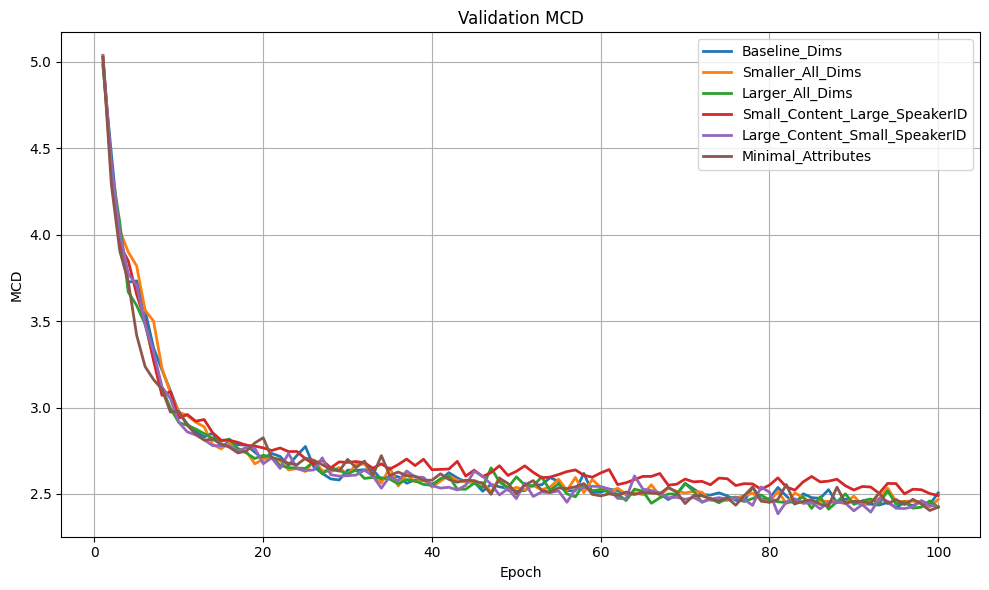

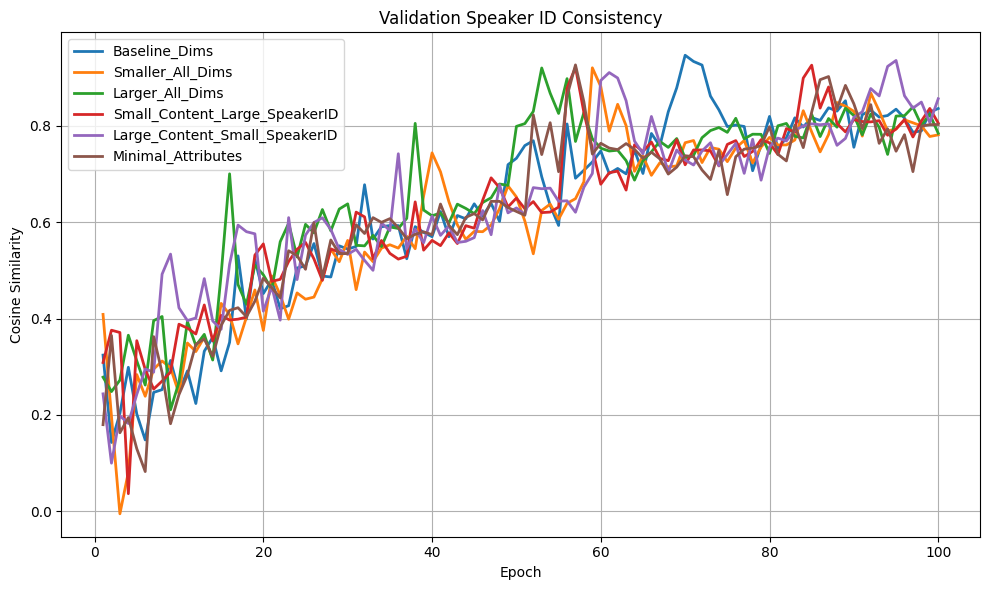

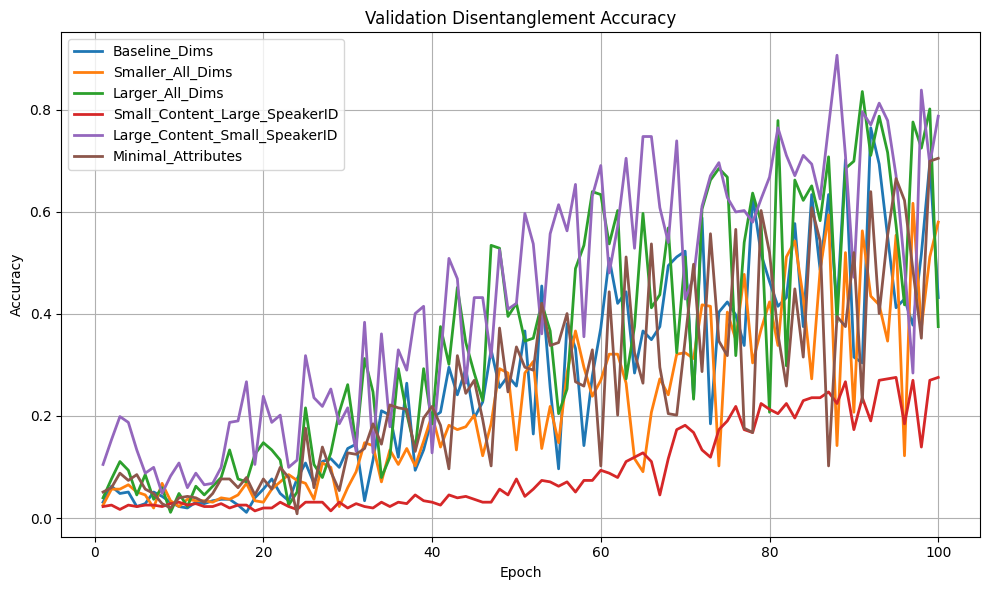

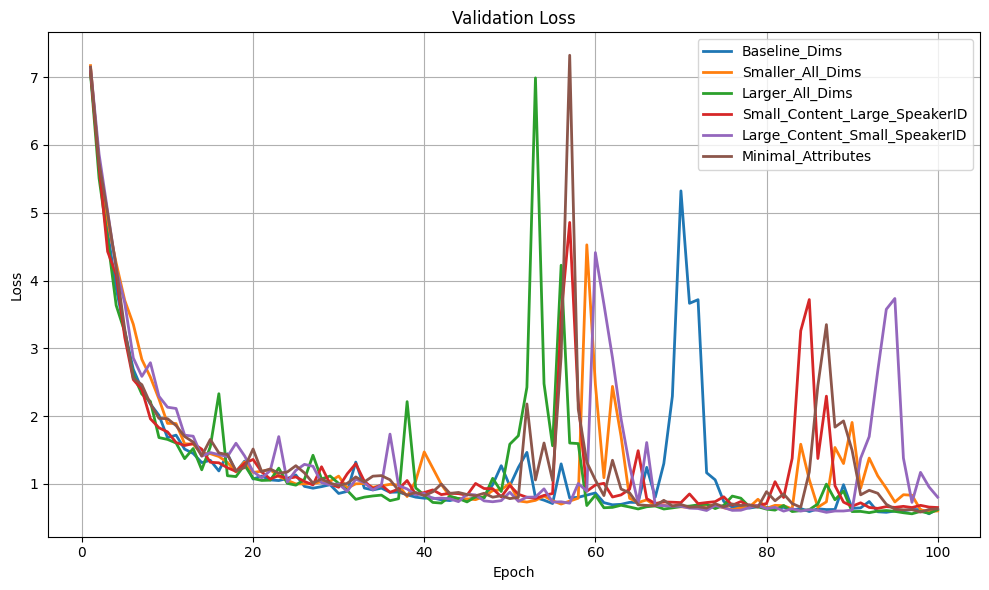

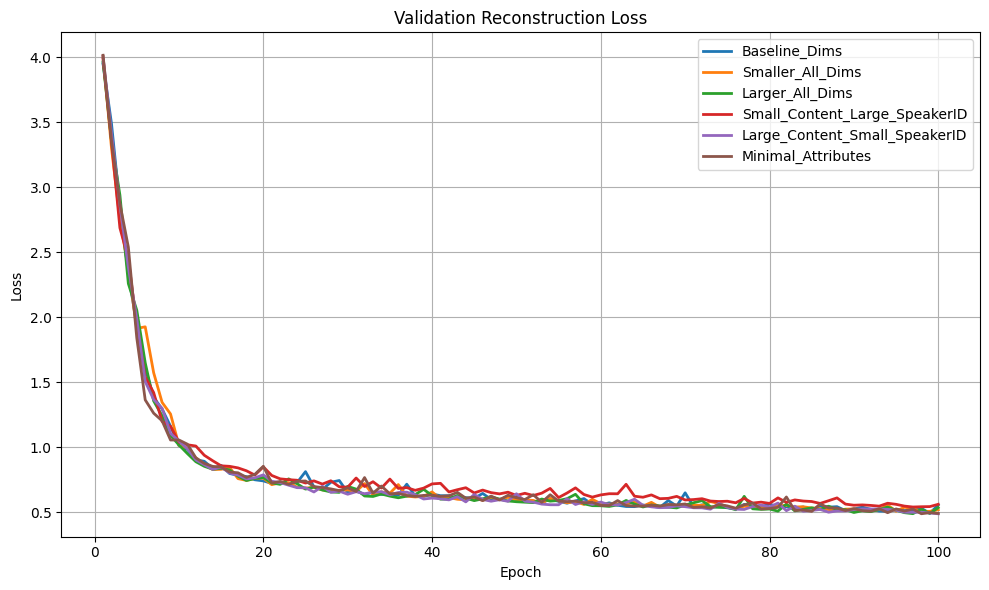

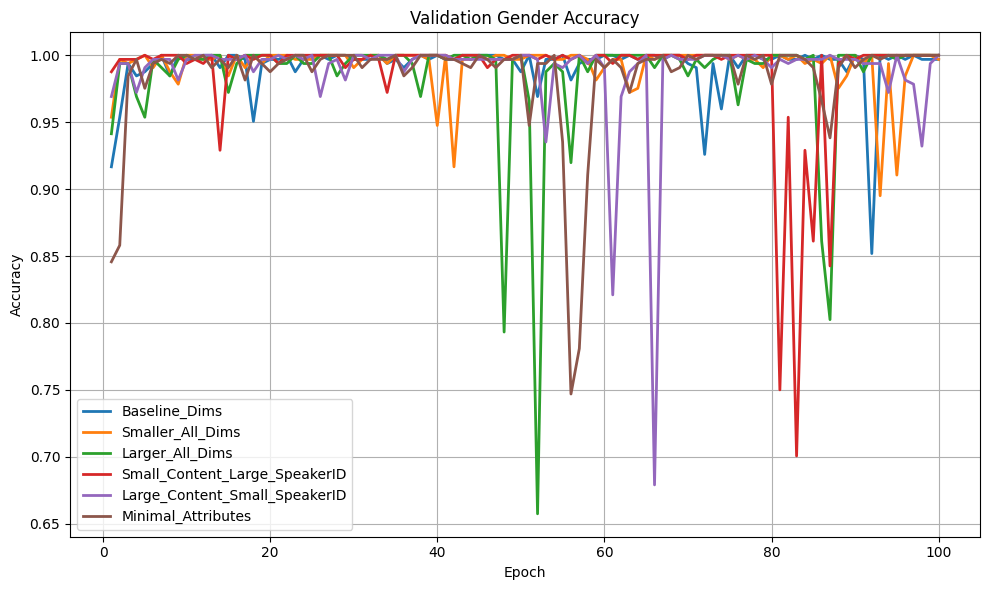

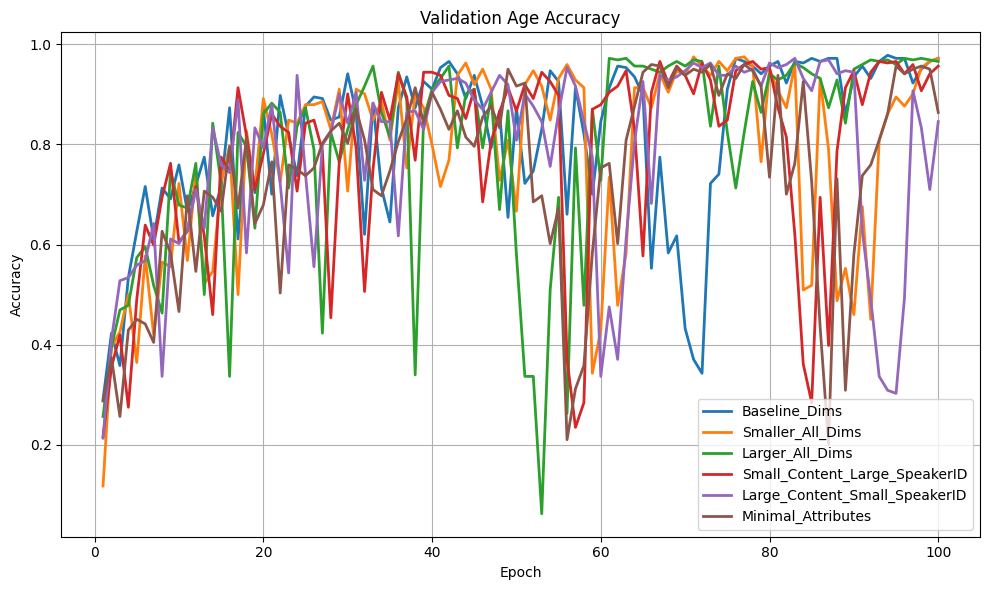

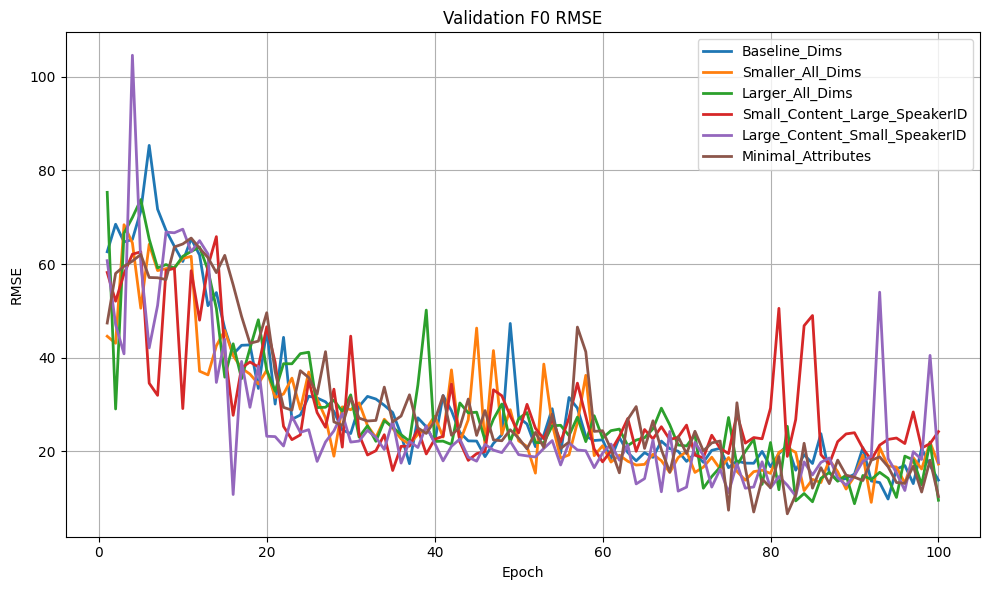

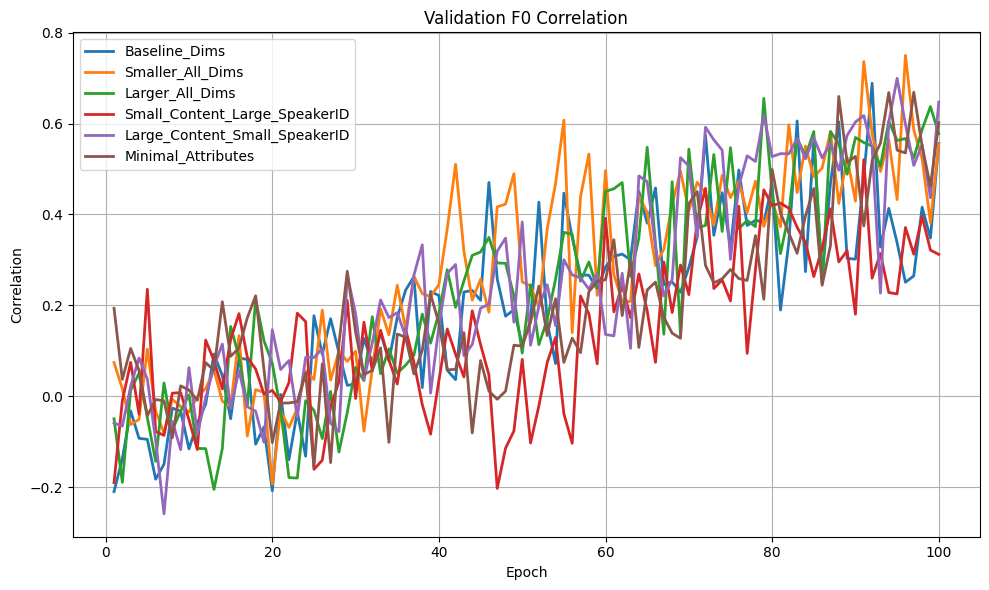

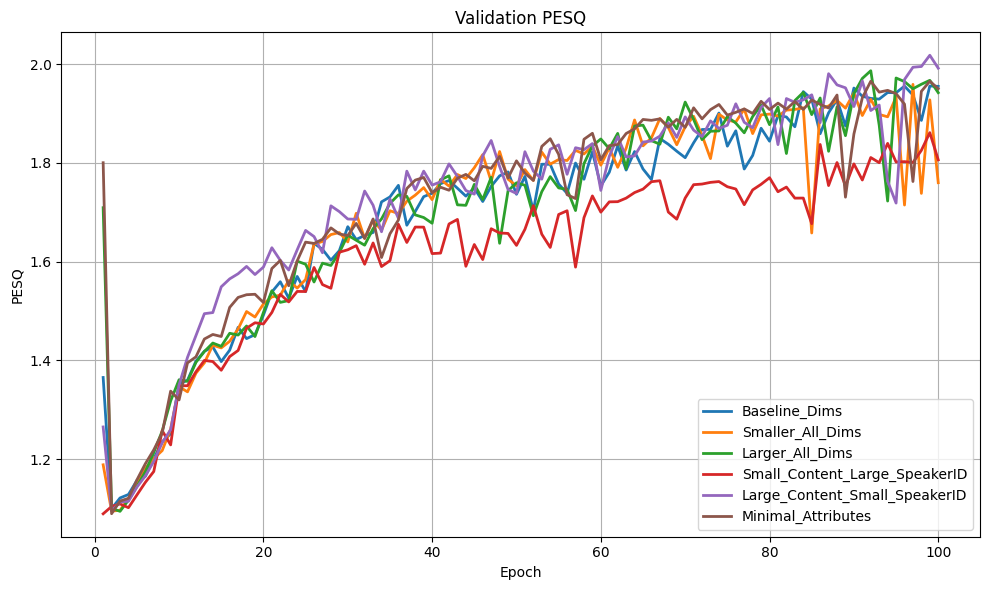

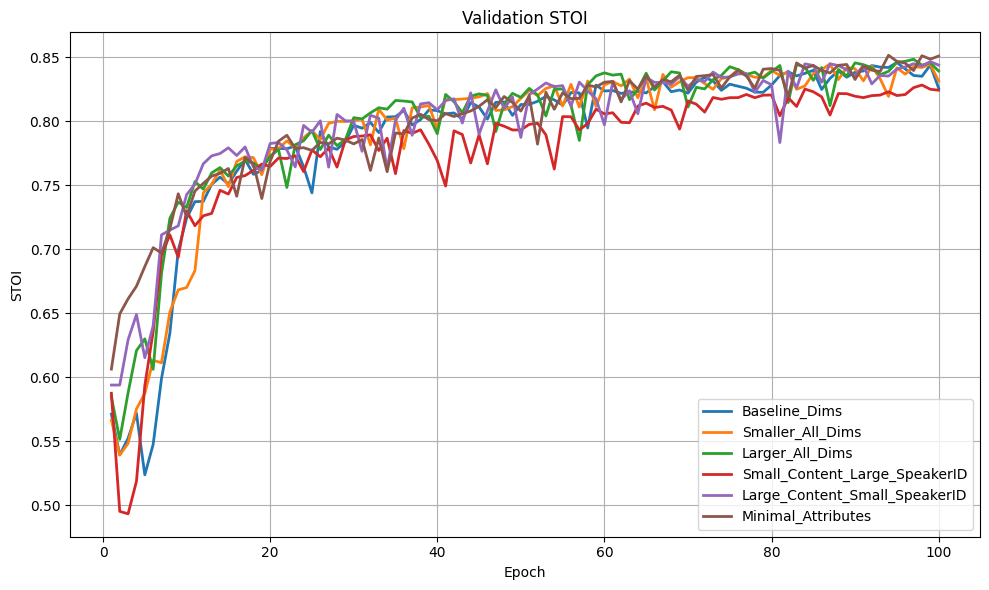

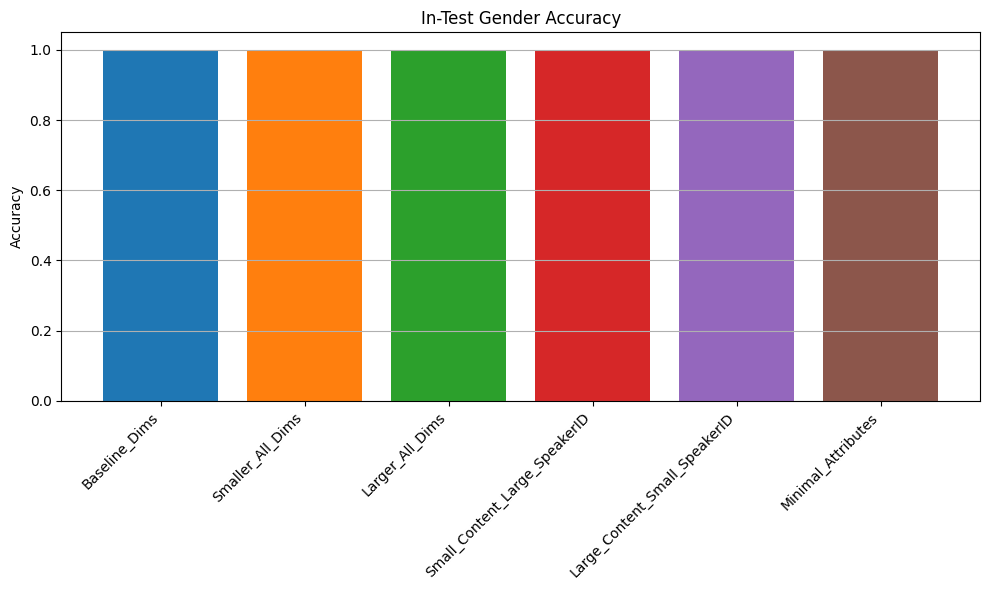

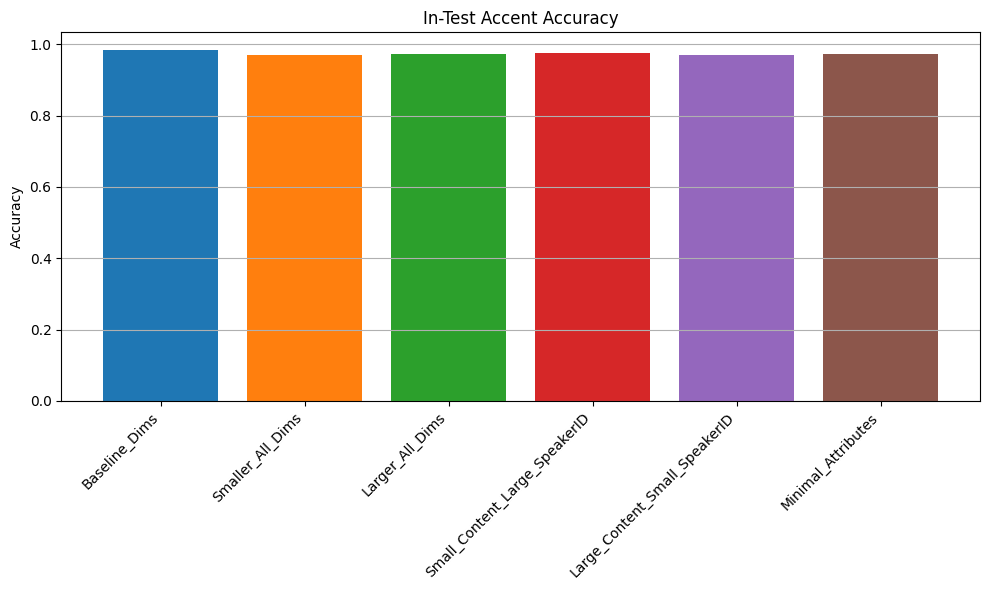

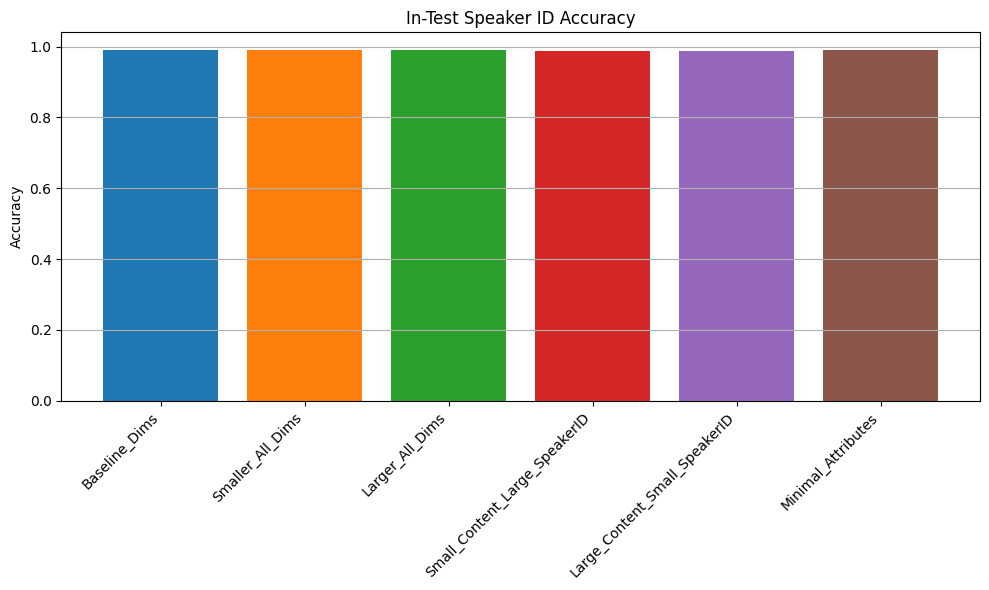

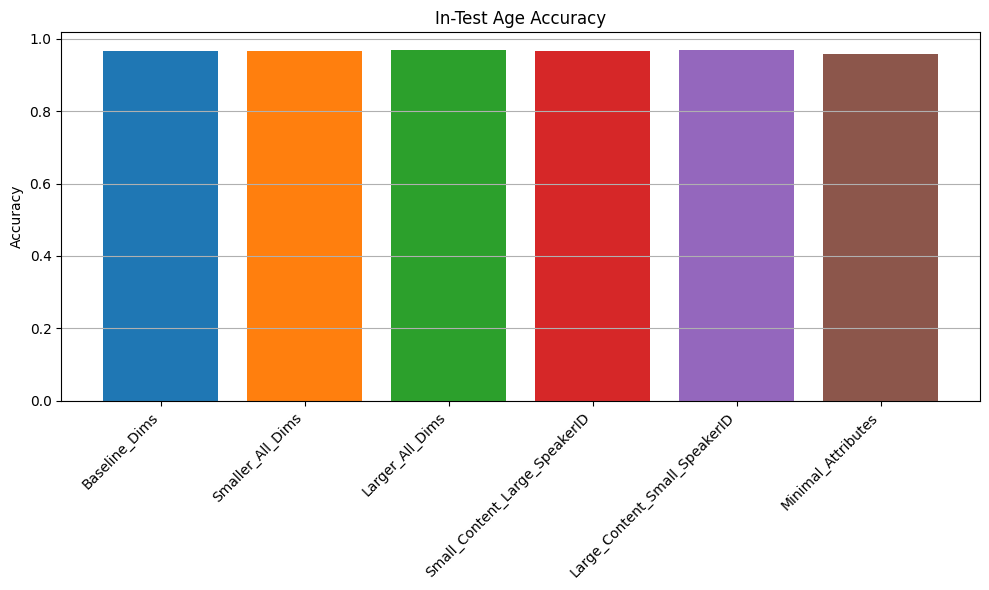

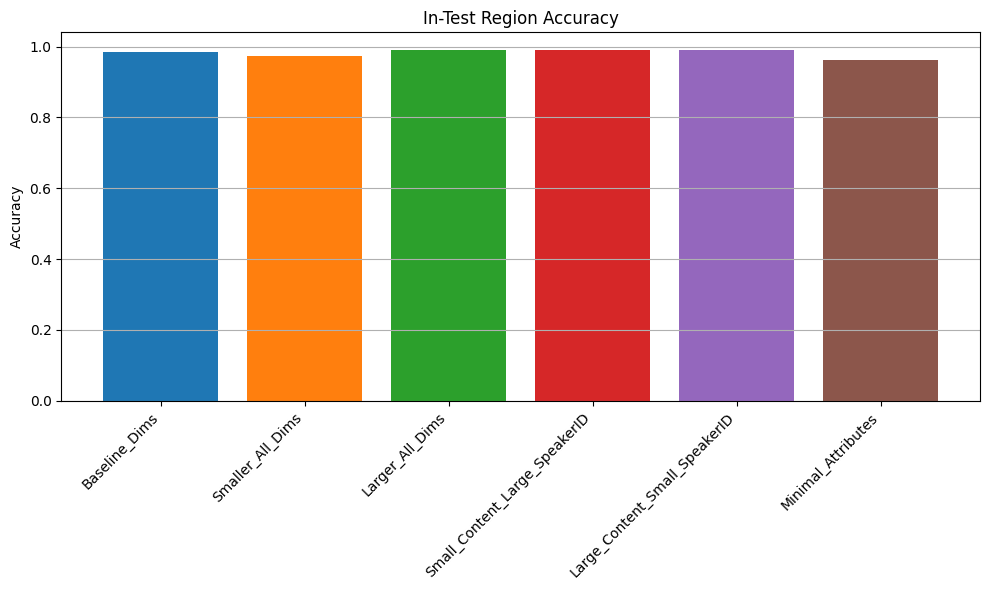

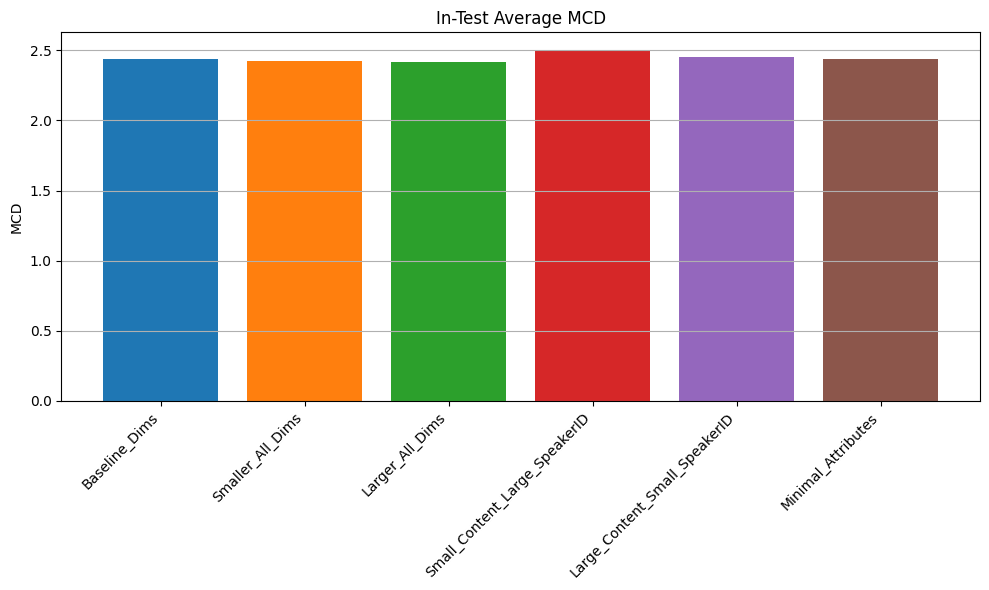

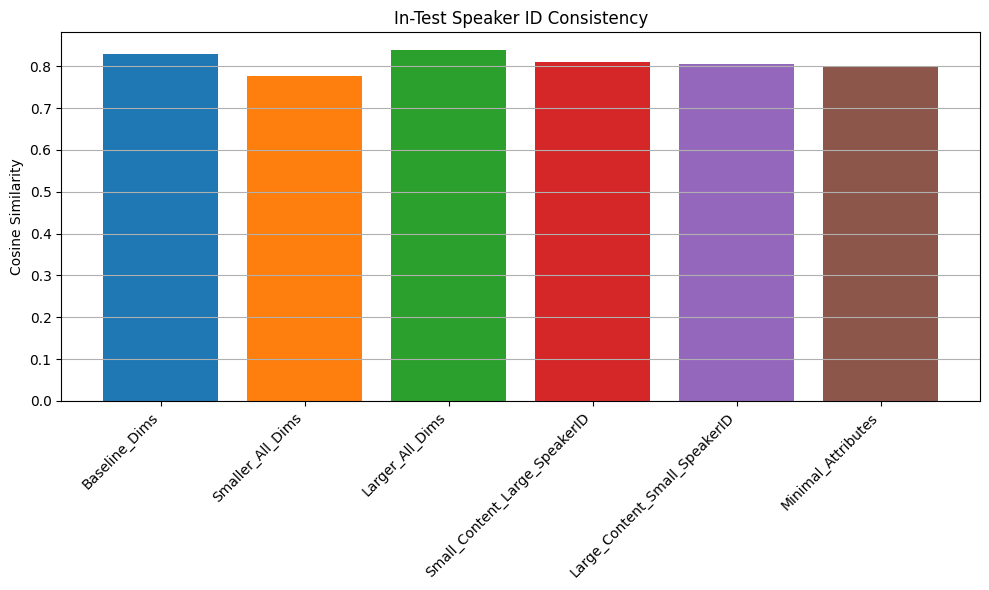

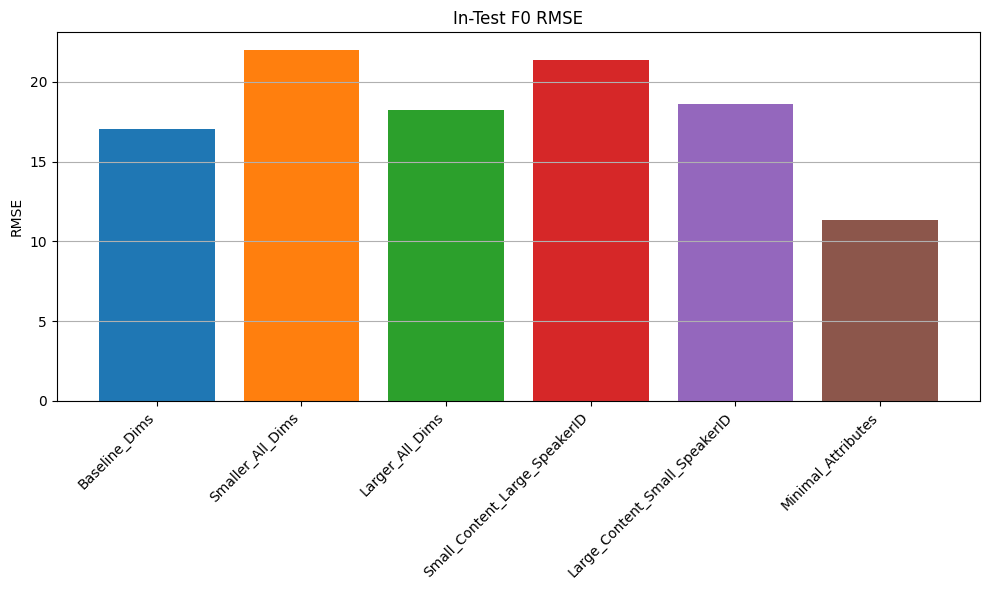

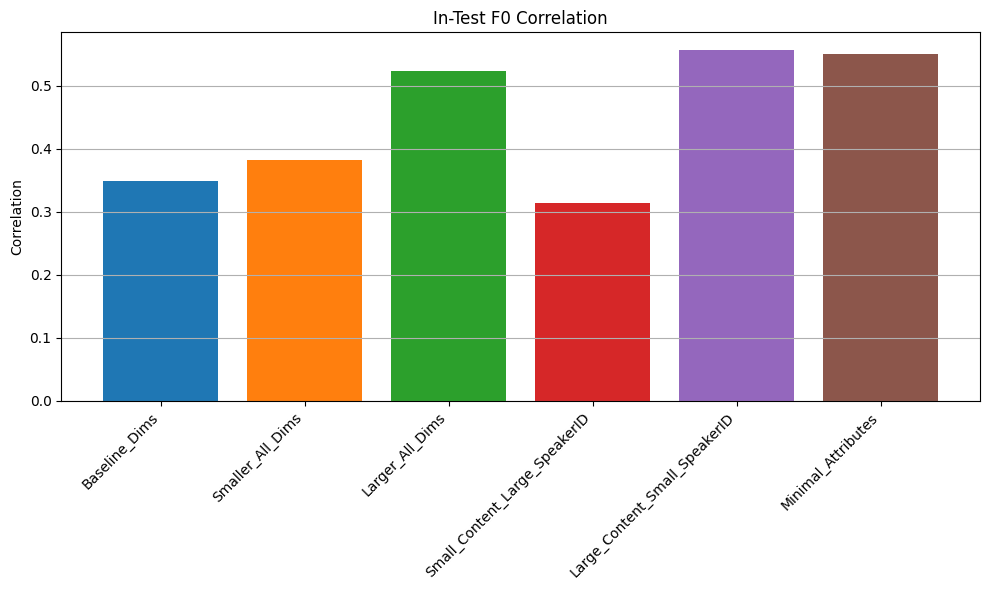

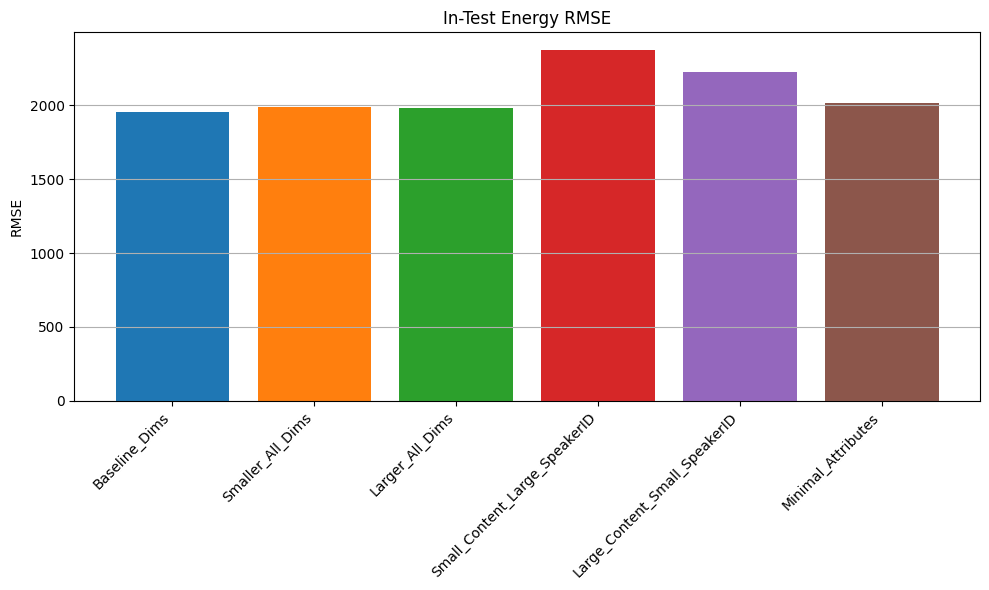

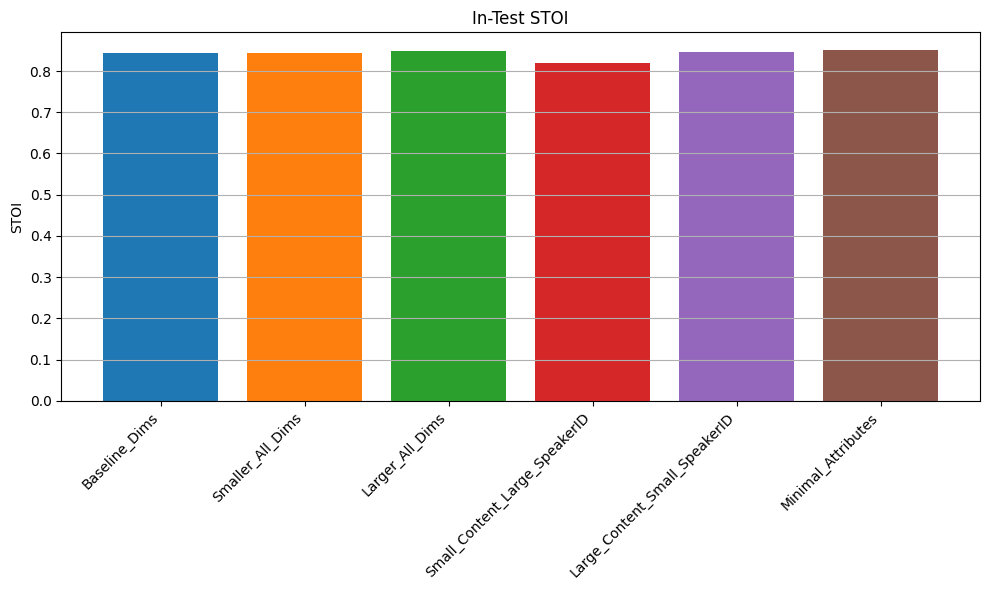

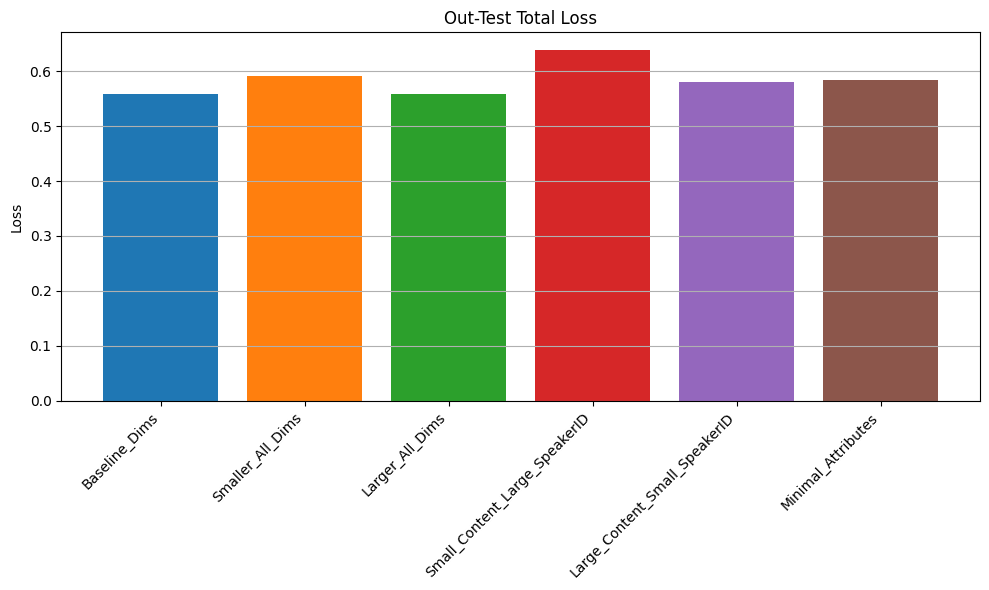

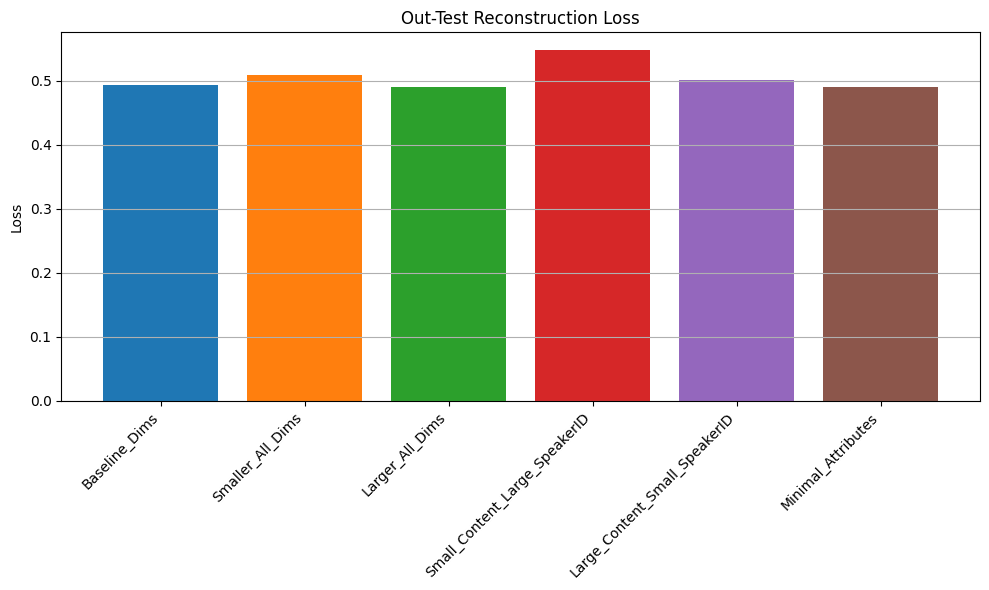

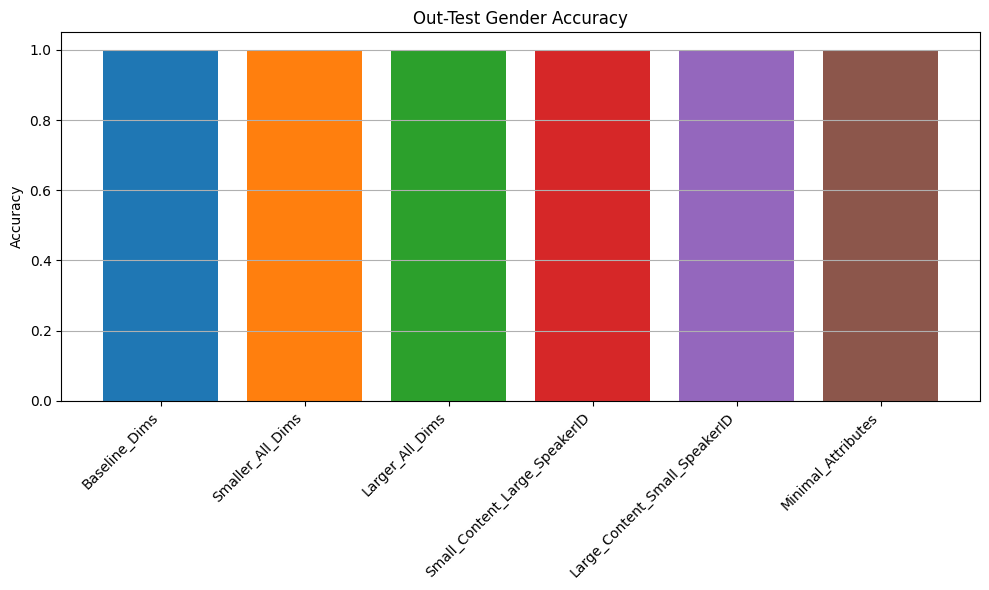

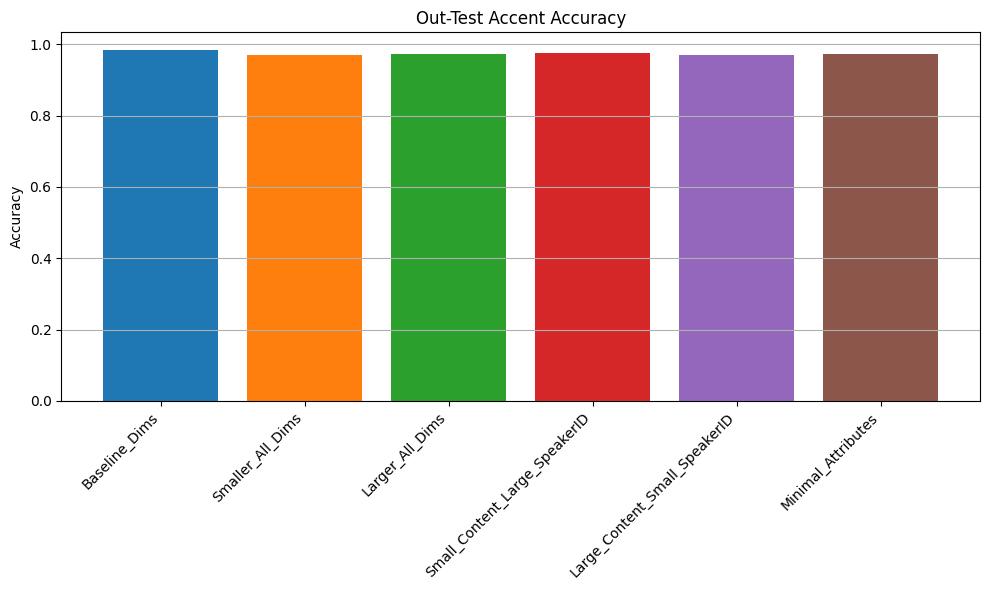

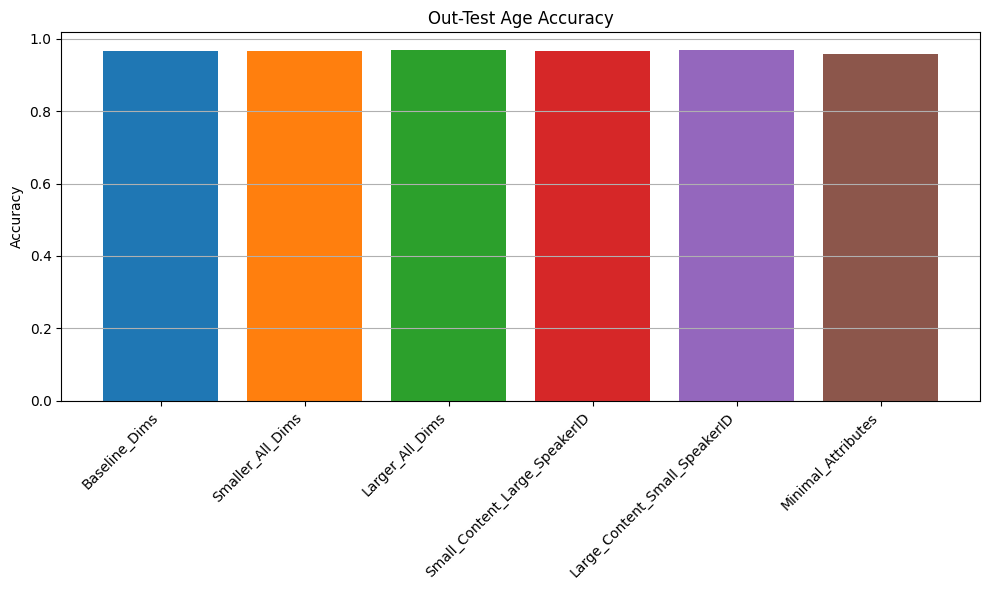

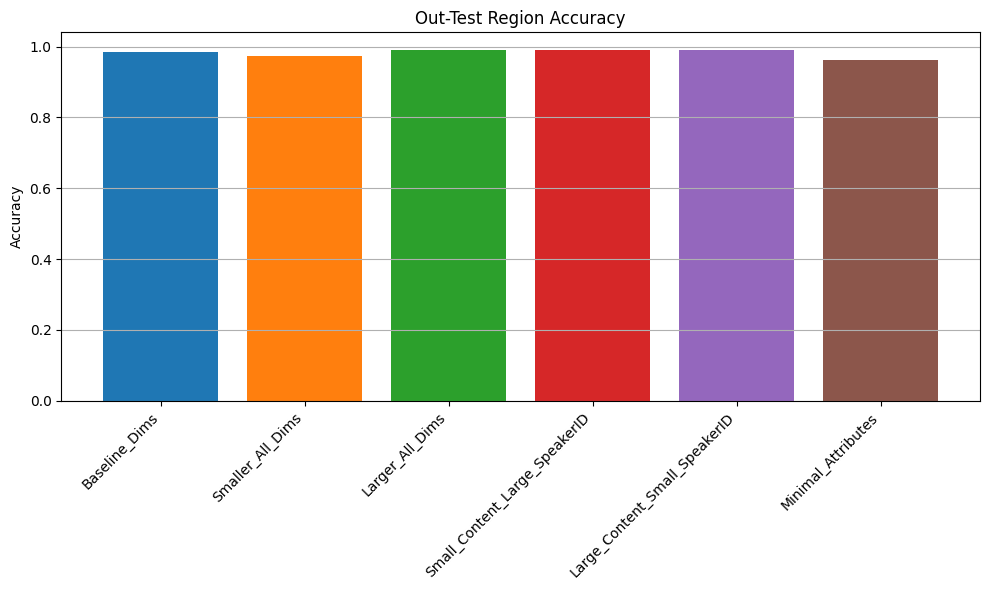

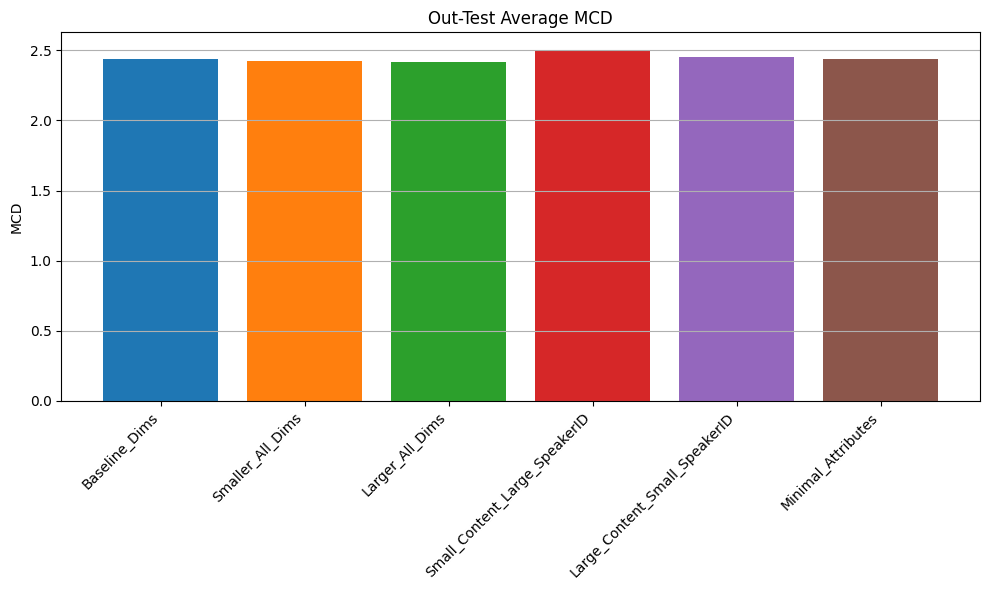

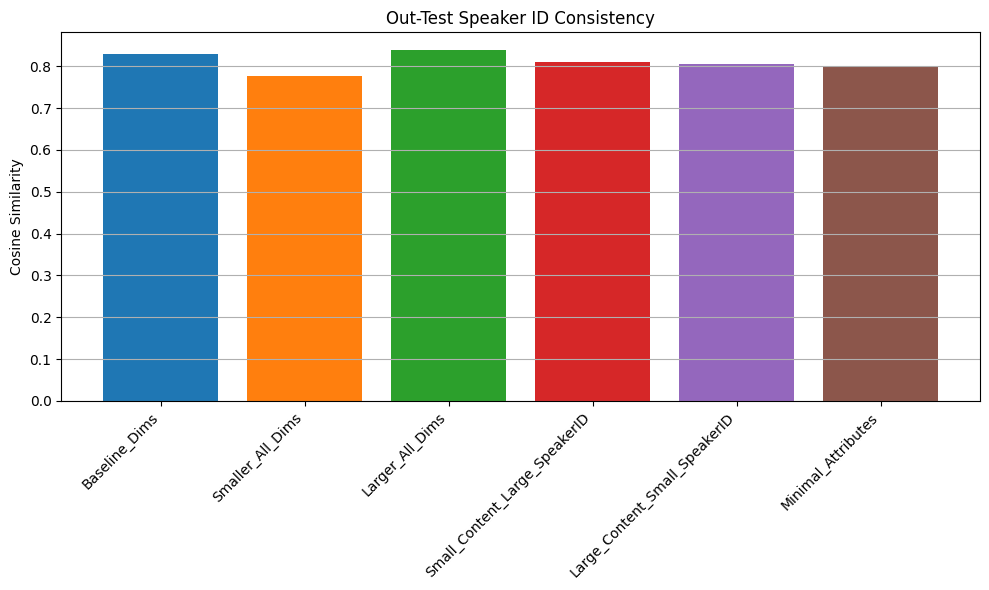

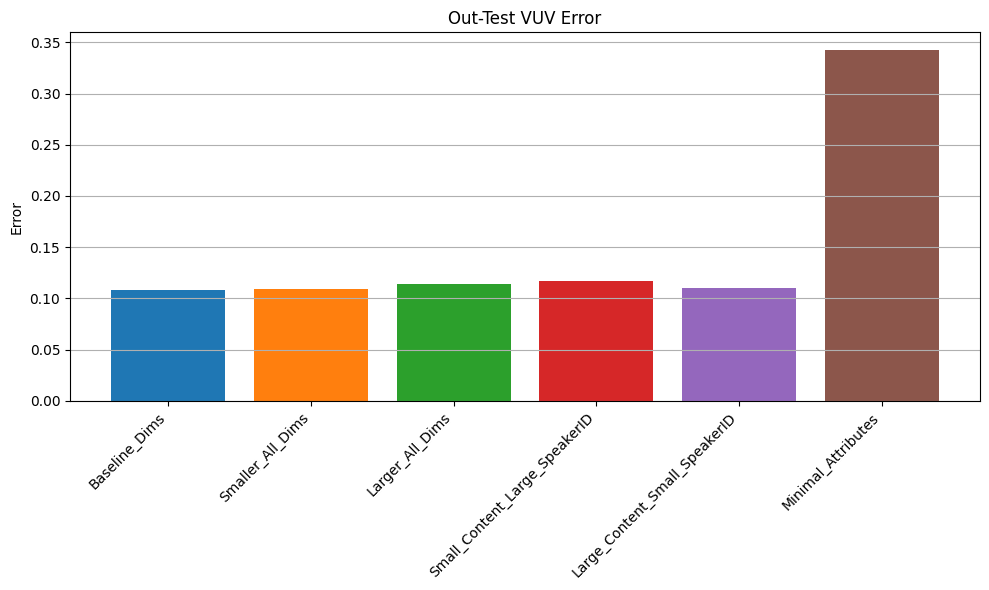

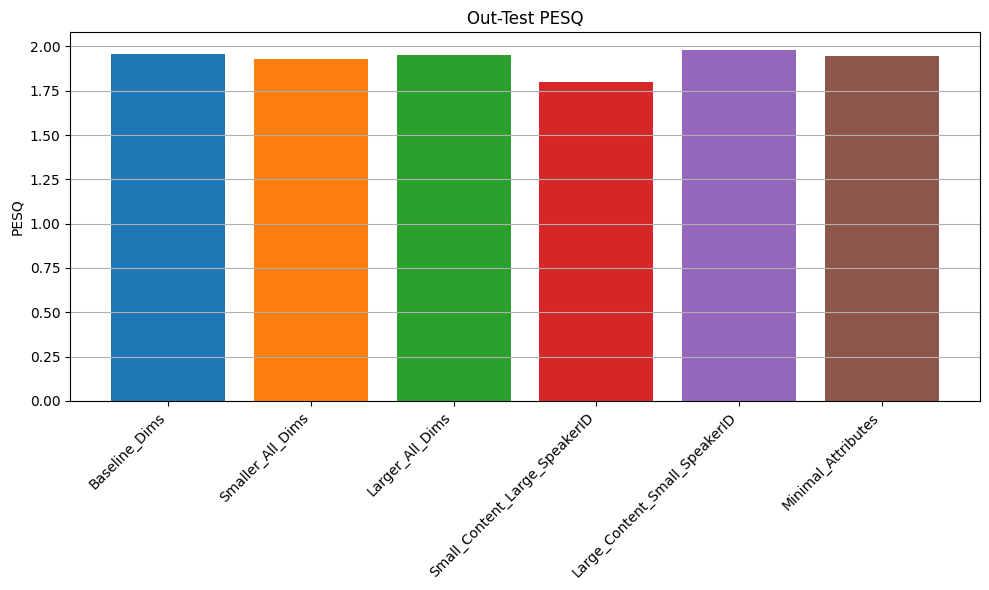

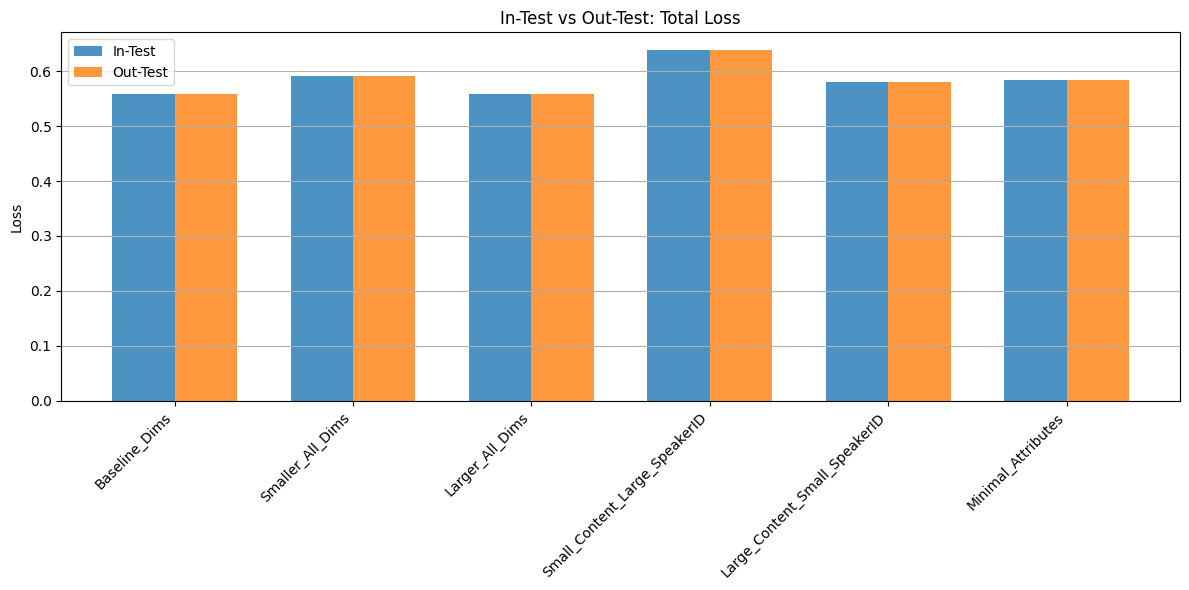

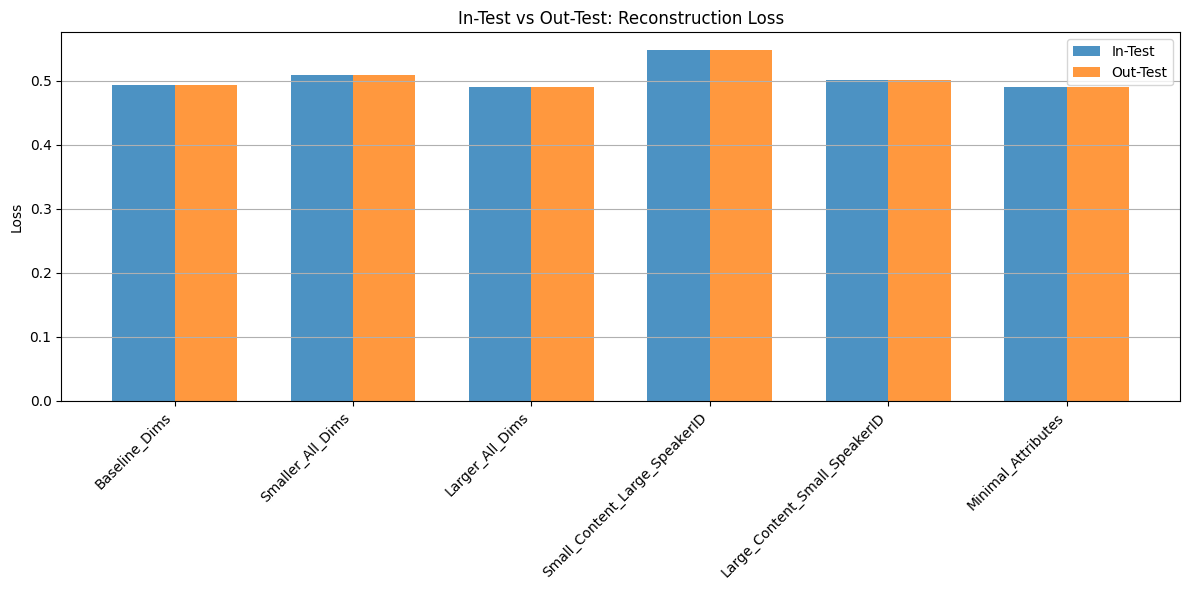

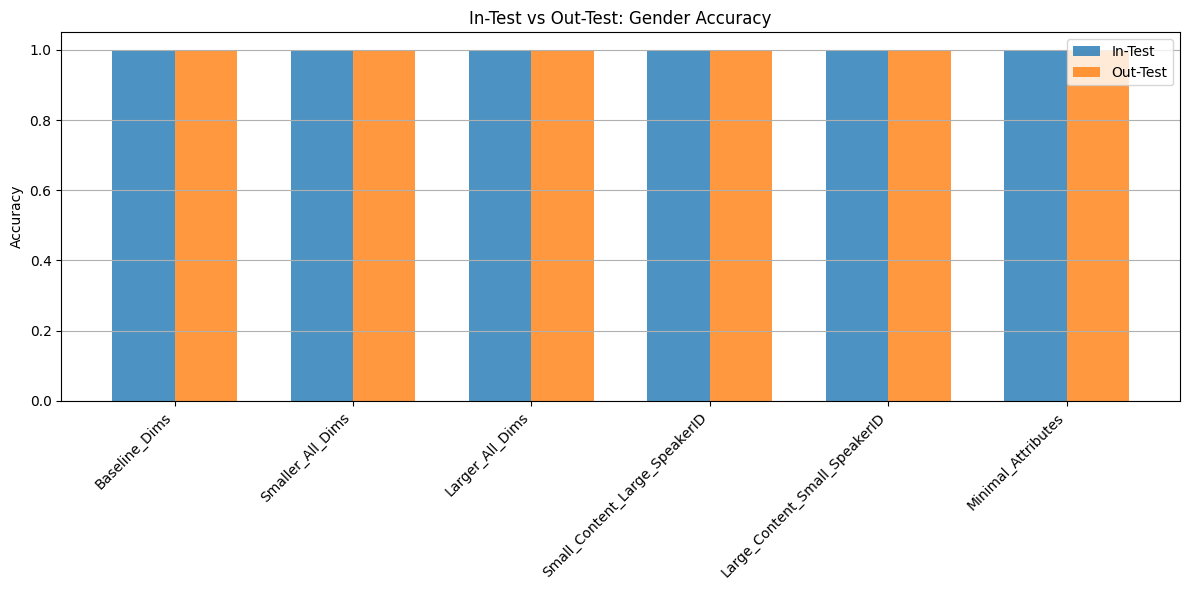

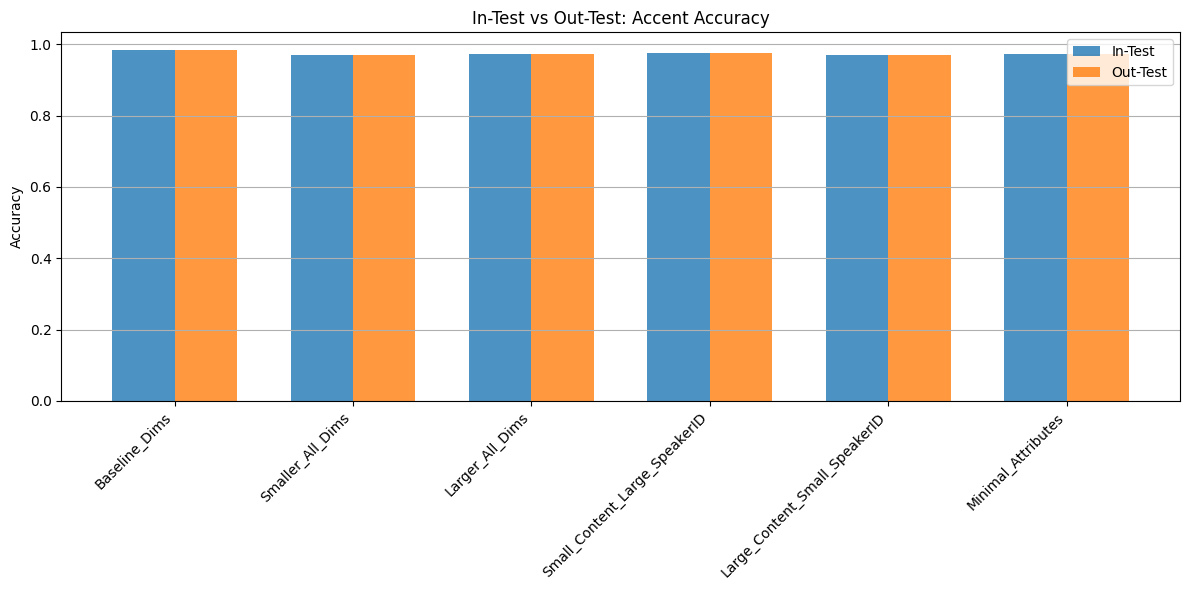

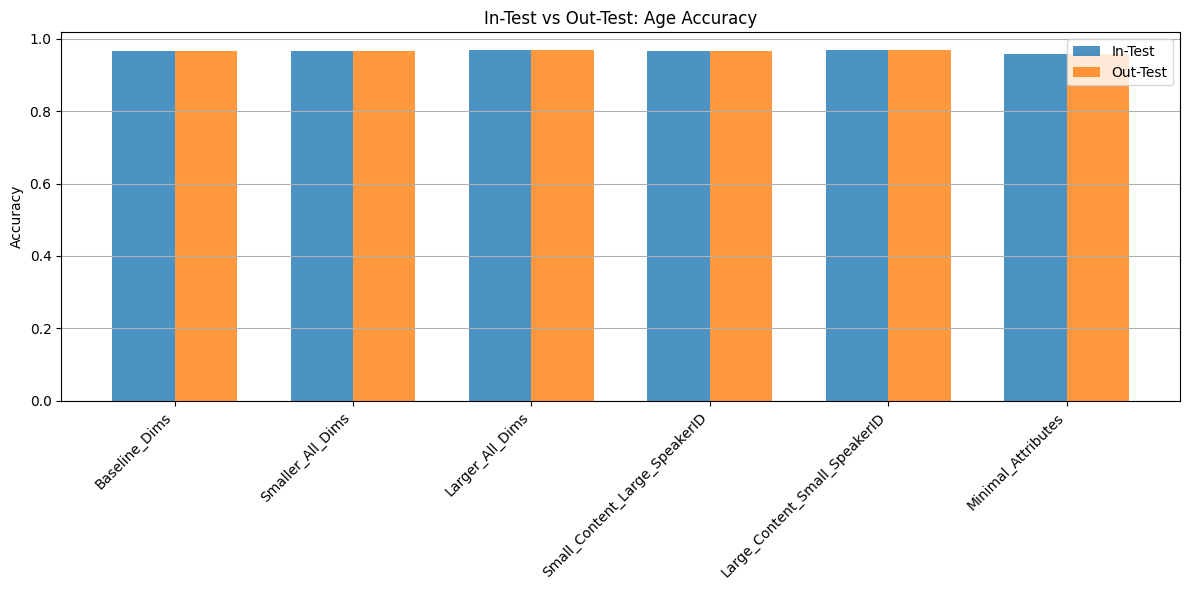

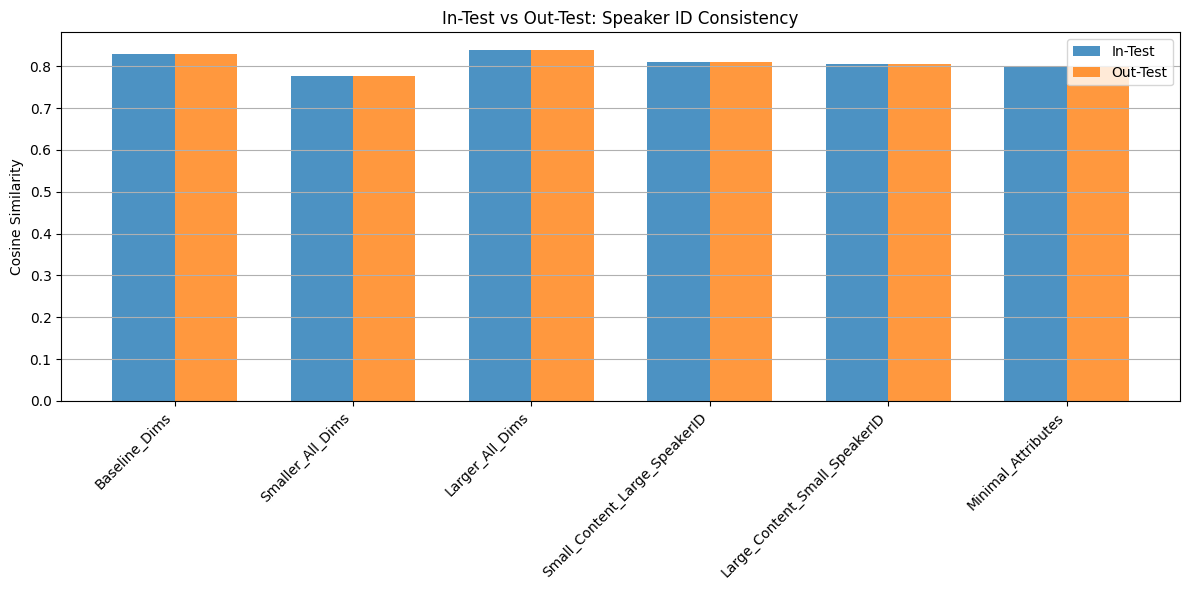

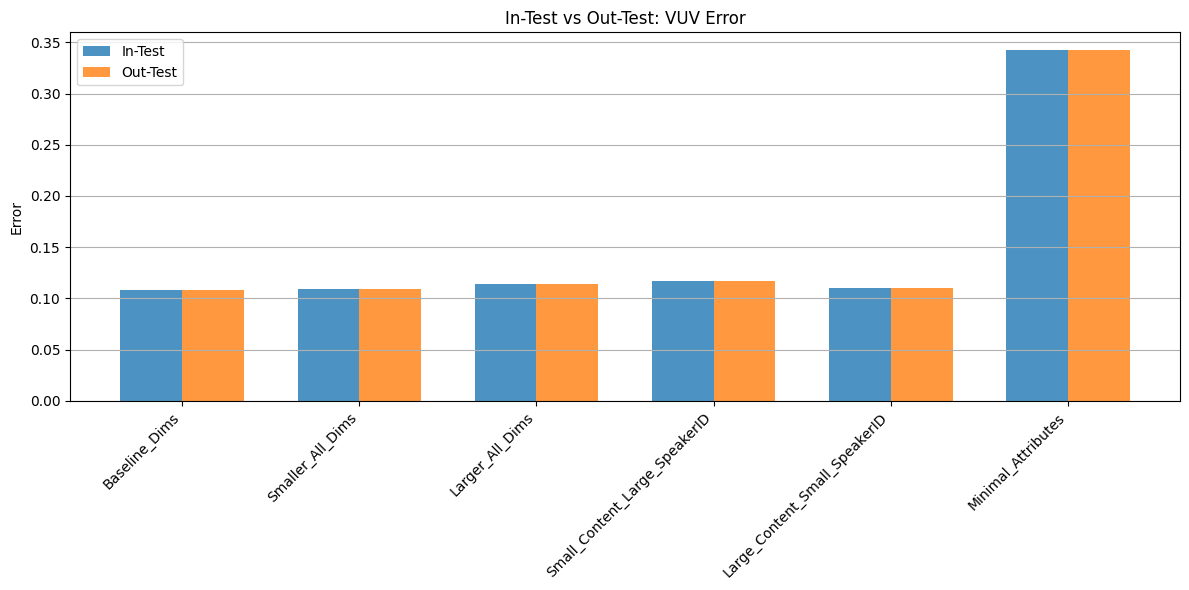

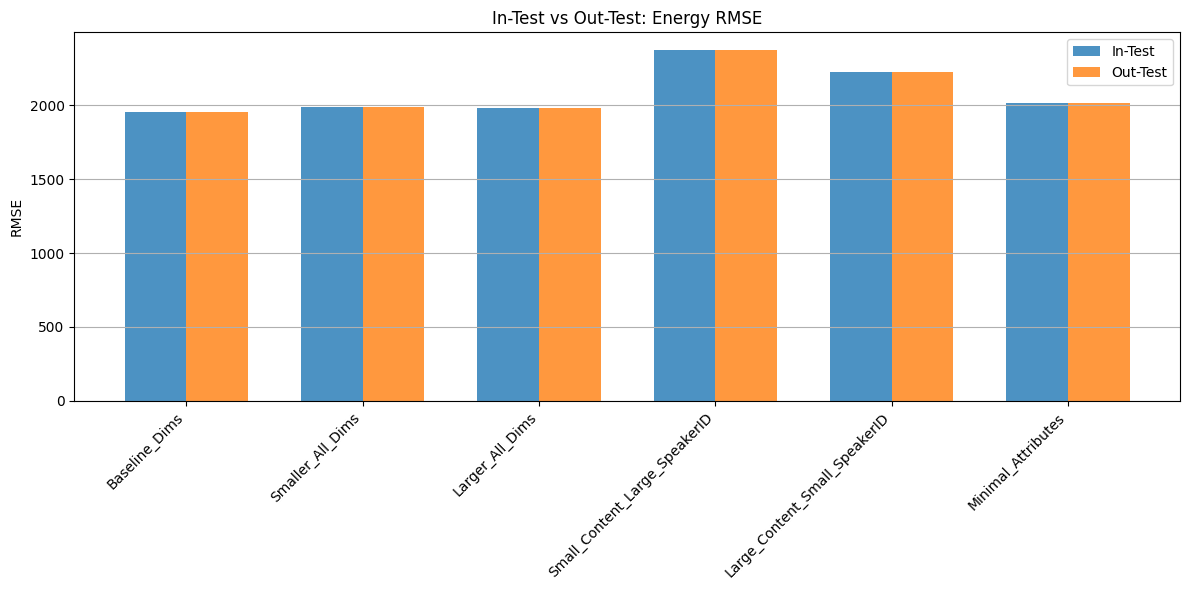

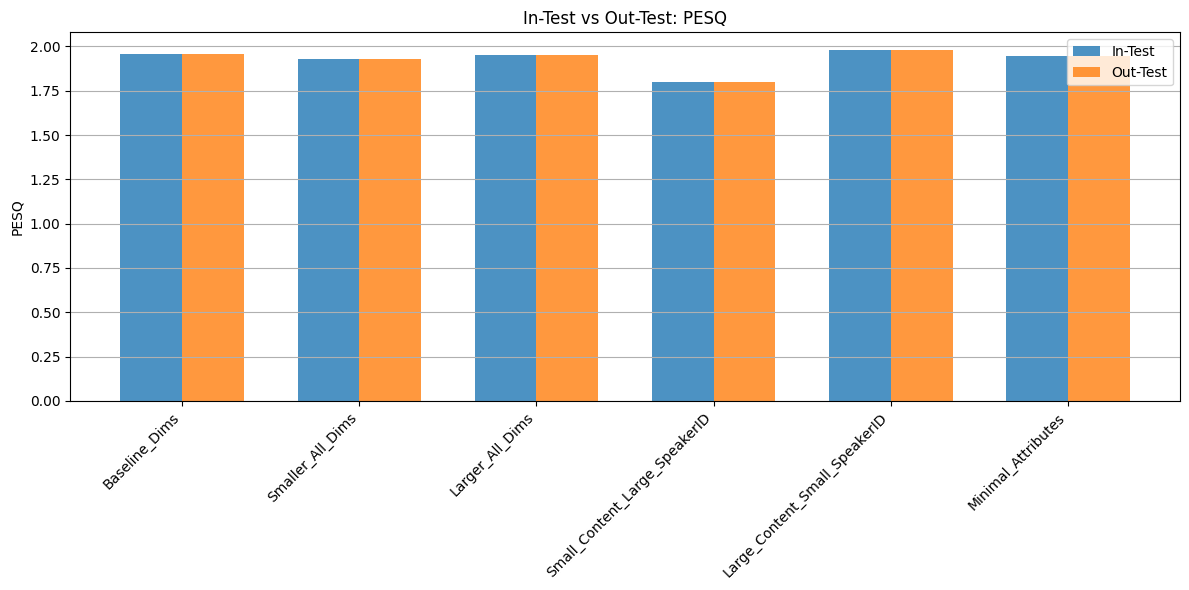

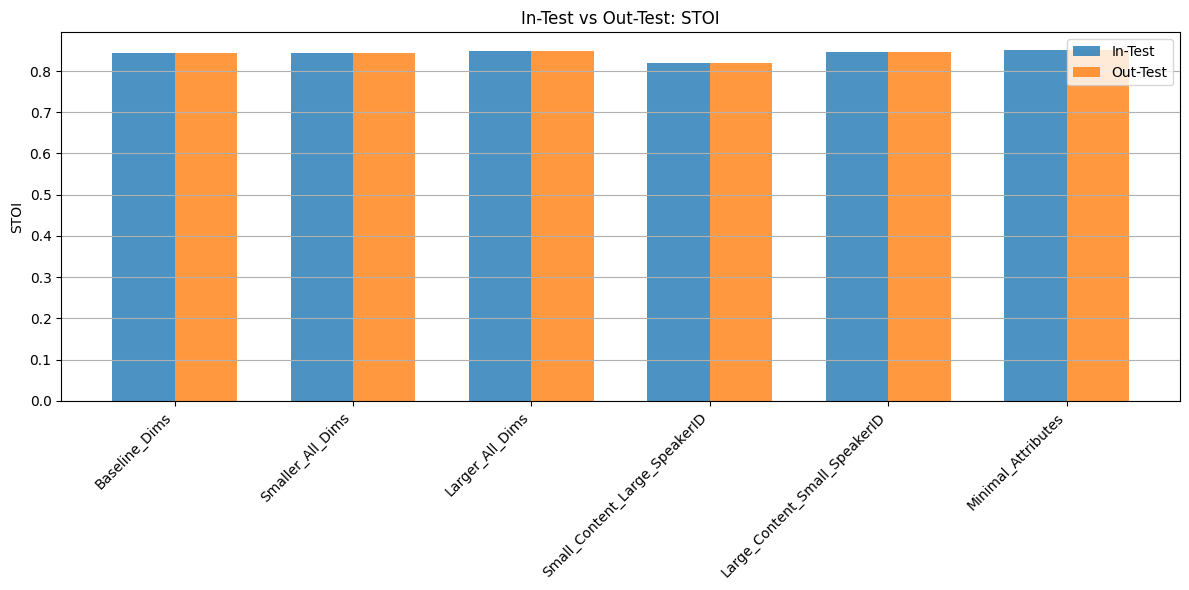

In [ ]:
import matplotlib.pyplot as plt
import json
import os
import numpy as np

Config.VC_Output = "/content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2"
results_dir = os.path.join(Config.VC_Output, "experiment_results")

# Load all experiment data
all_data = []
exp_names = []
for filename in os.listdir(results_dir):
    if filename.endswith(".json"):
        filepath = os.path.join(results_dir, filename)
        with open(filepath, 'r') as f:
            data = json.load(f)
            all_data.append(data)
            exp_names.append(data["experiment_config"]["name"])

# Define a color palette for different experiments
colors = plt.cm.tab10.colors

# 1. Validation Metrics - Individual Plots
val_metrics = [
    ("val_average_mcds", "Validation MCD", "MCD"),
    ("val_average_speaker_id_consistencys", "Validation Speaker ID Consistency", "Cosine Similarity"),
    ("val_disentanglement_accuracys", "Validation Disentanglement Accuracy", "Accuracy"),
    ("losses", "Validation Loss", "Loss"),
    ("reco_losses", "Validation Reconstruction Loss", "Loss"),
    ("gender_accs", "Validation Gender Accuracy", "Accuracy"),
    ("accent_accs", "Validation Accent Accuracy", "Accuracy"),
    ("speaker_id_accs", "Validation Speaker ID Accuracy", "Accuracy"),
    ("age_accs", "Validation Age Accuracy", "Accuracy"),
    ("region_accs", "Validation Region Accuracy", "Accuracy"),
    ("val_f0_rmses", "Validation F0 RMSE", "RMSE"),
    ("val_f0_correlations", "Validation F0 Correlation", "Correlation"),
    ("val_vuv_errors", "Validation VUV Error", "Error"),
    ("val_energy_rmses", "Validation Energy RMSE", "RMSE"),
    ("val_pesq_summarys", "Validation PESQ", "PESQ"),
    ("val_stoi_summarys", "Validation STOI", "STOI")
]

for metric_key, title, ylabel in val_metrics:
    plt.figure(figsize=(10, 6))

    for j, data in enumerate(all_data):
        exp_name = data["experiment_config"]["name"]

        if metric_key in ["losses", "reco_losses", "gender_accs", "accent_accs",
                         "speaker_id_accs", "age_accs", "region_accs",
                         "val_f0_rmses", "val_f0_correlations", "val_vuv_errors",
                         "val_energy_rmses", "val_pesq_summarys", "val_stoi_summarys"]:
            values = data["validation_metrics"][metric_key]
        else:
            values = data[metric_key]

        epochs = range(1, len(values) + 1)
        plt.plot(epochs, values, label=exp_name, color=colors[j % len(colors)], linewidth=2)

    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{metric_key}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 2. In-Test Metrics - Bar Charts
in_test_metrics = [
    ("total_loss", "In-Test Total Loss", "Loss"),
    ("reco_loss", "In-Test Reconstruction Loss", "Loss"),
    ("gender_acc", "In-Test Gender Accuracy", "Accuracy"),
    ("accent_acc", "In-Test Accent Accuracy", "Accuracy"),
    ("speaker_id_acc", "In-Test Speaker ID Accuracy", "Accuracy"),
    ("age_acc", "In-Test Age Accuracy", "Accuracy"),
    ("region_acc", "In-Test Region Accuracy", "Accuracy"),
    ("average_mcd", "In-Test Average MCD", "MCD"),
    ("speaker_id_consistency", "In-Test Speaker ID Consistency", "Cosine Similarity"),
    ("disentanglement_accuracy", "In-Test Disentanglement Accuracy", "Accuracy"),
    ("in_test_f0_rmses", "In-Test F0 RMSE", "RMSE"),
    ("in_test_f0_correlations", "In-Test F0 Correlation", "Correlation"),
    ("in_test_vuv_errors", "In-Test VUV Error", "Error"),
    ("in_test_energy_rmses", "In-Test Energy RMSE", "RMSE"),
    ("in_test_pesq_summarys", "In-Test PESQ", "PESQ"),
    ("in_test_stoi_summarys", "In-Test STOI", "STOI")
]

# Prepare data for in-test metrics
in_test_values = {}
for metric_key, title, ylabel in in_test_metrics:
    in_test_values[metric_key] = [data["in_test_metrics"][metric_key] for data in all_data]

# Create bar charts for in-test metrics
for metric_key, title, ylabel in in_test_metrics:
    plt.figure(figsize=(10, 6))

    x = np.arange(len(exp_names))
    plt.bar(x, in_test_values[metric_key], color=colors[:len(exp_names)])

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(x, exp_names, rotation=45, ha='right')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"in_test_{metric_key}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 3. Out-Test Metrics - Bar Charts
out_test_metrics = [
    ("total_loss", "Out-Test Total Loss", "Loss"),
    ("reco_loss", "Out-Test Reconstruction Loss", "Loss"),
    ("gender_acc", "Out-Test Gender Accuracy", "Accuracy"),
    ("accent_acc", "Out-Test Accent Accuracy", "Accuracy"),
    ("speaker_id_acc", "Out-Test Speaker ID Accuracy", "Accuracy"),
    ("age_acc", "Out-Test Age Accuracy", "Accuracy"),
    ("region_acc", "Out-Test Region Accuracy", "Accuracy"),
    ("average_mcd", "Out-Test Average MCD", "MCD"),
    ("speaker_id_consistency", "Out-Test Speaker ID Consistency", "Cosine Similarity"),
    ("disentanglement_accuracy", "Out-Test Disentanglement Accuracy", "Accuracy"),
    ("out_test_f0_rmses", "Out-Test F0 RMSE", "RMSE"),
    ("out_test_f0_correlations", "Out-Test F0 Correlation", "Correlation"),
    ("out_test_vuv_errors", "Out-Test VUV Error", "Error"),
    ("out_test_energy_rmses", "Out-Test Energy RMSE", "RMSE"),
    ("out_test_pesq_summarys", "Out-Test PESQ", "PESQ"),
    ("out_test_stoi_summarys", "Out-Test STOI", "STOI")
]

# Prepare data for out-test metrics
out_test_values = {}
for metric_key, title, ylabel in out_test_metrics:
    out_test_values[metric_key] = [data["out_test_metrics"][metric_key] for data in all_data]

# Create bar charts for out-test metrics
for metric_key, title, ylabel in out_test_metrics:
    plt.figure(figsize=(10, 6))

    x = np.arange(len(exp_names))
    plt.bar(x, out_test_values[metric_key], color=colors[:len(exp_names)])

    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(x, exp_names, rotation=45, ha='right')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"out_test_{metric_key}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 4. Comparison Plots: In-Test vs Out-Test for Each Metric
comparison_metrics = [
    ("total_loss", "Total Loss", "Loss"),
    ("reco_loss", "Reconstruction Loss", "Loss"),
    ("gender_acc", "Gender Accuracy", "Accuracy"),
    ("accent_acc", "Accent Accuracy", "Accuracy"),
    ("speaker_id_acc", "Speaker ID Accuracy", "Accuracy"),
    ("age_acc", "Age Accuracy", "Accuracy"),
    ("region_acc", "Region Accuracy", "Accuracy"),
    ("average_mcd", "Average MCD", "MCD"),
    ("speaker_id_consistency", "Speaker ID Consistency", "Cosine Similarity"),
    ("disentanglement_accuracy", "Disentanglement Accuracy", "Accuracy"),
    ("f0_rmses", "F0 RMSE", "RMSE"),
    ("f0_correlations", "F0 Correlation", "Correlation"),
    ("vuv_errors", "VUV Error", "Error"),
    ("energy_rmses", "Energy RMSE", "RMSE"),
    ("pesq_summarys", "PESQ", "PESQ"),
    ("stoi_summarys", "STOI", "STOI")
]

# Create comparison plots
for metric_base, title, ylabel in comparison_metrics:
    plt.figure(figsize=(12, 6))

    # Get the metric keys
    in_metric_key = f"in_test_{metric_base}" if metric_base not in ["total_loss", "reco_loss", "gender_acc", "accent_acc",
                                                                   "speaker_id_acc", "age_acc", "region_acc",
                                                                   "average_mcd", "speaker_id_consistency", "disentanglement_accuracy"] else metric_base

    out_metric_key = f"out_test_{metric_base}" if metric_base not in ["total_loss", "reco_loss", "gender_acc", "accent_acc",
                                                                     "speaker_id_acc", "age_acc", "region_acc",
                                                                     "average_mcd", "speaker_id_consistency", "disentanglement_accuracy"] else metric_base

    x = np.arange(len(exp_names))
    width = 0.35

    plt.bar(x - width/2, [data["in_test_metrics"][in_metric_key] for data in all_data],
            width, label='In-Test', alpha=0.8)
    plt.bar(x + width/2, [data["out_test_metrics"][out_metric_key] for data in all_data],
            width, label='Out-Test', alpha=0.8)

    plt.title(f"In-Test vs Out-Test: {title}")
    plt.ylabel(ylabel)
    plt.xticks(x, exp_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"comparison_{metric_base}.png", dpi=300, bbox_inches='tight')
    plt.show()

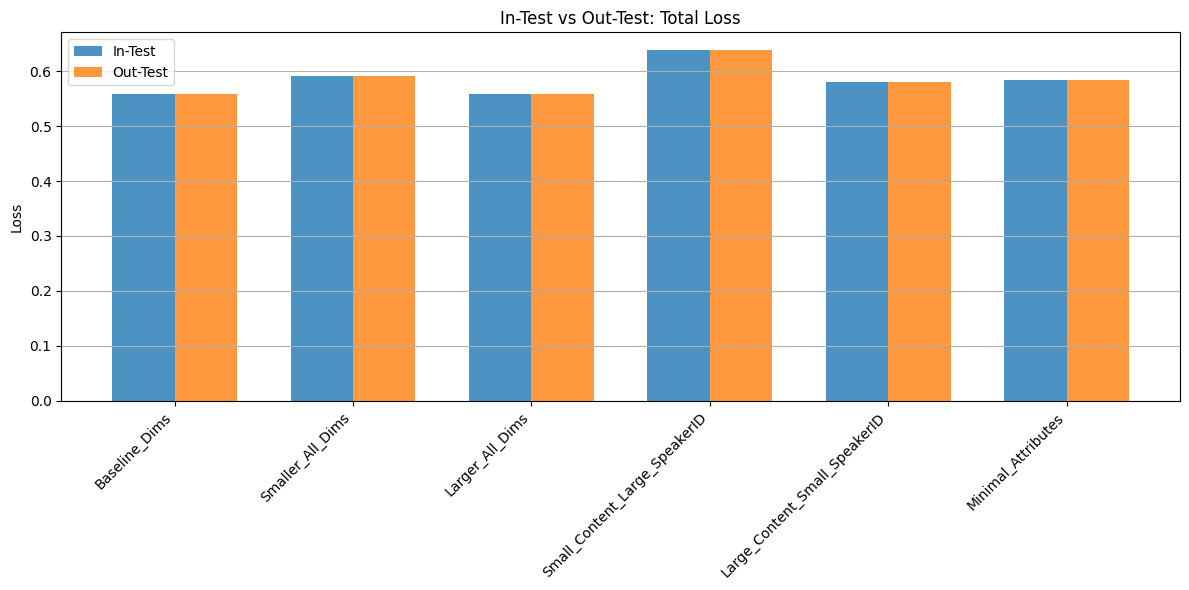

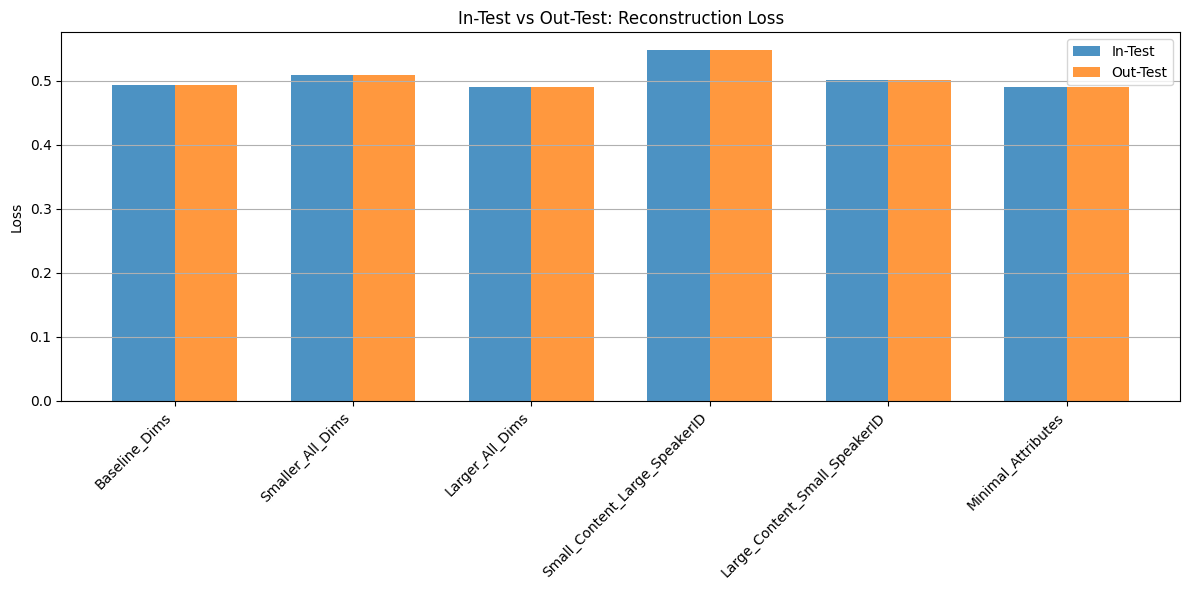

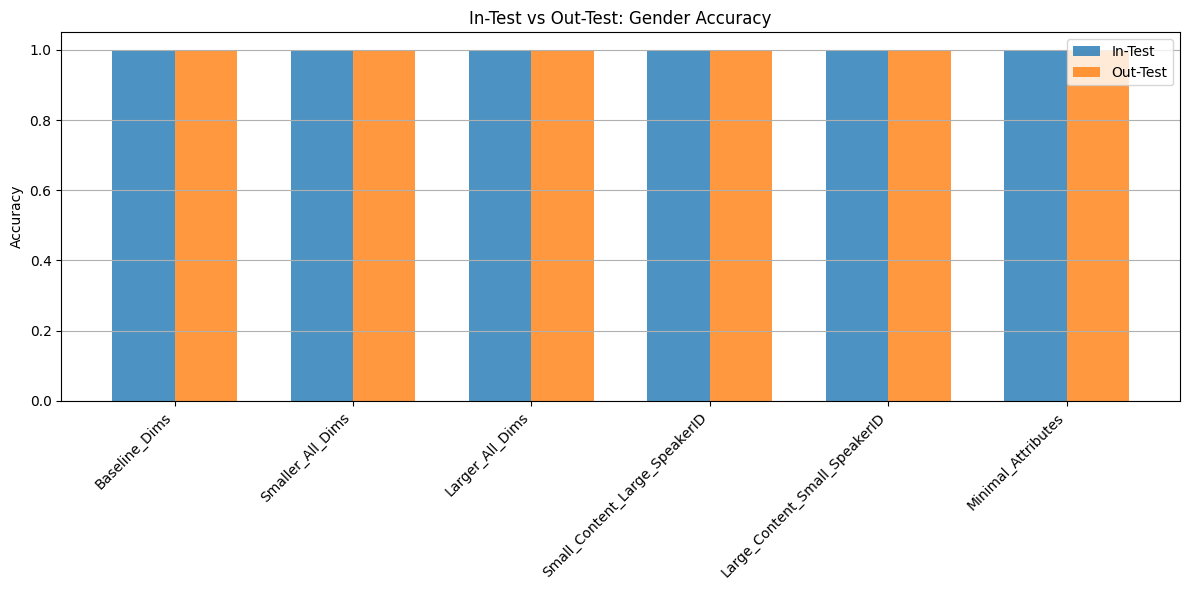

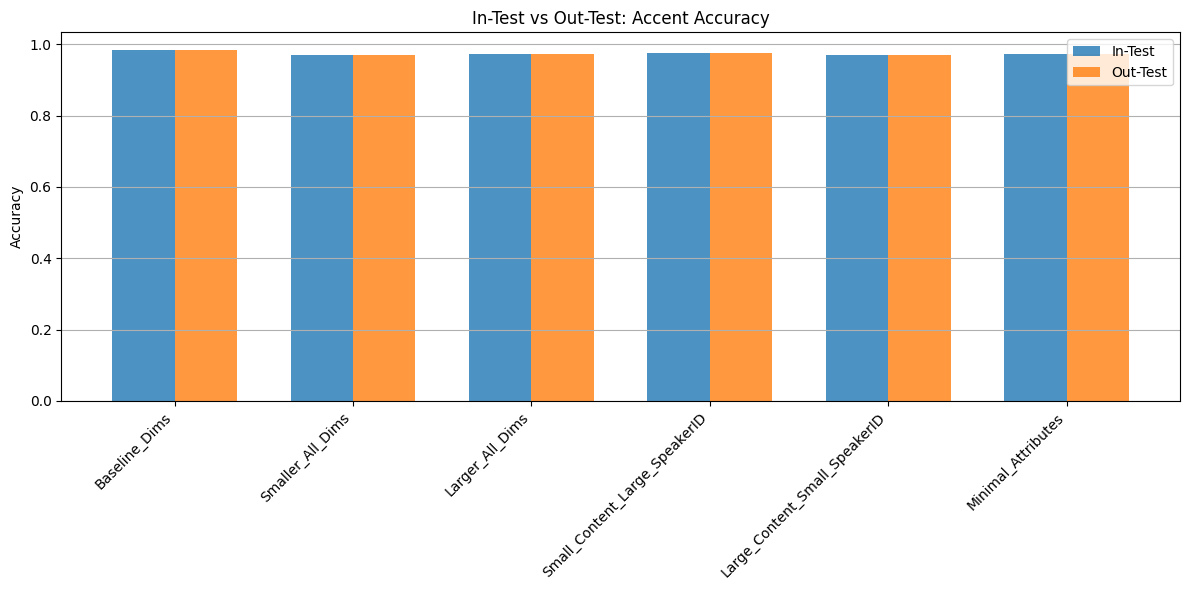

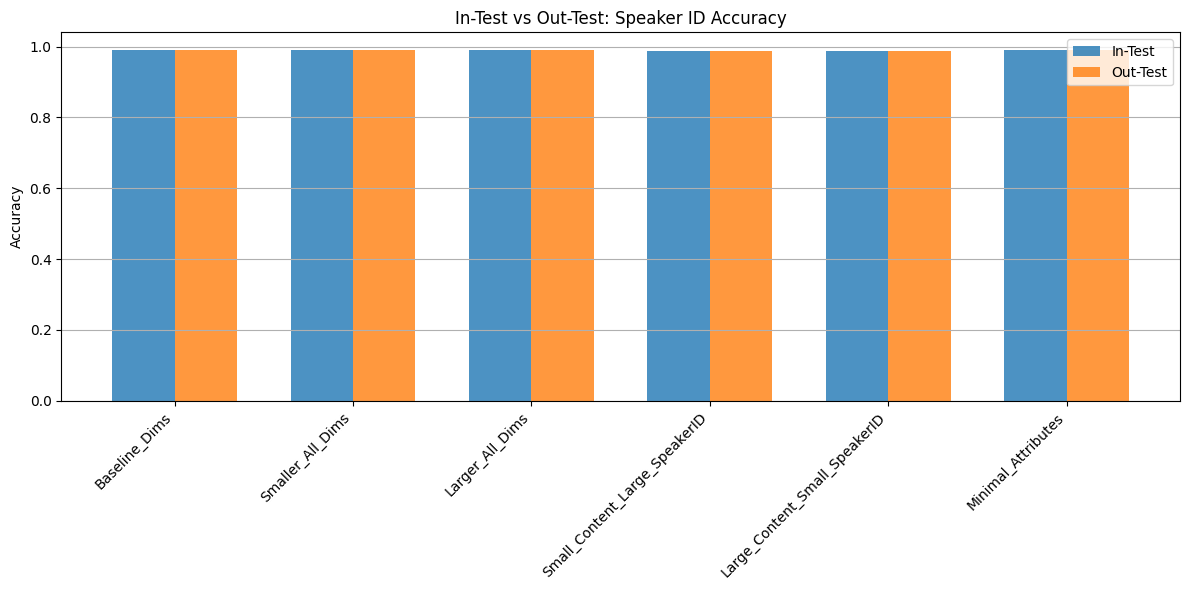

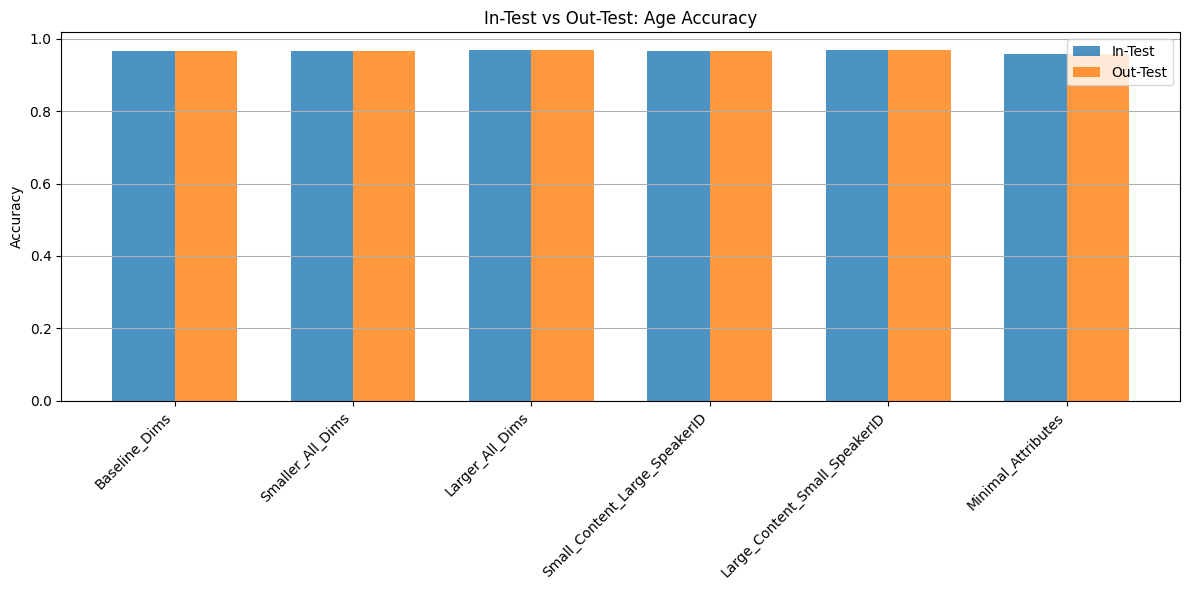

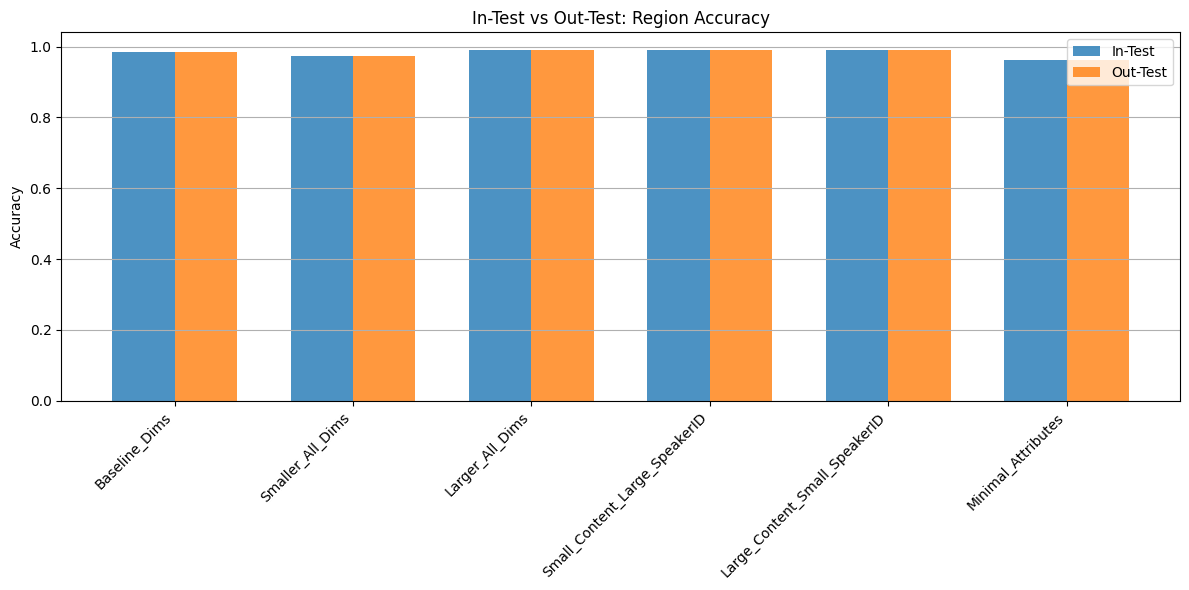

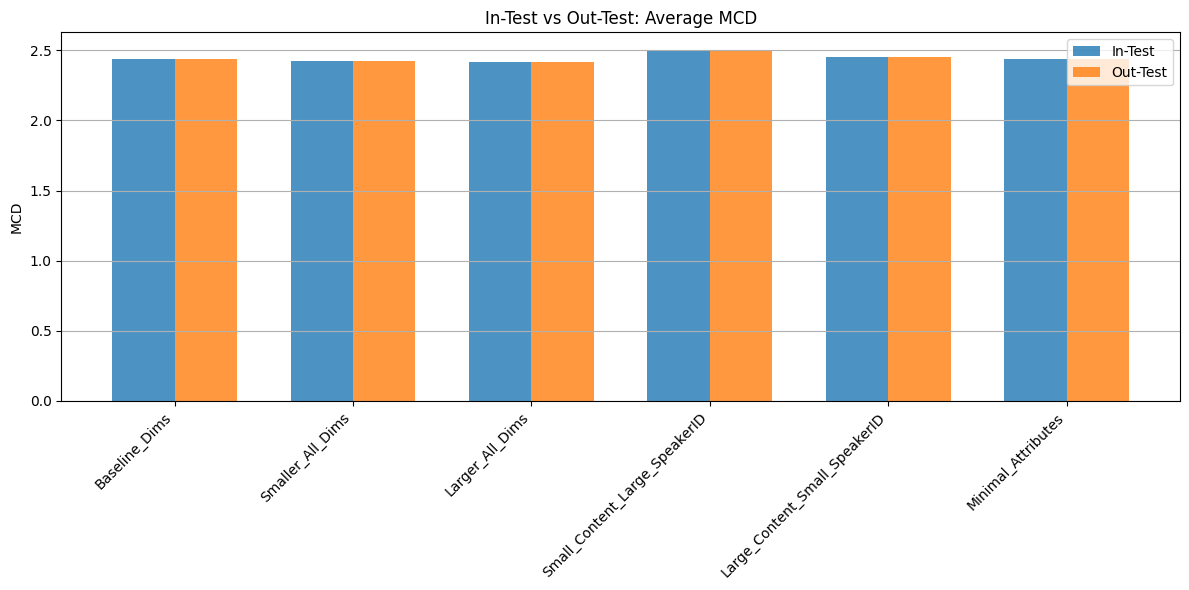

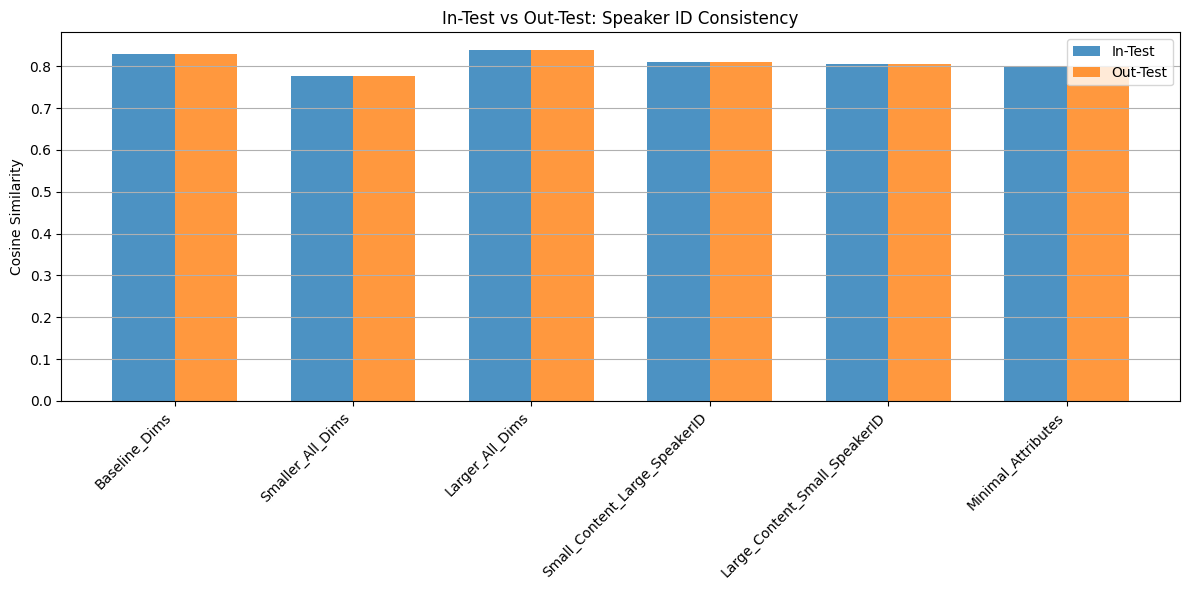

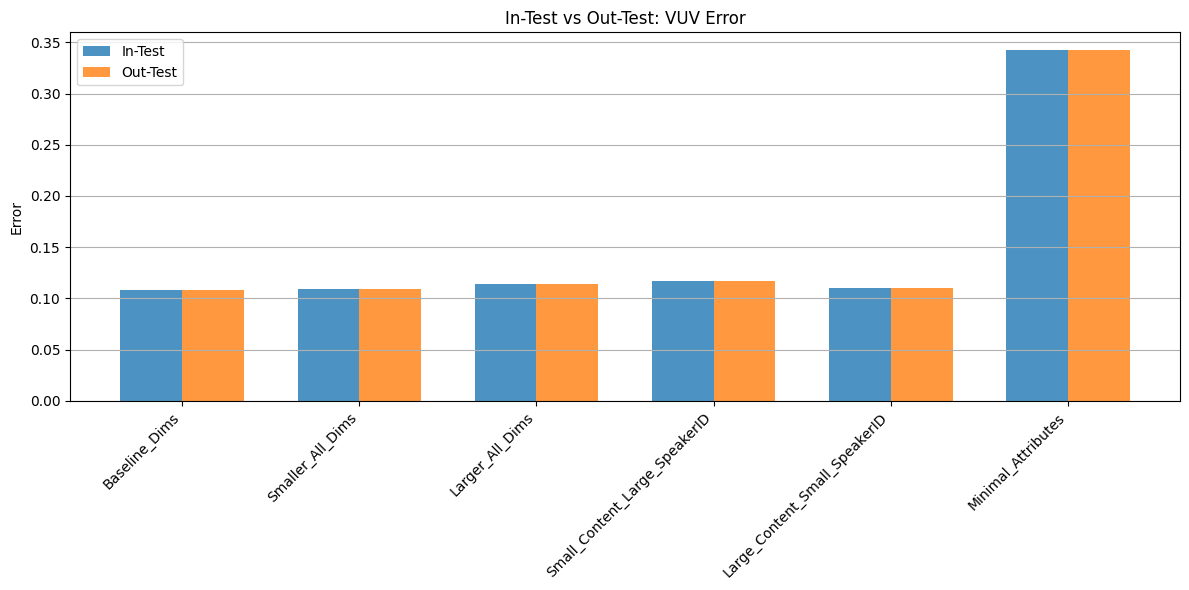

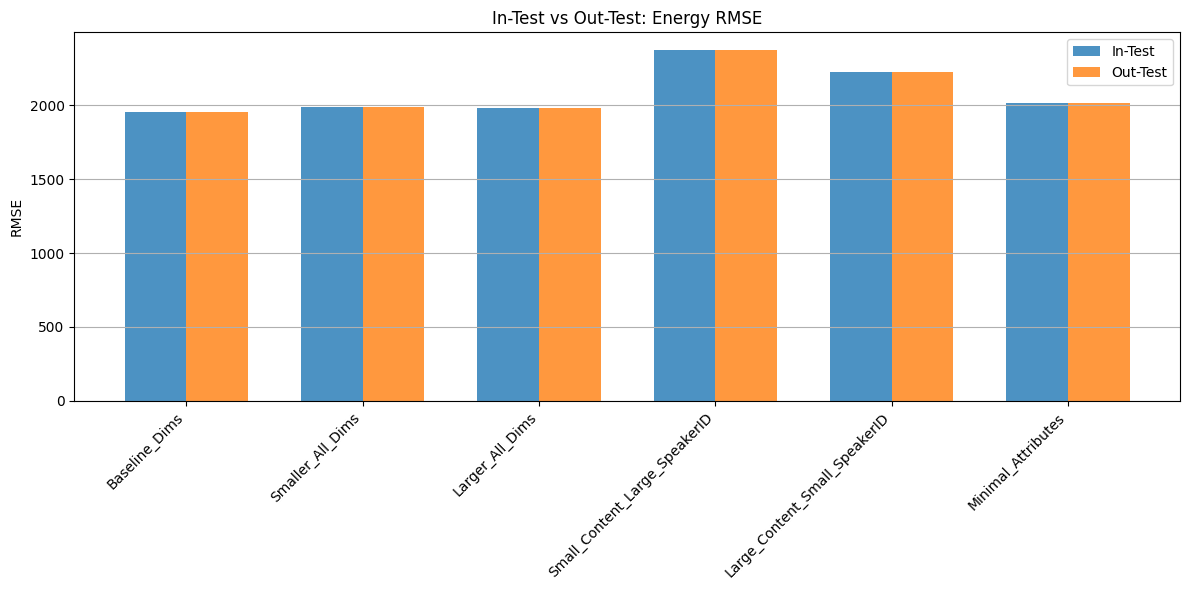

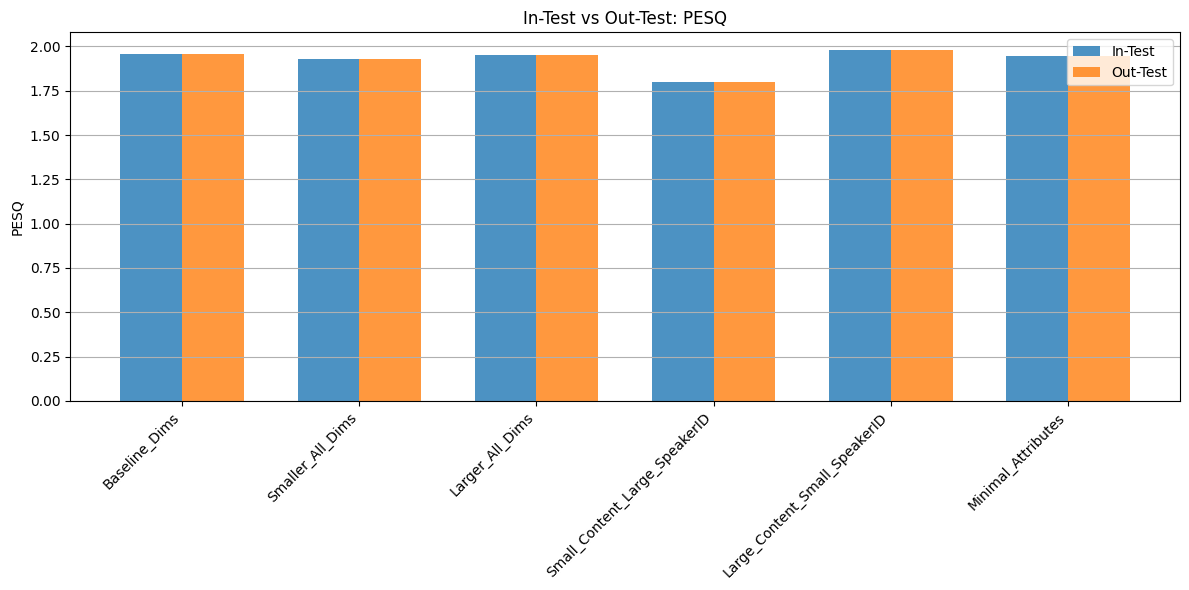

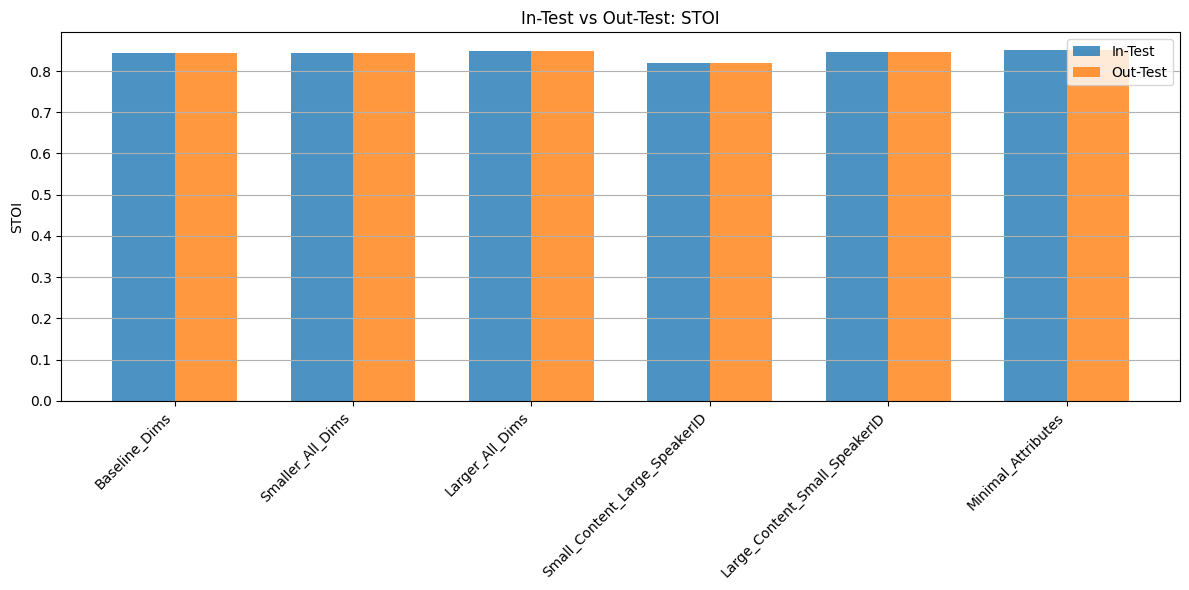

In [ ]:
# Fixed Comparison Plots: In-Test vs Out-Test for Each Metric
comparison_metrics = [
    ("total_loss", "Total Loss", "Loss"),
    ("reco_loss", "Reconstruction Loss", "Loss"),
    ("gender_acc", "Gender Accuracy", "Accuracy"),
    ("accent_acc", "Accent Accuracy", "Accuracy"),
    ("speaker_id_acc", "Speaker ID Accuracy", "Accuracy"),
    ("age_acc", "Age Accuracy", "Accuracy"),
    ("region_acc", "Region Accuracy", "Accuracy"),
    ("average_mcd", "Average MCD", "MCD"),
    ("speaker_id_consistency", "Speaker ID Consistency", "Cosine Similarity"),
    ("disentanglement_accuracy", "Disentanglement Accuracy", "Accuracy"),
]

# Special handling for audio quality metrics
audio_metrics = [
    ("f0_rmses", "F0 RMSE", "RMSE"),
    ("f0_correlations", "F0 Correlation", "Correlation"),
    ("vuv_errors", "VUV Error", "Error"),
    ("energy_rmses", "Energy RMSE", "RMSE"),
    ("pesq_summarys", "PESQ", "PESQ"),
    ("stoi_summarys", "STOI", "STOI")
]

# Create comparison plots for regular metrics
for metric_key, title, ylabel in comparison_metrics:
    plt.figure(figsize=(12, 6))

    x = np.arange(len(exp_names))
    width = 0.35

    in_values = [data["in_test_metrics"][metric_key] for data in all_data]
    out_values = [data["out_test_metrics"][metric_key] for data in all_data]

    plt.bar(x - width/2, in_values, width, label='In-Test', alpha=0.8)
    plt.bar(x + width/2, out_values, width, label='Out-Test', alpha=0.8)

    plt.title(f"In-Test vs Out-Test: {title}")
    plt.ylabel(ylabel)
    plt.xticks(x, exp_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"comparison_{metric_key}.png", dpi=300, bbox_inches='tight')
    plt.show()

# Create comparison plots for audio metrics
for metric_base, title, ylabel in audio_metrics:
    plt.figure(figsize=(12, 6))

    x = np.arange(len(exp_names))
    width = 0.35

    in_values = [data["in_test_metrics"][f"in_test_{metric_base}"] for data in all_data]
    out_values = [data["out_test_metrics"][f"out_test_{metric_base}"] for data in all_data]

    plt.bar(x - width/2, in_values, width, label='In-Test', alpha=0.8)
    plt.bar(x + width/2, out_values, width, label='Out-Test', alpha=0.8)

    plt.title(f"In-Test vs Out-Test: {title}")
    plt.ylabel(ylabel)
    plt.xticks(x, exp_names, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.savefig(f"comparison_{metric_base}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [ ]:
Config.VC_Output = "/content/drive/MyDrive/29_MFCCGAN-VC/PreProcessed2"

In [ ]:
# --- The validate_epoch function should be updated in a very similar way ---
def validate_epoch(model, dataloader,
                   reconstruction_criterion,
                   gender_criterion, accent_criterion, speaker_id_criterion,
                   age_criterion, region_criterion,
                   content_disentanglement_criterion,
                   device): # Keep this signature as is

    model.eval()
    total_loss = 0.0
    reco_loss_sum = 0.0
    gender_loss_sum = 0.0
    accent_loss_sum = 0.0
    speaker_id_loss_sum = 0.0
    age_loss_sum = 0.0
    region_loss_sum = 0.0
    disentangle_loss_sum = 0.0

    correct_gender, total_gender = 0, 0
    correct_accent, total_accent = 0, 0
    correct_speaker_id, total_speaker_id = 0, 0
    correct_age, total_age = 0, 0
    correct_region, total_region = 0, 0

    # Loss weights (should be the same as in train_epoch for consistent evaluation)
    lambda_reco = 1.0
    lambda_gender = 0.1
    lambda_accent = 0.1
    lambda_speaker_id = 0.5
    lambda_age = 0.1
    lambda_region = 0.1
    lambda_disentangle = 0.01

    # Initialize lists for batch-wise metrics for final average calculation
    batch_mcds = []
    batch_speaker_id_consistencies = []
    batch_disentanglement_accuracies = []

    #####
    # Initialize evaluator for this epoch
    vc_evaluator.reset_metrics()

    #####

    with torch.no_grad():
        pbar = tqdm(dataloader, desc="Validation", leave=False)
        for batch_idx, batch in enumerate(pbar):
            mel_spec = batch['mel_spec'].to(device)
            speaker_id_labels = batch['speaker_id'].to(device)
            gender_id_labels = batch['gender_id'].to(device)
            accent_id_labels = batch['accent_id'].to(device)
            age_id_labels = batch['age_id'].to(device)
            region_id_labels = batch['region_id'].to(device)

            reconstructed_mel, encoded_outputs = model(mel_spec)

            loss_reco = reconstruction_criterion(reconstructed_mel, mel_spec)
            loss_gender = gender_criterion(encoded_outputs['gender_logits'], gender_id_labels)
            loss_accent = accent_criterion(encoded_outputs['accent_logits'], accent_id_labels)
            loss_speaker_id = speaker_id_criterion(encoded_outputs['speaker_id_logits'], speaker_id_labels)
            loss_age = age_criterion(encoded_outputs['age_logits'], age_id_labels)
            loss_region = region_criterion(encoded_outputs['region_logits'], region_id_labels)

            # FIX: Handle content disentanglement loss properly
            content_output = encoded_outputs['content_speaker_discriminator_logits']

            # Check if shapes match for MSE loss
            if content_output.shape == speaker_id_labels.shape:
                # Direct MSE loss if shapes match
                loss_disentangle = content_disentanglement_criterion(content_output, speaker_id_labels)
            else:
                # Handle shape mismatch - use cross entropy for classification
                # First, check if we need to reduce dimensions
                if content_output.dim() > 2:
                    content_output = content_output.mean(dim=-1)  # Average over time dimension

                # Use cross entropy for classification
                loss_disentangle = torch.nn.functional.cross_entropy(content_output, speaker_id_labels)

            current_batch_loss = (
                lambda_reco * loss_reco +
                lambda_gender * loss_gender +
                lambda_accent * loss_accent +
                lambda_speaker_id * loss_speaker_id +
                lambda_age * loss_age +
                lambda_region * loss_region +
                lambda_disentangle * loss_disentangle
            )

            total_loss += current_batch_loss.item()
            reco_loss_sum += loss_reco.item()
            gender_loss_sum += loss_gender.item()
            accent_loss_sum += loss_accent.item()
            speaker_id_loss_sum += loss_speaker_id.item()
            age_loss_sum += loss_age.item()
            region_loss_sum += loss_region.item()
            disentangle_loss_sum += loss_disentangle.item()

            # --- Calculate new metrics for the current batch ---
            for i in range(mel_spec.shape[0]):
                # MCD for current sample
                original_len = (mel_spec[i].sum(dim=0) != 0).sum()
                reco_len = (reconstructed_mel[i].sum(dim=0) != 0).sum()
                if original_len > 0 and reco_len > 0: # Avoid empty samples
                    mcd = mcd_evaluator.calculate_mcd(
                        mel_spec[i, :, :original_len],
                        reconstructed_mel[i, :, :reco_len]
                    )
                    batch_mcds.append(mcd)

                # Speaker ID Consistency for current sample
                # Ensure z_speaker_id from original are 1D vectors for cosine similarity (mean over time if 3D)
                z_speaker_id_original = encoded_outputs['z_speaker_id'][i]
                if z_speaker_id_original.ndim == 2: # (Z_DIM, N_FRAMES)
                    z_speaker_id_original = z_speaker_id_original.mean(dim=-1)

                # Re-encode the reconstructed Mel for current sample
                reco_sample_mel_i = reconstructed_mel[i].unsqueeze(0) # Add batch dim back (1, N_MELS, T)

                # --- CRITICAL FIX: Match the pipeline for speaker_id_encoder ---
                shared_features_reconstructed_i = model.encoders.shared_extractor(reco_sample_mel_i)
                pooled_shared_features_reconstructed_i = F.adaptive_avg_pool1d(shared_features_reconstructed_i, 1).squeeze(-1)
                input_to_speaker_id_encoder_i = pooled_shared_features_reconstructed_i.unsqueeze(-1) # Shape (1, C, 1)

                z_speaker_id_reconstructed, _ = model.encoders.speaker_id_encoder(input_to_speaker_id_encoder_i)
                if z_speaker_id_reconstructed.ndim == 3: # (1, Z_DIM, N_FRAMES)
                    z_speaker_id_reconstructed = z_speaker_id_reconstructed.mean(dim=-1) # (1, Z_DIM)
                z_speaker_id_reconstructed = z_speaker_id_reconstructed.squeeze(0) # Remove batch dim

                cosine_sim = F.cosine_similarity(z_speaker_id_original.unsqueeze(0), z_speaker_id_reconstructed.unsqueeze(0), dim=1).item()
                batch_speaker_id_consistencies.append(cosine_sim)

            # Content Disentanglement for current batch (calculated directly from output)
            # Fix for dimension mismatch in content disentanglement accuracy calculation
            try:
                _, predicted_disc_speaker_id = torch.max(encoded_outputs['content_speaker_discriminator_logits'], 1)
                correct_disc_predictions = (predicted_disc_speaker_id == speaker_id_labels).sum().item()
                batch_disentanglement_accuracies.append(correct_disc_predictions / speaker_id_labels.size(0))
            except RuntimeError as e:
                if "size mismatch" in str(e):
                    # Skip this metric if there's a dimension mismatch
                    batch_disentanglement_accuracies.append(0.0)
                else:
                    raise e

            # Update accuracies (your existing logic for accuracies is fine)
            _, predicted_gender = torch.max(encoded_outputs['gender_logits'], 1)
            correct_gender += (predicted_gender == gender_id_labels).sum().item()
            total_gender += gender_id_labels.size(0)

            _, predicted_accent = torch.max(encoded_outputs['accent_logits'], 1)
            correct_accent += (predicted_accent == accent_id_labels).sum().item()
            total_accent += accent_id_labels.size(0)

            _, predicted_speaker_id = torch.max(encoded_outputs['speaker_id_logits'], 1)
            correct_speaker_id += (predicted_speaker_id == speaker_id_labels).sum().item()
            total_speaker_id += speaker_id_labels.size(0)

            _, predicted_age = torch.max(encoded_outputs['age_logits'], 1)
            correct_age += (predicted_age == age_id_labels).sum().item()
            total_age += age_id_labels.size(0)

            _, predicted_region = torch.max(encoded_outputs['region_logits'], 1)
            correct_region += (predicted_region == region_id_labels).sum().item()
            total_region += region_id_labels.size(0)

            # Audio evaluation for quality metrics
            try:
                source_audio_batch = vocoder.generate_audio(mel_spec, Config.SAMPLE_RATE, output_dir=Config.vocoder_wave_output_dir)
                reconstructed_audio_batch = vocoder.generate_audio(reconstructed_mel, Config.SAMPLE_RATE, output_dir=Config.vocoder_wave_output_dir)

                # Evaluate the batch
                batch_metrics = vc_evaluator.evaluate_batch(
                    source_audio_batch,
                    reconstructed_audio_batch,
                    original_mel=mel_spec,
                    converted_mel=reconstructed_mel
                )
            except Exception as e:
                print(f"Error in audio evaluation: {e}")
                batch_metrics = {}

            # Update progress bar with metrics
            pbar.set_postfix({
                'V_Loss': f'{current_batch_loss.item():.4f}',
                'Reco': f'{loss_reco.item():.4f}',
                'Dis': f'{loss_disentangle.item():.4f}',
                'MCD': f'{np.mean(batch_mcds) if batch_mcds else 0:.2f}',
                'S_ID_Con': f'{np.mean(batch_speaker_id_consistencies) if batch_speaker_id_consistencies else 0:.2f}',
                'Disc_Acc': f'{np.mean(batch_disentanglement_accuracies)*100 if batch_disentanglement_accuracies else 0:.1f}%',
                'S_Acc': f'{100 * correct_speaker_id / total_speaker_id if total_speaker_id > 0 else 0:.2f}%',
                'F0_RMSE': f'{batch_metrics.get("f0_rmse", 0):.2f}' if batch_metrics else 'N/A',
                'Spk_Sim': f'{batch_metrics.get("speaker_similarity", 0):.3f}' if batch_metrics else 'N/A'
            })

    avg_loss = total_loss / len(dataloader)
    avg_reco_loss = reco_loss_sum / len(dataloader)
    avg_gender_loss = gender_loss_sum / len(dataloader)
    avg_accent_loss = accent_loss_sum / len(dataloader)
    avg_speaker_id_loss = speaker_id_loss_sum / len(dataloader)
    avg_age_loss = age_loss_sum / len(dataloader)
    avg_region_loss = region_loss_sum / len(dataloader)
    avg_disentangle_loss = disentangle_loss_sum / len(dataloader)

    gender_accuracy = correct_gender / total_gender if total_gender > 0 else 0
    accent_accuracy = correct_accent / total_accent if total_accent > 0 else 0
    speaker_id_accuracy = correct_speaker_id / total_speaker_id if total_speaker_id > 0 else 0
    age_accuracy = correct_age / total_age if total_age > 0 else 0
    region_accuracy = correct_region / total_region if total_region > 0 else 0

    # Final averages for new metrics
    avg_mcd = np.mean(batch_mcds) if batch_mcds else 0.0
    avg_speaker_id_consistency = np.mean(batch_speaker_id_consistencies) if batch_speaker_id_consistencies else 0.0
    avg_disentanglement_accuracy = np.mean(batch_disentanglement_accuracies) if batch_disentanglement_accuracies else 0.0

    # Get final metrics summary from evaluator
    try:
        metrics_summary = vc_evaluator.get_summary()
    except Exception as e:
        print(f"Error getting metrics summary: {e}")
        metrics_summary = {}

    # Return all metrics, including the new ones
    return {
        # Loss metrics
        'avg_loss': avg_loss,
        'avg_reco_loss': avg_reco_loss,
        'avg_gender_loss': avg_gender_loss,
        'avg_accent_loss': avg_accent_loss,
        'avg_speaker_id_loss': avg_speaker_id_loss,
        'avg_age_loss': avg_age_loss,
        'avg_region_loss': avg_region_loss,
        'avg_disentangle_loss': avg_disentangle_loss,

        # Accuracy metrics
        'gender_accuracy': gender_accuracy,
        'accent_accuracy': accent_accuracy,
        'speaker_id_accuracy': speaker_id_accuracy,
        'age_accuracy': age_accuracy,
        'region_accuracy': region_accuracy,

        # Voice conversion metrics (from evaluator)
        'mcd': metrics_summary.get('mcd', {}).get('mean', 0),
        'speaker_similarity': metrics_summary.get('speaker_similarity', {}).get('mean', 0),
        'f0_rmse': metrics_summary.get('f0_rmse', {}).get('mean', 0),
        'f0_correlation': metrics_summary.get('f0_correlation', {}).get('mean', 0),
        'vuv_error': metrics_summary.get('vuv_error', {}).get('mean', 0),
        'energy_rmse': metrics_summary.get('energy_rmse', {}).get('mean', 0),
        'pesq': metrics_summary.get('pesq', {}).get('mean', 0),  # Added PESQ
        'stoi': metrics_summary.get('stoi', {}).get('mean', 0),  # Added STOI

        # Additional metrics from your original return
        'avg_mcd': avg_mcd,
        'avg_speaker_id_consistency': avg_speaker_id_consistency,
        'avg_disentanglement_accuracy': avg_disentanglement_accuracy,

        # Content preservation metrics (to be calculated separately)
        'cer': 0.0,  # Placeholder - you'll need to implement CER calculation
        'wer': 0.0,   # Placeholder - you'll need to implement WER calculation

        # Full metrics summary for detailed analysis
        'full_metrics_summary': metrics_summary
    }

In [ ]:
import torch
import json
import os


# Set device
device = Config.DEVICE

# Load your dataloaders (make sure these are defined)
# in_test_dataloader = ...
# out_test_dataloader = ...

# Define your loss criteria
reconstruction_criterion = torch.nn.MSELoss()
gender_criterion = torch.nn.CrossEntropyLoss()
accent_criterion = torch.nn.CrossEntropyLoss()
speaker_id_criterion = torch.nn.CrossEntropyLoss()
age_criterion = torch.nn.CrossEntropyLoss()
region_criterion = torch.nn.CrossEntropyLoss()
content_disentanglement_criterion = torch.nn.MSELoss()

# Directory containing saved models
models_dir = Config.VC_Output
model_files = [
    "best_vc_model_Baseline_Dims.pth",
    "best_vc_model_Large_Content_Small_SpeakerID.pth",
    "best_vc_model_Larger_All_Dims.pth",
    "best_vc_model_Minimal_Attributes.pth",
    "best_vc_model_Small_Content_Large_SpeakerID.pth",
    "best_vc_model_Smaller_All_Dims.pth"
]

# Create a directory for evaluation results
eval_results_dir = os.path.join(Config.VC_Output, "evaluation_results")
os.makedirs(eval_results_dir, exist_ok=True)

# Initialize model (we'll load weights for each model file)
# model = YourModelClass().to(device)  # Replace with your model initialization
model = VCModel(Config, num_genders, num_accents, num_speakers, num_ages, num_regions).to(Config.DEVICE)
# optimizer = torch.optim.Adam(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)

for model_file in model_files:
    model_path = os.path.join(models_dir, model_file)

    if not os.path.exists(model_path):
        print(f"Model file {model_path} not found. Skipping.")
        continue

    print(f"Evaluating {model_file}...")

    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    # Run validation on in-test dataset
    in_test_metrics = validate_epoch(
        model,
        in_test_dataloader,
        reconstruction_criterion, gender_criterion, accent_criterion, speaker_id_criterion,
        age_criterion, region_criterion,
        content_disentanglement_criterion,
        device
    )

    # Run validation on out-test dataset
    out_test_metrics = validate_epoch(
        model,
        out_test_dataloader,
        reconstruction_criterion, gender_criterion, accent_criterion, speaker_id_criterion,
        age_criterion, region_criterion,
        content_disentanglement_criterion,
        device
    )

    # Extract metrics from in-test
    in_test_loss = in_test_metrics['avg_loss']
    in_test_reco_loss = in_test_metrics['avg_reco_loss']
    in_test_gender_acc = in_test_metrics['gender_accuracy']
    in_test_accent_acc = in_test_metrics['accent_accuracy']
    in_test_speaker_id_acc = in_test_metrics['speaker_id_accuracy']
    in_test_age_acc = in_test_metrics['age_accuracy']
    in_test_region_acc = in_test_metrics['region_accuracy']
    in_test_average_mcd1 = in_test_metrics['avg_mcd']
    in_test_average_speaker_id_consistency = in_test_metrics['avg_speaker_id_consistency']
    in_test_disentanglement_accuracy = in_test_metrics['avg_disentanglement_accuracy']
    in_test_f0_rmse_summary_mean = in_test_metrics['f0_rmse']
    in_test_f0_correlation_summary_mean = in_test_metrics['f0_correlation']
    in_test_vuv_error_summary_mean = in_test_metrics['vuv_error']
    in_test_energy_rmse_summary_mean = in_test_metrics['energy_rmse']
    in_test_pesq_summary_mean = in_test_metrics['pesq']
    in_test_stoi_summary_mean = in_test_metrics['stoi']

    # Extract metrics from out-test
    out_test_loss = out_test_metrics['avg_loss']
    out_test_reco_loss = out_test_metrics['avg_reco_loss']
    out_test_gender_acc = out_test_metrics['gender_accuracy']
    out_test_accent_acc = out_test_metrics['accent_accuracy']
    out_test_speaker_id_acc = out_test_metrics['speaker_id_accuracy']
    out_test_age_acc = out_test_metrics['age_accuracy']
    out_test_region_acc = out_test_metrics['region_accuracy']
    out_test_average_mcd1 = out_test_metrics['avg_mcd']
    out_test_average_speaker_id_consistency = out_test_metrics['avg_speaker_id_consistency']
    out_test_disentanglement_accuracy = out_test_metrics['avg_disentanglement_accuracy']
    out_test_f0_rmse_summary_mean = out_test_metrics['f0_rmse']
    out_test_f0_correlation_summary_mean = out_test_metrics['f0_correlation']
    out_test_vuv_error_summary_mean = out_test_metrics['vuv_error']
    out_test_energy_rmse_summary_mean = out_test_metrics['energy_rmse']
    out_test_pesq_summary_mean = out_test_metrics['pesq']
    out_test_stoi_summary_mean = out_test_metrics['stoi']

    # Prepare results dictionary
    experiment_results = {
        "model_name": model_file,
        "in_test_metrics": {
            "total_loss": in_test_loss.item() if hasattr(in_test_loss, 'item') else float(in_test_loss),
            "reco_loss": in_test_reco_loss.item() if hasattr(in_test_reco_loss, 'item') else float(in_test_reco_loss),
            "gender_acc": in_test_gender_acc.item() if hasattr(in_test_gender_acc, 'item') else float(in_test_gender_acc),
            "accent_acc": in_test_accent_acc.item() if hasattr(in_test_accent_acc, 'item') else float(in_test_accent_acc),
            "speaker_id_acc": in_test_speaker_id_acc.item() if hasattr(in_test_speaker_id_acc, 'item') else float(in_test_speaker_id_acc),
            "age_acc": in_test_age_acc.item() if hasattr(in_test_age_acc, 'item') else float(in_test_age_acc),
            "region_acc": in_test_region_acc.item() if hasattr(in_test_region_acc, 'item') else float(in_test_region_acc),
            "average_mcd": in_test_average_mcd1.item() if hasattr(in_test_average_mcd1, 'item') else float(in_test_average_mcd1),
            "speaker_id_consistency": in_test_average_speaker_id_consistency.item() if hasattr(in_test_average_speaker_id_consistency, 'item') else float(in_test_average_speaker_id_consistency),
            "disentanglement_accuracy": in_test_disentanglement_accuracy.item() if hasattr(in_test_disentanglement_accuracy, 'item') else float(in_test_disentanglement_accuracy),
            "in_test_f0_rmses": in_test_f0_rmse_summary_mean.item() if hasattr(in_test_f0_rmse_summary_mean, 'item') else float(in_test_f0_rmse_summary_mean),
            "in_test_f0_correlations": in_test_f0_correlation_summary_mean.item() if hasattr(in_test_f0_correlation_summary_mean, 'item') else float(in_test_f0_correlation_summary_mean),
            "in_test_vuv_errors": in_test_vuv_error_summary_mean.item() if hasattr(in_test_vuv_error_summary_mean, 'item') else float(in_test_vuv_error_summary_mean),
            "in_test_energy_rmses": in_test_energy_rmse_summary_mean.item() if hasattr(in_test_energy_rmse_summary_mean, 'item') else float(in_test_energy_rmse_summary_mean),
            "in_test_pesq_summarys": in_test_pesq_summary_mean.item() if hasattr(in_test_pesq_summary_mean, 'item') else float(in_test_pesq_summary_mean),
            "in_test_stoi_summarys": in_test_stoi_summary_mean.item() if hasattr(in_test_stoi_summary_mean, 'item') else float(in_test_stoi_summary_mean),
        },
        "out_test_metrics": {
            "total_loss": out_test_loss.item() if hasattr(out_test_loss, 'item') else float(out_test_loss),
            "reco_loss": out_test_reco_loss.item() if hasattr(out_test_reco_loss, 'item') else float(out_test_reco_loss),
            "gender_acc": out_test_gender_acc.item() if hasattr(out_test_gender_acc, 'item') else float(out_test_gender_acc),
            "accent_acc": out_test_accent_acc.item() if hasattr(out_test_accent_acc, 'item') else float(out_test_accent_acc),
            "speaker_id_acc": out_test_speaker_id_acc.item() if hasattr(out_test_speaker_id_acc, 'item') else float(out_test_speaker_id_acc),
            "age_acc": out_test_age_acc.item() if hasattr(out_test_age_acc, 'item') else float(out_test_age_acc),
            "region_acc": out_test_region_acc.item() if hasattr(out_test_region_acc, 'item') else float(out_test_region_acc),
            "average_mcd": out_test_average_mcd1.item() if hasattr(out_test_average_mcd1, 'item') else float(out_test_average_mcd1),
            "speaker_id_consistency": out_test_average_speaker_id_consistency.item() if hasattr(out_test_average_speaker_id_consistency, 'item') else float(out_test_average_speaker_id_consistency),
            "disentanglement_accuracy": out_test_disentanglement_accuracy.item() if hasattr(out_test_disentanglement_accuracy, 'item') else float(out_test_disentanglement_accuracy),
            "out_test_f0_rmses": out_test_f0_rmse_summary_mean.item() if hasattr(out_test_f0_rmse_summary_mean, 'item') else float(out_test_f0_rmse_summary_mean),
            "out_test_f0_correlations": out_test_f0_correlation_summary_mean.item() if hasattr(out_test_f0_correlation_summary_mean, 'item') else float(out_test_f0_correlation_summary_mean),
            "out_test_vuv_errors": out_test_vuv_error_summary_mean.item() if hasattr(out_test_vuv_error_summary_mean, 'item') else float(out_test_vuv_error_summary_mean),
            "out_test_energy_rmses": out_test_energy_rmse_summary_mean.item() if hasattr(out_test_energy_rmse_summary_mean, 'item') else float(out_test_energy_rmse_summary_mean),
            "out_test_pesq_summarys": out_test_pesq_summary_mean.item() if hasattr(out_test_pesq_summary_mean, 'item') else float(out_test_pesq_summary_mean),
            "out_test_stoi_summarys": out_test_stoi_summary_mean.item() if hasattr(out_test_stoi_summary_mean, 'item') else float(out_test_stoi_summary_mean),
        }
    }

    # Save results to JSON file
    results_filename = f"eval_{os.path.splitext(model_file)[0]}.json"
    results_path = os.path.join(eval_results_dir, results_filename)

    with open(results_path, 'w') as f:
        json.dump(experiment_results, f, indent=4)

    print(f"Results saved to {results_path}")

print("All models evaluated successfully!")